In [2]:
#A code to fit continuum, pseudo-continuum, and/or baselines to image cubes from the JWST nirspec ifu
#By Adam E. Rubinstein

# load important packages
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline, CubicSpline
import os
import sys

from astropy import units as u
from astropy.io import fits
import pandas as pd
from photutils.aperture import RectangularAperture #, RectangularAnnulus, SkyCircularAperture
from spectral_cube import SpectralCube

# Setup for Baseline Techniques

In [3]:
#setting up some initial lists

from pybaselines import Baseline, misc #, utils
from scipy.signal import medfilt, savgol_filter

#used for plotting
protostar_names = ['IRAS 16253-2429', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126+4104'] 

#the original data
cube_file_list = ['IRAS16253/jw01802-o015_t012_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'B335/jw01802-o003_t001_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS153/jw01802-o019_t015_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS370/jw01802-o007_t004_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'IRAS20126/jw01802-o011_t007_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits']

#derived data or cubes
protostar_substr = ['IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
absorb_emiss_path = 'Extended_CO_CO2/CO_Absorption_Emission_Maps/'
absorb_emiss_cube_list = [glob(absorb_emiss_path + i + '*cube*.fits')[0].replace('\\', '/') for i in protostar_substr]
absorb_emiss_txt_list = [glob(absorb_emiss_path + i + '*txt')[0].replace('\\', '/') for i in protostar_substr]

#source properties
central_sources_list = [[(47,45)], [(53,43), (45,43)], [(42, 45), (49, 54)], [(42, 38), (42, 46)], [(42, 43), (58, 52)]] #based on line to cont ratio
isotope_theta = [0.0, 0.0, 50.0, 0.0, 35.0]
arc_to_pix = 2.7777778191699e-05 * 3600.0 #take 1 pix in degrees, convert to arcsec, then can divide by this to convert
aper_dims = [(0.51, 0.51), (0.68, 0.68), (0.53, 0.53), (0.67, 0.67), (0.49, 0.44)] #arcsecs
source_names_list = ['IRAS 16253-2429', ['B335W', 'B335E'], ['HOPS 153SE', 'HOPS 153NW'], ['HOPS 370S', 'HOPS 370N'], ['IRAS 20126+4104SE', 'IRAS 20126+4104NW']]


# Create plots of systematics when fitting by hand

-R(lambda) vs lambda, which shows spectral resolution (or FWHM) as function of wavelength

-Line offset vs. line center to show if the offsets with respect to wavelength is something dispersion or not

-overlapping lines?

In [61]:
fitting_path = 'fityk_byhand/' #for fityk

#for the next part, to prepare, we'll want all the baselines, extracted in apertures
baseline_file_list = [glob('Baseline/*' + i + '*.fits')[0].replace('\\', '/') for i in protostar_substr] #change the wildcard '*' here!
wave_cutoffs_compiled = [np.array([4.19, 4.32, 4.37, 4.415, 4.62, 4.72, 4.87, 4.941]), 
                            np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.71, 4.795, 4.85, 4.971]), 
                            np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.939]), 
                            np.array([4.19, 4.32, 4.37, 4.42, 4.58, 4.69, 4.79, 4.865, 4.939]), 
                            np.array([4.19, 4.32, 4.37, 4.4, 4.61, 4.695, 4.775, 4.84, 5.0])]

#loop through files and store data
baseline_wave_list =[]
baseline_fit_list = []
baseline_intensity_anchor_list = []
orig_data_list = []
err_list = []
fityk_spline_centers_list = []
fityk_intensity_list = []
fitky_spline_intensity_list = []
for i in range(len(baseline_file_list)):
    #need to do this first to get wavelengths and initialize some arrays for plotting spectra
    hdul = fits.open(cube_file_list[i]) #separated out line here since need to use hdul a few times
    orig_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
    wave = orig_cube.spectral_axis.value[1:-1]     # define the wavelength grid (microns) from the header #need to make correct axis size

    #initialized arrays
    baseline_fit = np.zeros(wave.shape) 
    orig_data = np.zeros(wave.shape) #to be filled in
    err_data = np.zeros(wave.shape) #to be filled in

    #set up units
    photometric_head = hdul[1].header
    delta_lambda = photometric_head['CDELT3'] #in microns ?
    pixel_area = photometric_head['PIXAR_SR'] # in sr
    sr_conversion = np.abs(photometric_head['CDELT1'] * photometric_head['CDELT2'] / (180. / np.pi)**2.0) #square degrees to steradians, should be consistent throughout all images (?)
    cube_units = 1e6 * 1e-23 * 3e14/wave**2. * delta_lambda * pixel_area # * sr_conversion

    #loop through each aperture for a given source
    for k in range(len(central_sources_list[i])):

        #now extract only a smaller portion from the general cubes
        rect_aper = RectangularAperture((central_sources_list[i][k][0], central_sources_list[i][k][1]), aper_dims[i][0]/arc_to_pix, aper_dims[i][1]/arc_to_pix, theta=isotope_theta[i]*np.pi/180) #only need to define once
        rect_mask = rect_aper.to_mask()

        #read in gas line-subtractions (baselines)
        processed_cube = SpectralCube.read(fits.open(baseline_file_list[i])[0]) #accessing the cube for data 
        data_list = [] #dummy list
        for data_2d in processed_cube._data: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        baseline_fit += np.sum(np.array(data_list), axis=(1,2))

        #read in original data and noise
        data_list = [] #dummy list
        for data_2d in orig_cube._data[1:-1,:,:]: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        orig_data += np.sum(np.array(data_list), axis=(1,2)) 

        data_list = [] #dummy list
        for data_2d in hdul['ERR'].data[1:-1,:,:]: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        err_data += np.sum(np.array(data_list), axis=(1,2)) 

    #store data for later
    baseline_wave_list.append(wave)
    baseline_fit_list.append(baseline_fit * cube_units)
    orig_data_list.append(orig_data * cube_units)
    err_list.append(err_data * cube_units)

    #and then one last version (from my own experimental methods with pyBaselines)
    baseline_fitter = Baseline(wave, check_finite=False)
    bkg_top = baseline_fitter.tophat(orig_data * cube_units, half_window=2)[0]
    cutoffs_flux_matched = bkg_top[[np.abs(wave - j).argmin() for j in wave_cutoffs_compiled[i]]]     #formulating regimes to cutoff the spectrum and apply different smoothing factors
    baseline_intensity_anchor_list.append(cutoffs_flux_matched)

    #and for the next part, let's check into the baselines we made in fityk...
    baseline_fityk_path = glob(fitting_path + '*' + protostar_names[i][-3:] + '*.dat')[0].replace('\\', '/') #locate .dat file
    spline_centers, spline_intensities = np.genfromtxt(baseline_fityk_path)[:,0], np.genfromtxt(baseline_fityk_path)[:,1] #read in data
    fityk_spline_centers_list.append(spline_centers) #add to a list
    fityk_intensity_list.append(spline_intensities)
    fitky_spline_intensity_list.append(orig_data * cube_units - spline_intensities) #this is actually the line data...so needs to be subtracted from observed data!


C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\263747755.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wave_centers_list = np.array(wave_centers_list)
C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\263747755.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spectral_res_list = np.array(spectral_res_list)


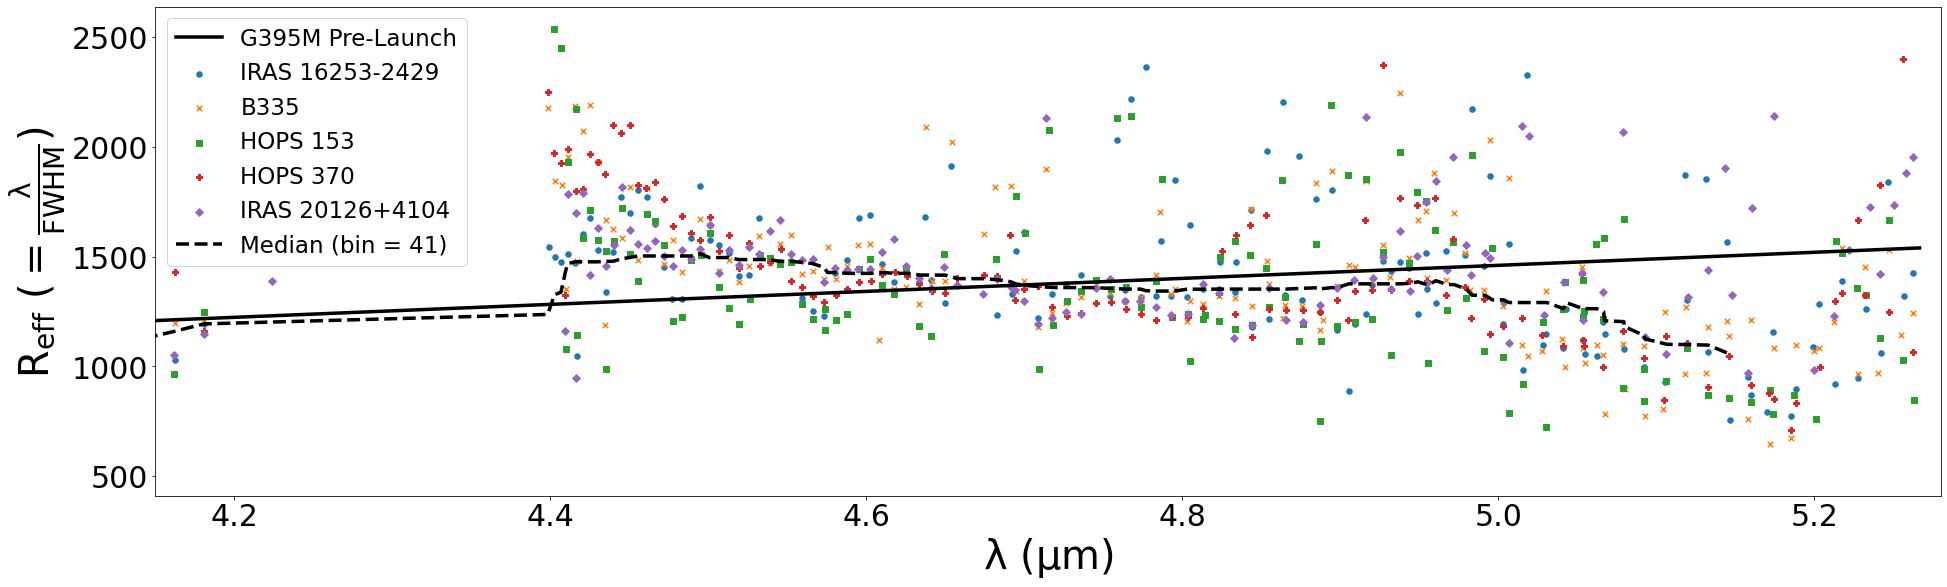

In [62]:
#FIRST SYSTEMATIC!
#widths...

#needs to be updated by hand unfortunately...
wavelength_offset_list_fwhm = [0.00010000000000021103, 0.00018000000000029104, -0.0003600000000005821, -0.00032999999999994145, 0.0001299999999995194]

#for spectral resolution, grab the file and read it in to measure systematics
#taken from https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-dispersers-and-filters
jwst_g395m_table_filename = 'jwst_nirspec_g395m_disp.fits'
hdul = fits.open(jwst_g395m_table_filename)  # open a FITS file
data = hdul[1].data
'''ColDefs(
name = 'WAVELENGTH'; format = 'E'; unit = 'MICRONS'
name = 'DLDS'; format = 'E'; unit = 'MICRONS/PIXEL'
name = 'R'; format = 'E'; unit = 'RESOLUTION'
'''
R_factor = 1.15
jwst_res_spline = UnivariateSpline(data['WAVELENGTH'], data['R']*R_factor)
R = jwst_res_spline(baseline_wave_list[3]) #mode for NIRSpec has R ~ 1000 ~ lambda / FWHM
# FWHM = wave / R  #this is delta lambda

#setup fig, axes
fig, ax = plt.subplots(figsize=(32,9)) 
ax.plot(baseline_wave_list[3], R, label='G395M Pre-Launch', color='black', linewidth=3.5) #plot ideal case pre-launch

#to analyze our median, we need some options like...
#function to compute a running average
# see https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
#also try median filter in scipy
from scipy.signal import medfilt

#loop through each protostar
#set up for some lists
count = 0
wave_centers_list = []
spectral_res_list = []
wave_heights_list = []
wave_fwhm_list = []
wave_areas_list = []
marker_list = ['o', 'x', 's', 'P', 'D']
for i in protostar_names:
    #i[-3:] is used here as the unique part of the numerical designation...probably better ways to do this
    peak_fit_path = glob(fitting_path + '*' + i[-3:] + '*.peaks')[0].replace('\\', '/') #locate peak file
    wave_centers, wave_heights, wave_areas, wave_fwhms = np.genfromtxt(peak_fit_path)[:,2], np.genfromtxt(peak_fit_path)[:,3], \
                    np.genfromtxt(peak_fit_path)[:,4], np.genfromtxt(peak_fit_path)[:,5]
    spectral_res = (wave_centers + wavelength_offset_list_fwhm[count]) / wave_fwhms #lambda / delta_lambda, used for plotting systematics

    #directly plot systematic effect for each protostar: how does FWHM and spectral resolution, R, depend on wavelength?
    # if count == 3:
    ax.scatter(wave_centers + wavelength_offset_list_fwhm[count], spectral_res, s=30, label=i, marker=marker_list[count]) #measured

    #sorting lists for later...
    spectral_res_sorted = [x for _, x in sorted(zip(wave_centers, spectral_res))] #sorting lists
    wave_heights_sorted = [x for _, x in sorted(zip(wave_centers, wave_heights))] #sorting lists
    wave_areas_sorted = [x for _, x in sorted(zip(wave_centers, wave_areas))] #sorting lists
    wave_fwhms_sorted = [x for _, x in sorted(zip(wave_centers, wave_fwhms))] #sorting lists

    #plotting moving average, trying a few different methods
    # spectral_res_median = [np.median(spectral_res_sorted[i-10:i+10]) for i in range(len(spectral_res_sorted[10:-10]))] #done by self
    # R_moving_avg_obs = moving_average(spectral_res_sorted, int(len(spectral_res_sorted)/5)) #done by function
    R_moving_avg_obs = medfilt(spectral_res_sorted, 41) #built into scipy
    # ax.plot(sorted(wave_centers), R_moving_avg_obs, linestyle='--', label='Moving Average', color='black')
    count +=1 

    #storing for lists
    #for tabulating, consider: are the areas in units of flux erg/s/cm^2 or in units of flux * wavelength?
    #also relevant to plotting an averaged curve of systematic properties
    wave_centers_list.append(np.array(sorted(wave_centers)))
    spectral_res_list.append(np.array(R_moving_avg_obs))
    wave_heights_list.append(np.array(wave_heights_sorted))
    wave_areas_list.append(np.array(wave_areas_sorted))
    wave_fwhm_list.append(np.array(wave_fwhms_sorted))


#now collecting values into numpy arrays and sorting and padding them to plot an average
wave_centers_list = np.array(wave_centers_list)
spectral_res_list = np.array(spectral_res_list)
longest_array_ind = [np.argmax([len(i) for i in wave_centers_list])][0]
wave_centers_padded = [np.resize(i, wave_centers_list[longest_array_ind].shape[0])*(wave_centers_list[longest_array_ind]/wave_centers_list[longest_array_ind]) \
                     for i in wave_centers_list]
spectral_res_padded = [np.resize(i, wave_centers_list[longest_array_ind].shape[0])*(wave_centers_list[longest_array_ind]/wave_centers_list[longest_array_ind]) \
                     for i in spectral_res_list]
ax.plot(np.nanmedian(wave_centers_padded, axis=0)[1:-27], np.nanmedian(spectral_res_padded, axis=0)[1:-27], \
            linewidth=3.5, linestyle='--', label='Median (bin = 41)', color='black')


#formatting
ax.set_xlim(4.15, 5.28)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.set_ylabel(r'$\rm R_{eff} \ (= \frac{\lambda}{FWHM})$', fontsize=40) #\Delta\lambda
ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
# ax.set_yscale('log')
ax.legend(loc='best', fontsize=23)
fig.savefig('CentralSource_CO/FWHM_Systematics.pdf')


# next systematic! Baselines

In [63]:
#noting baselines by hand  
#cubic spline - we only have three of the sources saved..won't remake unless have to...
#if you forget to get the baseline spline points in fityk...very difficult to get back, but it is possible (please remember)
#you just have to go to a line-subtracted file, check the gui, go to baselines, and add baseline
#...then you have to go to top of functions for the bg0 function click that
#and THEN functions -> export formula -> under content select "script (all models)"
#from there, you have to copy over all the numbers up to where ever the precision goes crazy high (usually because those parameters have been fitted to numerical precision!)
spline_IRAS16253 = '2.8727, 3.93e-018, 2.8785, 2.46e-018, 2.8852, 2.09e-018, 2.8936, 1.33e-018, 2.9066, 1.02e-018, 2.9278, 6.1e-019, 2.9536, 3.8e-019, 2.9833, 2.5e-019, 3.0515, 1.8e-019, 3.1019, 5e-019, 3.1835, 2.37e-018, 3.1995, 2.94e-018, 3.2262, 4.49e-018, 3.2414, 6.04e-018, 3.2512, 7.57e-018, 3.2613, 8.61e-018, 3.2755, 1.212e-017, 3.29354, 1.523e-017, 3.3062, 1.562e-017, 3.3149, 1.533e-017, 3.3245, 1.609e-017, 3.33138, 1.705e-017, 3.33661, 1.918e-017, 3.34091, 1.984e-017, 3.3449, 2.0004e-017, 3.3607, 2.206e-017, 3.3901, 2.677e-017, 3.4153, 2.856e-017, 3.4461, 3.072e-017, 3.4564, 3.306e-017, 3.47307, 3.437e-017, 3.4795, 3.647e-017, 3.5125, 4.455e-017, 3.5227, 4.617e-017, 3.54103, 4.945e-017, 3.5522, 5.515e-017, 3.56758, 6.17e-017, 3.5929, 7.222e-017, 3.6464, 9.02e-017, 3.6578, 9.39e-017, 3.6751, 9.73e-017, 3.6844, 9.94e-017, 3.6927, 1.027e-016, 3.7697, 1.258e-016, 3.8785, 1.438e-016, 3.9556, 1.526e-016, 4.0166, 1.597e-016, 4.1057, 1.668e-016, 4.1472, 1.739e-016, 4.15698, 1.771e-016, 4.17501, 1.819e-016, 4.18796, 1.84e-016, 4.19694, 1.814e-016, 4.2024, 1.699e-016, 4.21284, 9.155e-017, 4.21821, 5.42e-017, 4.22537, 2.354e-017, 4.23254, 9.004e-018, 4.23977, 2.7e-018, 4.24509, 1.465e-018, 4.25224, 1.05e-018, 4.27193, 8.8e-019, 4.27557, 1.05e-018, 4.27902, 1.75e-018, 4.28619, 1.523e-017, 4.28812, 2.78e-017, 4.28987, 4.39e-017, 4.29166, 6.47e-017, 4.29348, 9.09e-017, 4.2951, 1.232e-016, 4.29695, 1.431e-016, 4.29884, 1.549e-016, 4.30427, 1.738e-016, 4.30952, 1.892e-016, 4.31849, 2.042e-016, 4.32825, 2.109e-016, 4.33759, 2.166e-016, 4.34216, 2.188e-016, 4.34509, 2.21e-016, 4.34762, 2.2318e-016, 4.34985, 2.293e-016, 4.35718, 2.35e-016, 4.36867, 2.3548e-016, 4.37402, 2.2608e-016, 4.37755, 1.989e-016, 4.38137, 1.561e-016, 4.3847, 1.628e-016, 4.3923, 1.703e-016, 4.398, 2.035e-016, 4.4052, 2.24e-016, 4.4324, 2.395e-016, 4.55981, 2.593e-016, 4.58305, 2.482e-016, 4.61641, 2.267e-016, 4.6361, 2.395e-016, 4.64555, 2.431e-016, 4.65494, 2.115e-016, 4.65681, 1.955e-016, 4.66044, 1.316e-016, 4.66209, 9.9e-017, 4.66382, 7.46e-017, 4.66572, 4.88e-017, 4.66748, 2.586e-017, 4.66927, 1.011e-017, 4.67107, 5.03e-018, 4.67232, 4.42e-018, 4.67468, 5.55e-018, 4.67643, 1.37e-017, 4.68018, 5.11e-017, 4.68707, 1.229e-016, 4.69224, 2.032e-016, 4.70361, 2.542e-016, 4.71474, 2.868e-016, 4.7305, 3.093e-016, 4.7494, 3.205e-016, 4.7655, 3.247e-016, 4.77344, 3.181e-016, 4.77851, 2.992e-016, 4.78871, 3.215e-016, 4.79788, 3.331e-016, 4.84828, 3.541e-016, 4.85982, 3.535e-016, 4.86932, 3.473e-016, 4.88311, 3.328e-016, 4.89494, 3.196e-016, 4.91289, 3.453e-016, 4.94072, 3.795e-016, 5.015, 3.999e-16 , 5.13849, 3.9755e-016, 5.19512, 3.898e-016, 5.25172, 4.0536e-016'
spline_B335 = '2.8859, 1.45e-018, 2.9282, 2.27e-018, 2.9835, 1.04e-018, 3.0301, 1.83e-018, 3.0748, 1.35e-018, 3.1261, 1.83e-018, 3.1675, 1.39e-018, 3.2036, 1.67e-018, 3.2339, 1.35e-018, 3.2614, 1.61e-018, 3.3002, 1.83e-018, 3.36215, 1.23e-018, 3.39963, 2.05e-018, 3.4582, 2.66e-018, 3.50537, 2.82e-018, 3.53129, 2.01e-018, 3.58658, 2.5e-018, 3.6584, 2.94e-018, 3.6897, 3.68e-018, 3.7515, 4.56e-018, 3.7927, 5.22e-018, 3.8316, 5.22e-018, 3.8927, 6.1e-018, 3.9377, 6.33e-018, 3.9691, 7.45e-018, 4.0406, 8.78e-018, 4.1422, 1.037e-017, 4.1718, 1.169e-017, 4.19393, 1.264e-017, 4.20239, 1.22e-017, 4.22196, 6.69e-018, 4.23659, 1.91e-018, 4.24188, 1.32e-018, 4.28366, 1.03e-018, 4.28877, 1.76e-018, 4.29423, 5.66e-018, 4.2997, 9.48e-018, 4.31151, 1.338e-017, 4.31874, 1.448e-017, 4.3339, 1.568e-017, 4.3462, 1.682e-017, 4.354, 1.736e-017, 4.3694, 1.837e-017, 4.374, 1.83e-017, 4.38299, 1.417e-017, 4.38833, 1.236e-017, 4.39564, 1.298e-017, 4.40414, 2.02e-017, 4.41317, 2.139e-017, 4.42138, 2.043e-017, 4.44156, 1.974e-017, 4.55096, 2.374e-017, 4.5648, 2.278e-017, 4.57588, 1.982e-017, 4.59766, 1.478e-017, 4.62426, 1.426e-017, 4.63776, 1.678e-017, 4.65378, 1.756e-017, 4.65851, 1.409e-017, 4.66073, 9.39e-018, 4.66408, 4.44e-018, 4.66752, 2.79e-018, 4.66949, 2.33e-018, 4.68372, 2.14e-018, 4.68569, 2.33e-018, 4.68759, 3.35e-018, 4.7039, 1.42e-017, 4.74955, 2.868e-017, 4.77857, 2.799e-017, 4.82879, 3.288e-017, 4.85527, 3.777e-017, 4.87915, 3.095e-017, 4.90218, 2.815e-017, 4.9398, 4.178e-017, 4.96221, 4.377e-017, 4.9969, 4.38e-017, 5.20825, 5.173e-017, 5.2676, 5.6e-017'
spline_HOPS153 = '2.8821, 6.159e-018, 2.9183, 2.877e-018, 2.9728, 3.557e-018, 3.0354, 3.586e-018, 3.0863, 4.554e-018, 3.1353, 3.383e-018, 3.2036, 3.831e-018, 3.2462, 5.32e-018, 3.2866, 9.67e-018, 3.3411, 7.389e-018, 3.3841, 9.58e-018, 3.4726, 1.192e-017, 3.5113, 1.61e-017, 3.52285, 1.684e-017, 3.533, 1.539e-017, 3.5432, 1.789e-017, 3.56465, 2.296e-017, 3.6077, 3.221e-017, 3.6742, 4.736e-017, 3.76146, 6.801e-017, 3.81996, 7.735e-017, 3.901, 8.928e-017, 3.9696, 9.78e-017, 4.03997, 1.095e-016, 4.09956, 1.164e-016, 4.14038, 1.252e-016, 4.15323, 1.295e-016, 4.17493, 1.389e-016, 4.19641, 1.44e-016, 4.20346, 1.366e-016, 4.21276, 9.12e-017, 4.23332, 8.7e-018, 4.23958, 5e-018, 4.28419, 4.7e-018, 4.291, 1.58e-017, 4.29823, 6.528e-017, 4.30719, 1.005e-016, 4.31374, 1.1811e-016, 4.32489, 1.317e-016, 4.34119, 1.444e-016, 4.35561, 1.543e-016, 4.37095, 1.584e-016, 4.37511, 1.49e-016, 4.37881, 1.275e-016, 4.38058, 1.098e-016, 4.38403, 9.6e-017, 4.3918, 8.22e-017, 4.3949, 9.22e-017, 4.40224, 1.422e-016, 4.40557, 1.522e-016, 4.41013, 1.55e-016, 4.41402, 1.541e-016, 4.4236, 1.54e-016, 4.5359, 1.78e-016, 4.5682, 1.65e-016, 4.59888, 1.029e-016, 4.64562, 1.332e-016, 4.65648, 1.138e-016, 4.6635, 3.38e-017, 4.6673, 1.49e-017, 4.6707, 1.01e-017, 4.6766, 8.8e-018, 4.6798, 1.14e-017, 4.68616, 2.9e-017, 4.68832, 3.85e-017, 4.692, 8.23e-017, 4.69789, 1.171e-016, 4.72931, 2.102e-016, 4.7719, 2.3e-016, 4.7807, 2.287e-016, 4.7894, 2.339e-016, 4.8315, 2.63e-016, 4.8506, 2.76e-016, 4.87049, 2.598e-016, 4.8974, 2.255e-016, 4.9037, 2.324e-016, 4.9407, 2.97e-016, 4.9624, 3.093e-016, 5.2089, 3.367e-016, 5.2507, 3.438e-016'
spline_HOPS370 = '2.8743, 4.53e-015, 2.8948, 3.17e-015, 2.91649, 2.167e-015, 2.92449, 1.872e-015, 2.9421, 1.361e-015, 2.96742, 9.75e-016, 2.98995, 8.23e-016, 3.02367, 6.95e-016, 3.0797, 4.88e-016, 3.10966, 4.74e-016, 3.15181, 9.24e-016, 3.1744, 1.192e-015, 3.2026, 1.596e-015, 3.22617, 2.2e-015, 3.2511, 3.202e-015, 3.26743, 3.943e-015, 3.2972, 5.26e-015, 3.3093, 5.62e-015, 3.3305, 6.27e-015, 3.3512, 6.86e-015, 3.3754, 7.38e-015, 3.4137, 8e-015, 3.4308, 8.29e-015, 3.4482, 8.7e-015, 3.4718, 9.21e-015, 3.4798, 9.5e-015, 3.5102, 1.077e-014, 3.5165, 1.099e-014, 3.5251, 1.113e-014, 3.5329, 1.102e-014, 3.5425, 1.156e-014, 3.5647, 1.351e-014, 3.5957, 1.585e-014, 3.6157, 1.701e-014, 3.6596, 1.932e-014, 3.6838, 2.034e-014, 3.7777, 2.366e-014, 3.8324, 2.462e-014, 3.9078, 2.603e-014, 3.9642, 2.694e-014, 4.0164, 2.846e-014, 4.0633, 2.902e-014, 4.1033, 2.95e-014, 4.13857, 2.974e-014, 4.15167, 3e-014, 4.1701, 3.098e-014, 4.1901, 3.146e-014, 4.1974, 3.109e-014, 4.20337, 2.789e-014, 4.21049, 1.956e-014, 4.21753, 1.26e-014, 4.21938, 1.144e-014, 4.22661, 7.66e-015, 4.22826, 6.86e-015, 4.23373, 4.49e-015, 4.23552, 3.88e-015, 4.24134, 2.33e-015, 4.24811, 1.37e-015, 4.25492, 8.5e-016, 4.26269, 5.8e-016, 4.27504, 7.4e-016, 4.27846, 1.47e-015, 4.28576, 8.04e-015, 4.29123, 1.805e-014, 4.29639, 2.664e-014, 4.3001, 2.87e-014, 4.3114, 3.14e-014, 4.3292, 3.291e-014, 4.34595, 3.366e-014, 4.35898, 3.442e-014, 4.36631, 3.472e-014, 4.37316, 3.454e-014, 4.37731, 3.265e-014, 4.3805, 2.881e-014, 4.38474, 2.946e-014, 4.38947, 3.028e-014, 4.39632, 3.123e-014, 4.4084, 3.494e-014, 4.4195, 3.6e-014, 4.4689, 3.847e-014, 4.5349, 3.847e-014, 4.552, 3.714e-014, 4.5768, 3.13e-014, 4.6197, 2.17e-014, 4.64979, 2.796e-014, 4.6615, 2.834e-014, 4.66827, 2.357e-014, 4.67796, 2.192e-014, 4.70857, 3.641e-014, 4.725, 3.82e-014, 4.85131, 4.085e-014, 4.8768, 4.059e-014, 4.8942, 3.793e-014, 4.9162, 4.006e-014, 4.9629, 4.232e-014, 5.17, 4.032e-014, 5.2117, 4.018e-014, 5.263, 4.146e-014'
spline_IRAS20126 = '2.87339, 6.66e-016, 2.89902, 5.52e-016, 2.93348, 4.4e-016, 2.96736, 3.83e-016, 3.0329, 3.53e-016, 3.0974, 3.67e-016, 3.15913, 5.26e-016, 3.21161, 6.8e-016, 3.2565, 8.64e-016, 3.2913, 1.092e-015, 3.3146, 1.131e-015, 3.3278, 1.149e-015, 3.3385, 1.231e-015, 3.3584, 1.261e-015, 3.3878, 1.391e-015, 3.4257, 1.468e-015, 3.4577, 1.583e-015, 3.4743, 1.621e-015, 3.4916, 1.751e-015, 3.5228, 1.937e-015, 3.53658, 1.96e-015, 3.5713, 2.499e-015, 3.6054, 3.008e-015, 3.64315, 3.517e-015, 3.7087, 4.349e-015, 3.77329, 5.144e-015, 3.825, 5.54e-015, 3.8728, 5.98e-015, 3.9227, 6.31e-015, 4.0171, 7.33e-015, 4.086, 8.06e-015, 4.1243, 8.42e-015, 4.13736, 8.53e-015, 4.19736, 9.42e-015, 4.202, 9.31e-015, 4.21735, 6.07e-015, 4.23342, 3.54e-015, 4.24388, 2.06e-015, 4.25474, 8.58e-016, 4.25629, 7.12e-016, 4.25827, 6.81e-016, 4.26716, 6.93e-016, 4.27262, 7.99e-016, 4.2745, 9.05e-016, 4.27628, 1.055e-015, 4.27798, 1.275e-015, 4.27981, 1.649e-015, 4.28156, 2.17e-015, 4.29457, 1.006e-014, 4.29894, 1.069e-014, 4.30954, 1.111e-014, 4.3283, 1.098e-014, 4.34384, 1.1e-014, 4.35414, 1.134e-014, 4.36602, 1.148e-014, 4.37821, 1.027e-014, 4.38047, 9.63e-015, 4.38181, 9.87e-015, 4.38544, 1.06e-014, 4.39066, 1.037e-014, 4.39443, 1.002e-014, 4.40318, 1.145e-014, 4.40527, 1.154e-014, 4.40887, 1.157e-014, 4.4407, 1.147e-014, 4.4644, 1.14e-014, 4.49666, 1.192e-014, 4.5224, 1.234e-014, 4.5777, 1.007e-014, 4.59816, 6.54e-015, 4.61288, 5.66e-015, 4.64507, 7.69e-015, 4.65363, 9.39e-015, 4.66574, 8.11e-015, 4.67877, 6.6e-015, 4.6901, 9.05e-015, 4.72, 1.465e-014, 4.7617, 1.522e-014, 4.7997, 1.516e-014, 4.8416, 1.617e-014, 4.8784, 1.538e-014, 4.8943, 1.376e-014, 4.9117, 1.449e-014, 4.9515, 1.684e-014, 5.0099, 1.763e-014, 5.046, 1.78e-014, 5.182, 1.818e-014, 5.2662, 1.935e-014'


#we string split after every other comma, splitting the two lists into every other element
#uses pythonic indexing (see https://stackoverflow.com/questions/23130300/split-list-into-2-lists-corresponding-to-every-other-element for example)
IRAS16253_spline_wave, IRAS16253_spline_points = np.array(spline_IRAS16253.split(',')[::2]), np.array(spline_IRAS16253.split(',')[1::2])
B335_spline_wave, B335_spline_points = np.array(spline_B335.split(',')[::2]), np.array(spline_B335.split(',')[1::2])
HOPS153_spline_wave, HOPS153_spline_points = np.array(spline_HOPS153.split(',')[::2]), np.array(spline_HOPS153.split(',')[1::2])
HOPS370_spline_wave, HOPS370_spline_points = np.array(spline_HOPS370.split(',')[::2]), np.array(spline_HOPS370.split(',')[1::2])
IRAS20126_spline_wave, IRAS20126_spline_points = np.array(spline_IRAS20126.split(',')[::2]), np.array(spline_IRAS20126.split(',')[1::2])

#now need to convert values to floats
IRAS16253_spline_wave, IRAS16253_spline_points = np.array([float(i) for i in IRAS16253_spline_wave]), np.array([float(i) for i in IRAS16253_spline_points])
B335_spline_wave, B335_spline_points = np.array([float(i) for i in B335_spline_wave]), np.array([float(i) for i in B335_spline_points])
HOPS153_spline_wave, HOPS153_spline_points = np.array([float(i) for i in HOPS153_spline_wave]), np.array([float(i) for i in HOPS153_spline_points])
HOPS370_spline_wave, HOPS370_spline_points = np.array([float(i) for i in HOPS370_spline_wave]), np.array([float(i) for i in HOPS370_spline_points])
IRAS20126_spline_wave, IRAS20126_spline_points = np.array([float(i) for i in IRAS20126_spline_wave]), np.array([float(i) for i in IRAS20126_spline_points])

#spline the curves together (failed)
# f_spl_i16253 = CubicSpline(IRAS16253_spline_wave, IRAS16253_spline_points)
# f_spl_B335 = CubicSpline(B335_spline_wave, B335_spline_points)
# f_spl_h153 = CubicSpline(HOPS153_spline_wave, HOPS153_spline_points)
# f_spl_h370 = CubicSpline(HOPS370_spline_wave, HOPS370_spline_points)
# f_spl_i20126 = CubicSpline(IRAS20126_spline_wave, IRAS20126_spline_points)

spline_wave_list = [IRAS16253_spline_wave, B335_spline_wave, HOPS153_spline_wave, HOPS370_spline_wave, IRAS20126_spline_wave]
spline_points_list = [IRAS16253_spline_points, B335_spline_points, HOPS153_spline_points, HOPS370_spline_points, IRAS20126_spline_points]

[2.21969048e-06 2.00541950e-06 1.87075255e-06 ... 4.10267887e-04
 4.03921211e-04 4.09081352e-04]
[7.76865535e-07 4.89449075e-07 9.11139691e-07 ... 5.92420426e-05
 5.58691256e-05 5.71868931e-05]
[3.50364004e-06 6.90660781e-07 3.62642405e-06 ... 3.57094490e-04
 3.49685093e-04 3.51430232e-04]
[0.00256578 0.00240929 0.0023476  ... 0.04272093 0.04180364 0.04156143]
[0.00036524 0.00035655 0.00035704 ... 0.01901615 0.01891434 0.01887006]


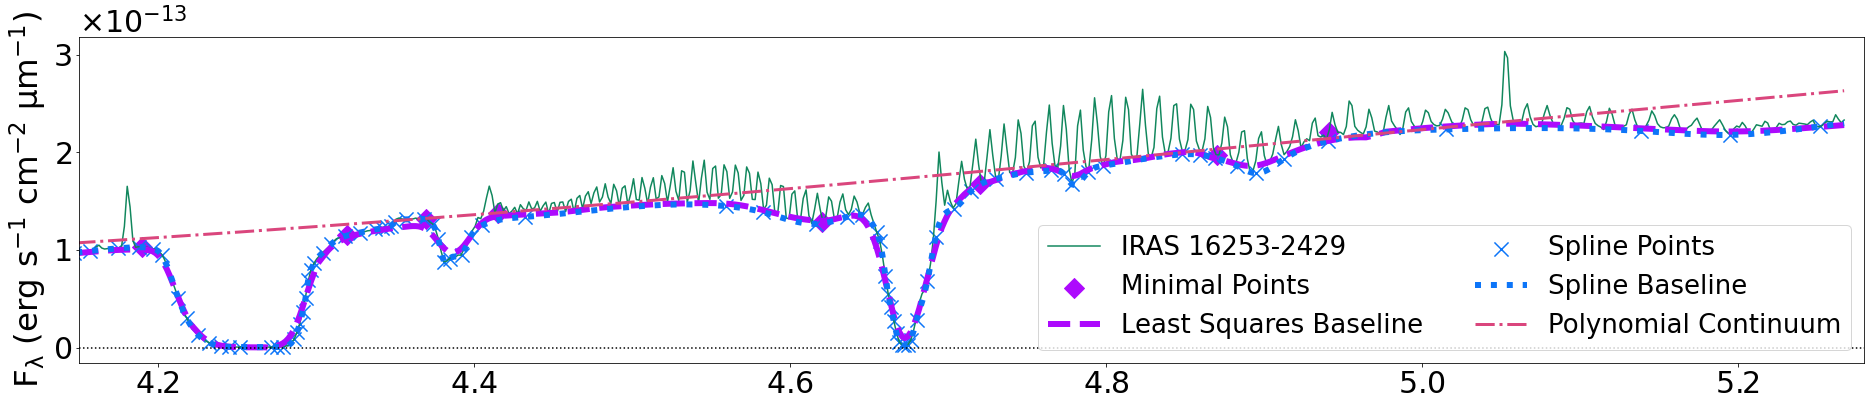

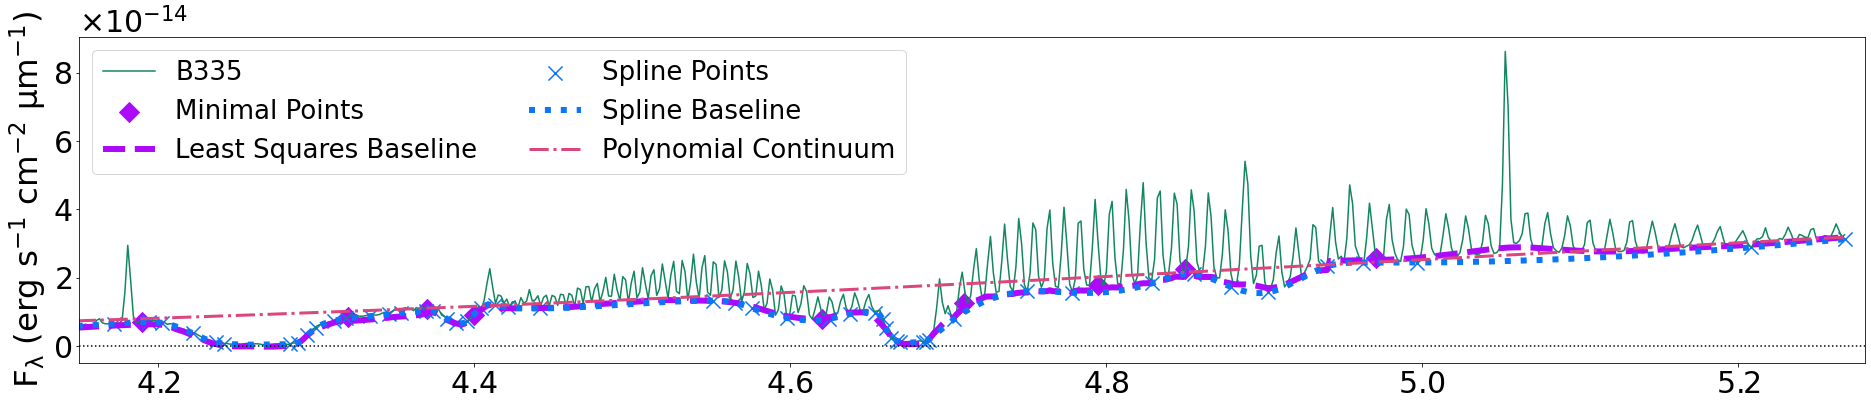

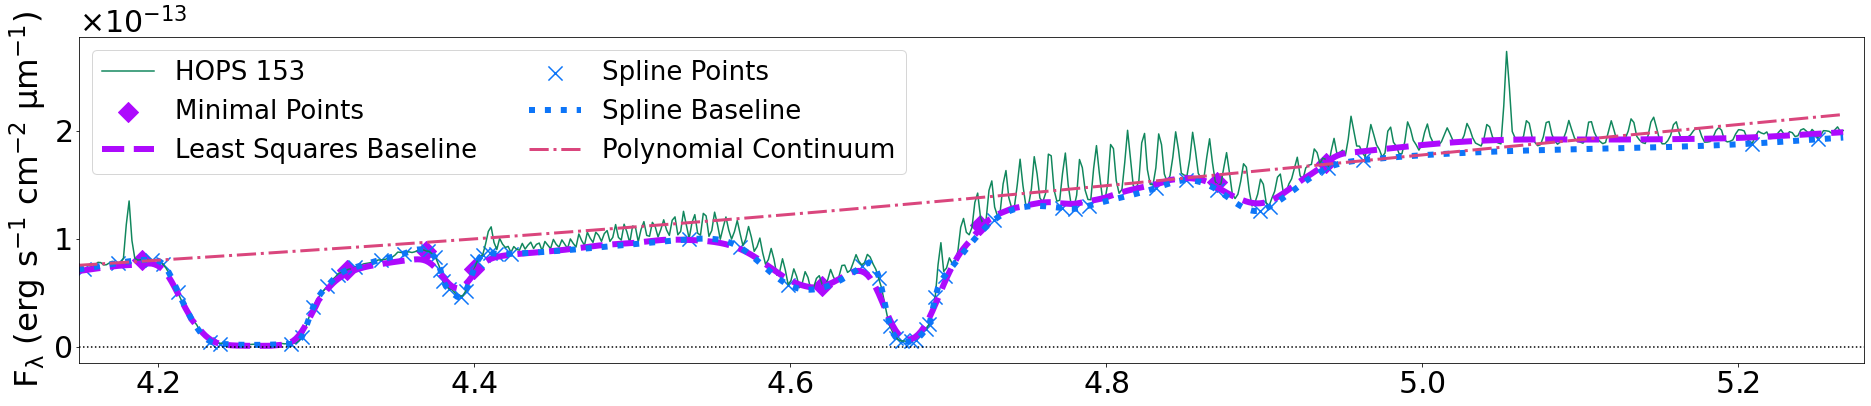

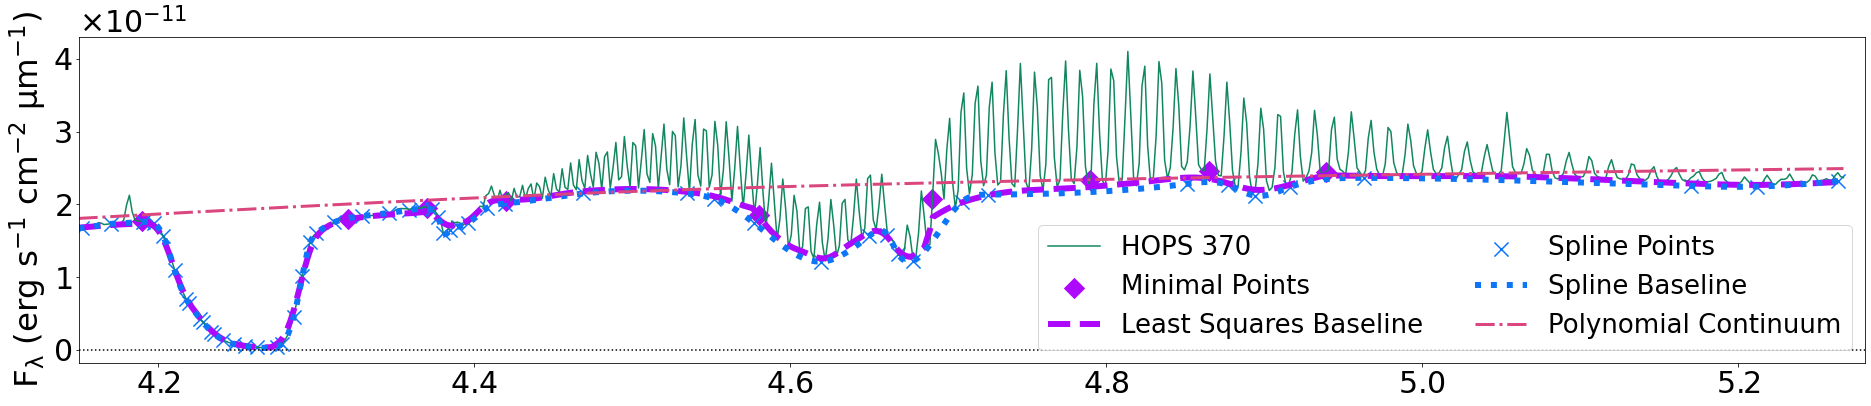

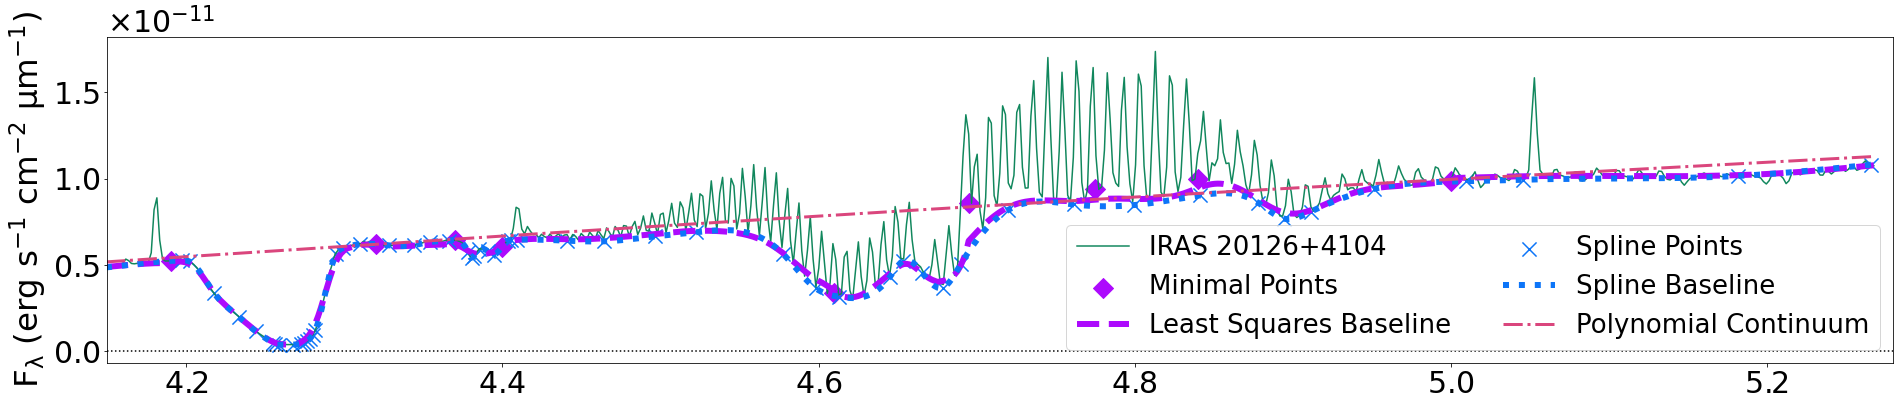

In [64]:
#we read in all the baselines from above...

#all ready to plot!
for i in range(len(protostar_names)):
    fig, ax = plt.subplots(figsize=(32,6)) #setup fig, axes #make a figure to plot various locations on an image

    #correction factor from mistake earlier...need to multiply out the old units and multiply by wavelength to multiply out Hz...
    wave_units_fix = 1.0 / delta_lambda #if you multiply by a cgs bandwidth, you need to multiply 1e-4 comes in because this is cgs, and whatever wavelength we're about to multiply by will be in microns

    print(wave_units_fix / 1e-23 / 3e14 * baseline_wave_list[i] * orig_data_list[i])

    #plotting
    ax.plot(baseline_wave_list[i], wave_units_fix * orig_data_list[i], label=protostar_names[i], color='xkcd:dark sea green')
    ax.scatter(wave_cutoffs_compiled[i], wave_units_fix * baseline_intensity_anchor_list[i], marker='D', label='Minimal Points', color='xkcd:bright violet', s=200)
    ax.plot(baseline_wave_list[i], wave_units_fix * baseline_fit_list[i], linewidth=6, linestyle='--', label='Least Squares Baseline', color='xkcd:bright violet')
    ax.scatter(spline_wave_list[i], wave_units_fix * spline_points_list[i], marker='x', label='Spline Points', color='xkcd:deep sky blue', s=200)
    ax.plot(fityk_spline_centers_list[i], wave_units_fix * fitky_spline_intensity_list[i], linewidth=6, linestyle=':', label='Spline Baseline', color='xkcd:deep sky blue')


    #need to formulate a continuum curve both to estimate transmission and for reference...
    baseline_fitter = Baseline(baseline_wave_list[i], check_finite=False)
    continuum_list = baseline_fitter.pspline_asls(fitky_spline_intensity_list[i], lam=1e3, p=0.999, spline_degree=2)[0]
    ax.plot(baseline_wave_list[i], wave_units_fix * continuum_list, linewidth=3, color='xkcd:darkish pink', linestyle='-.', label='Polynomial Continuum') # or can use xkcd:carnation pink


    #formatting
    ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
    ax.set_xlim(4.15, 5.28)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_ylabel(r'$\rm F_{\lambda} \ (erg \ s^{-1} \ {cm}^{-2} \ {\mu m}^{-1})$', fontsize=32.5)
    # if i == len(protostar_names)-1:
        # ax.set_ylabel(r'$\rm \lambda F_{\lambda} \ (erg \ {s}^{-1} \ {cm}^{-2})$', fontsize=40)

    # Get the text object for order of mag following https://stackoverflow.com/questions/23392833/python-pylab-how-to-alter-the-size-of-the-label-specifying-the-magnitude-of-the
    text = ax.yaxis.get_offset_text()
    text.set_size(30)     # Set the size. # Overkill!
    ax.ticklabel_format(useMathText=True) #following scalar formatters https://matplotlib.org/stable/gallery/ticks/scalarformatter.html

    #set legend last
    ax.legend(loc='best', fontsize=26, ncol=2)
    fig.savefig('CentralSource_CO/Baseline_Systematics_' + protostar_substr[i] + '.pdf') 

# Loop over peak parameter files, extract parameters, and make a table or sheet for each one

In [65]:
#need to grab a table of values for the H2 lines for each object
#initialize a table is harder, but here's an example...instead we should *merge some tables
#to merge some tables, we need to read in all the non-CO lines and then generate a unique line list to merge among our sources...
non_co_lines = pd.read_excel('nonCOLines_CentralSource.xlsx', sheet_name=[0,1,2,3,4]) #note we're using all the sheets and all the cols

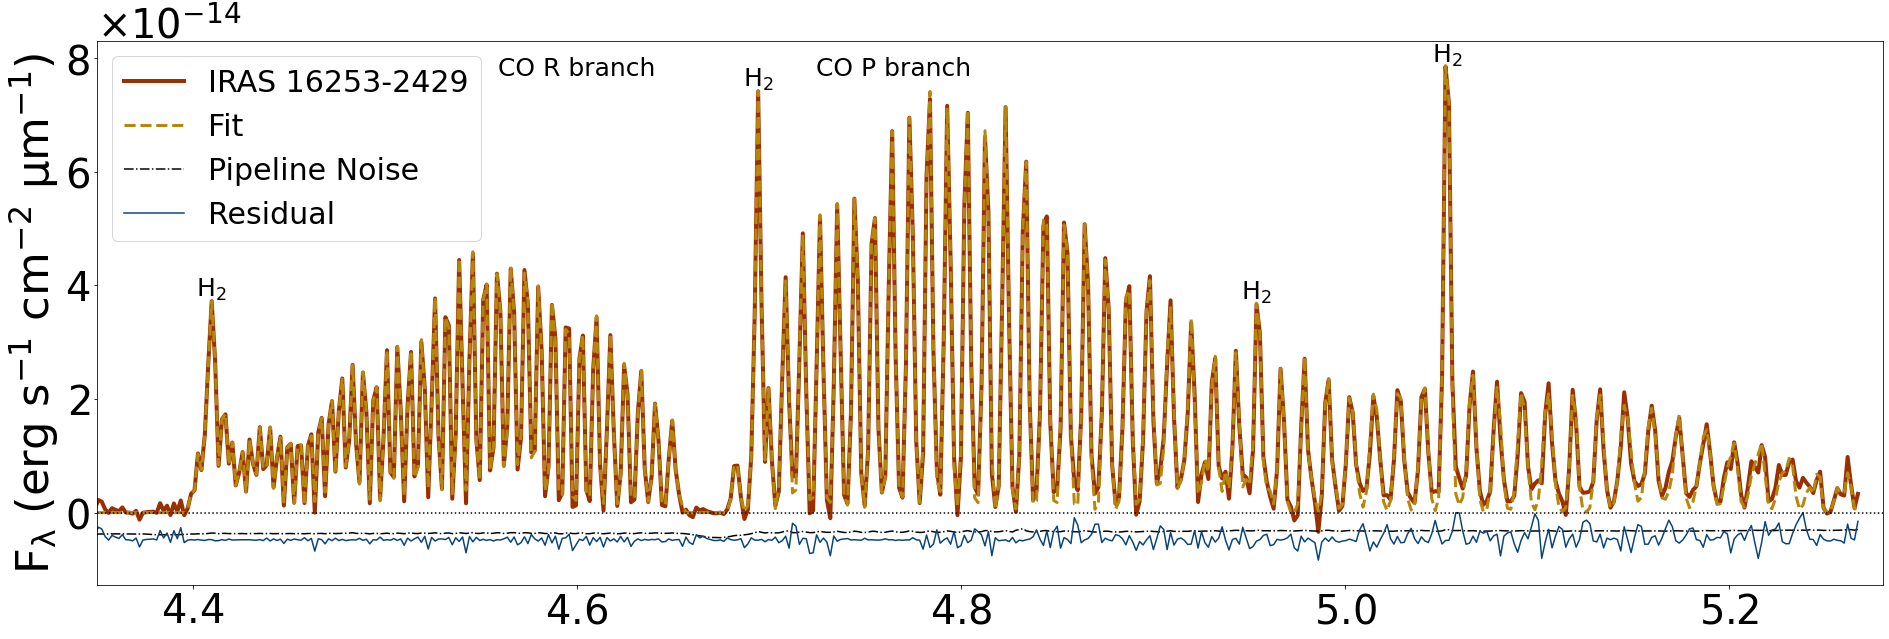

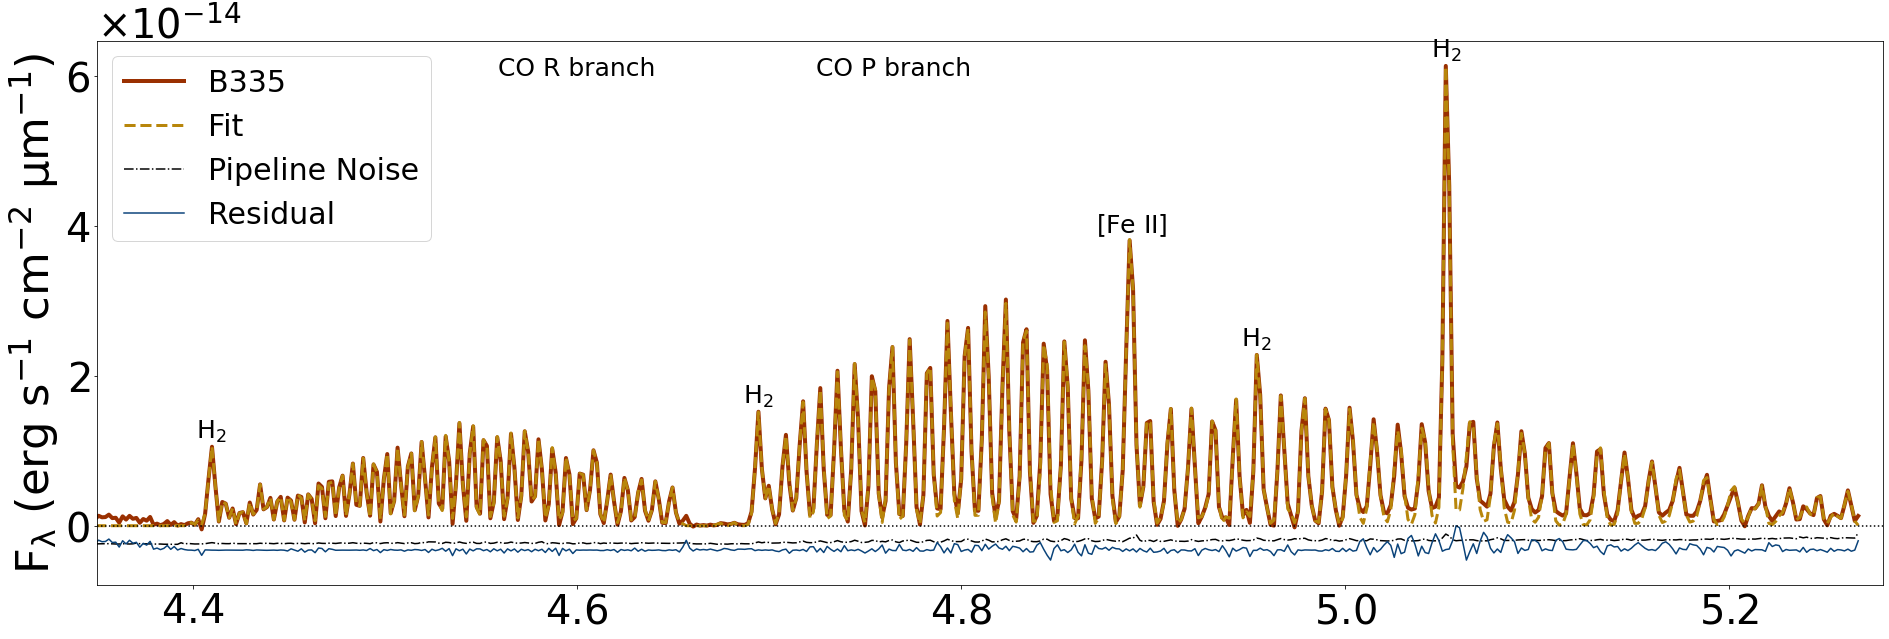

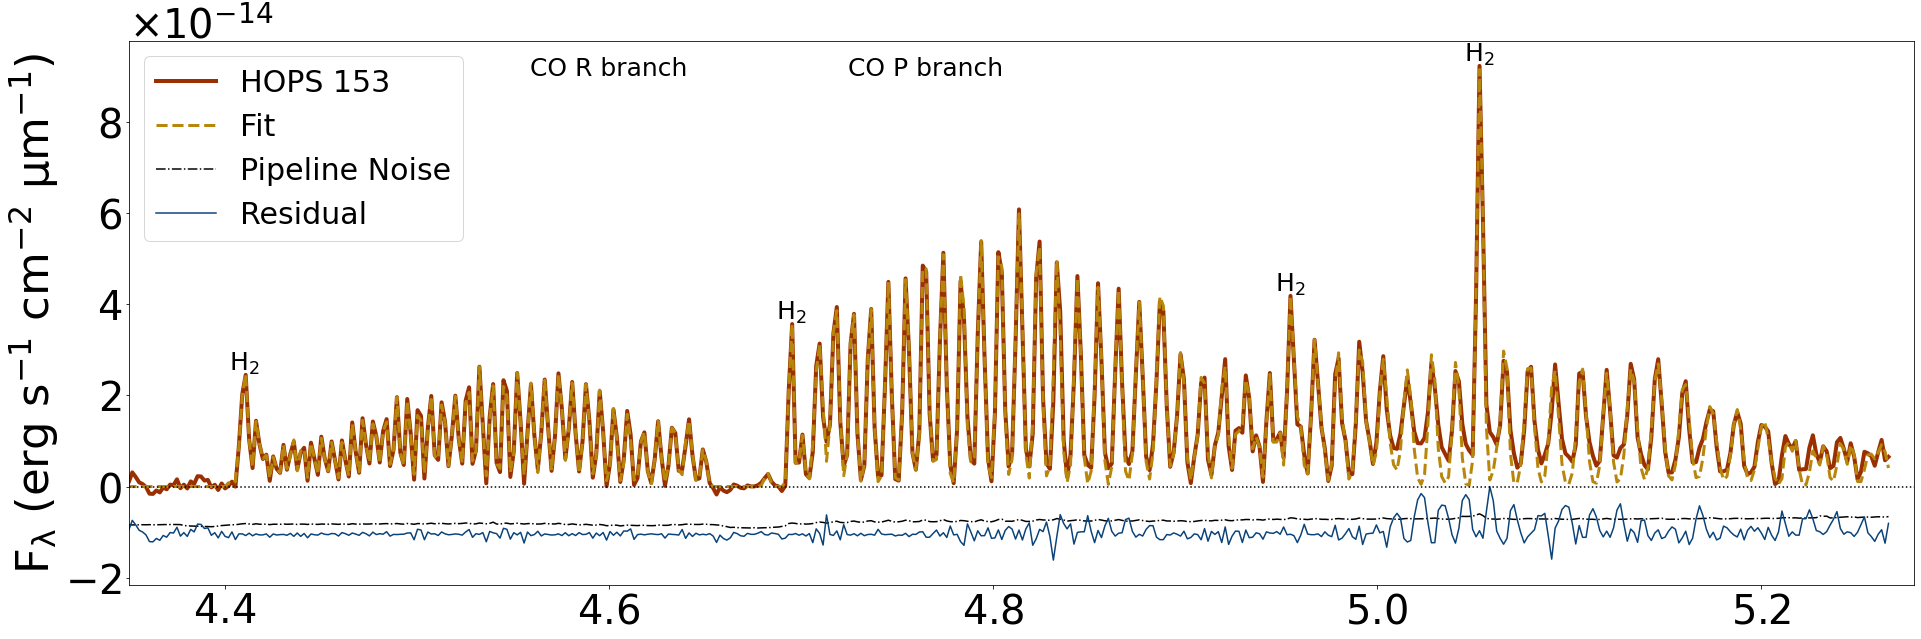

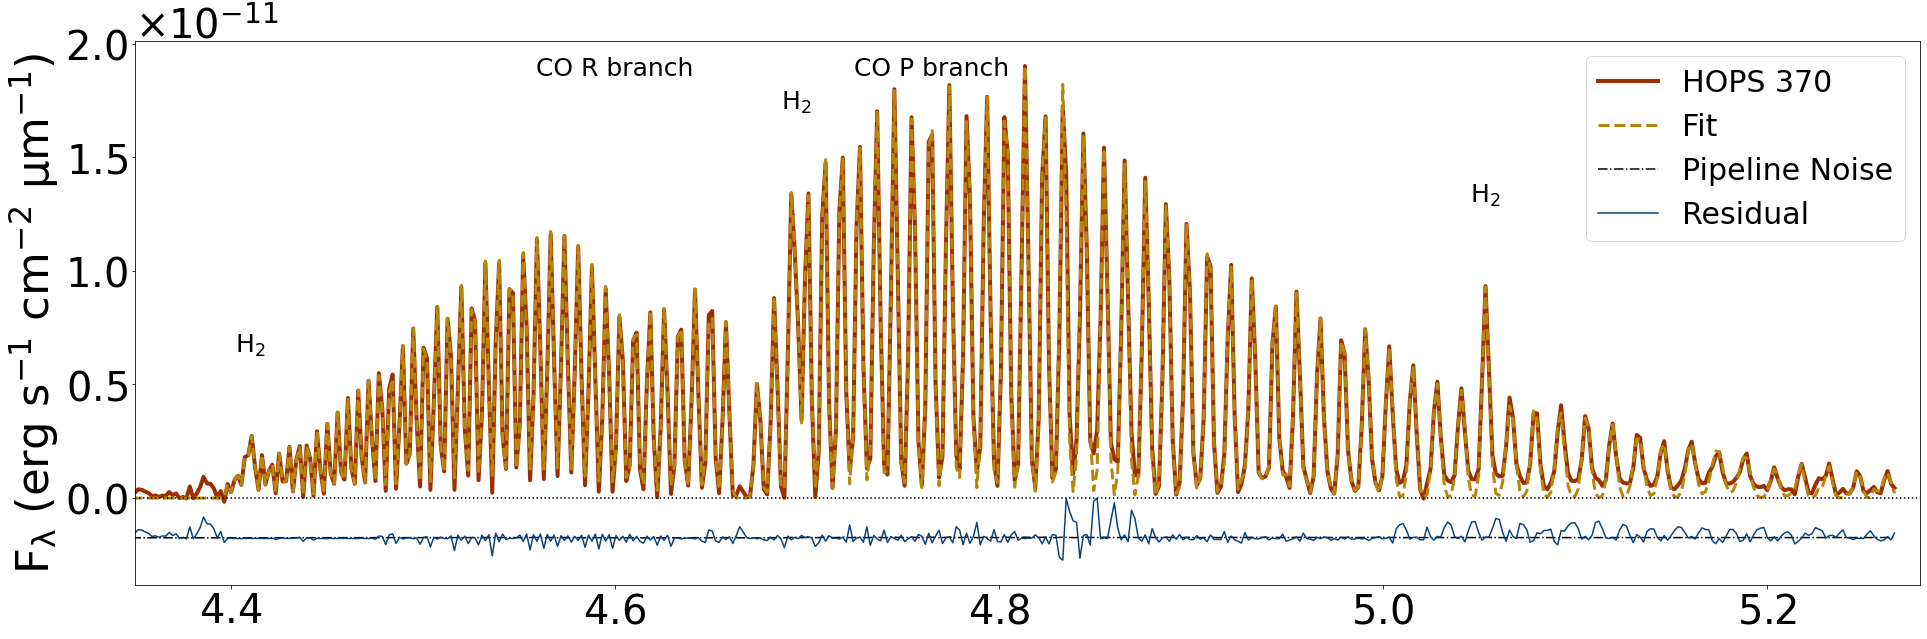

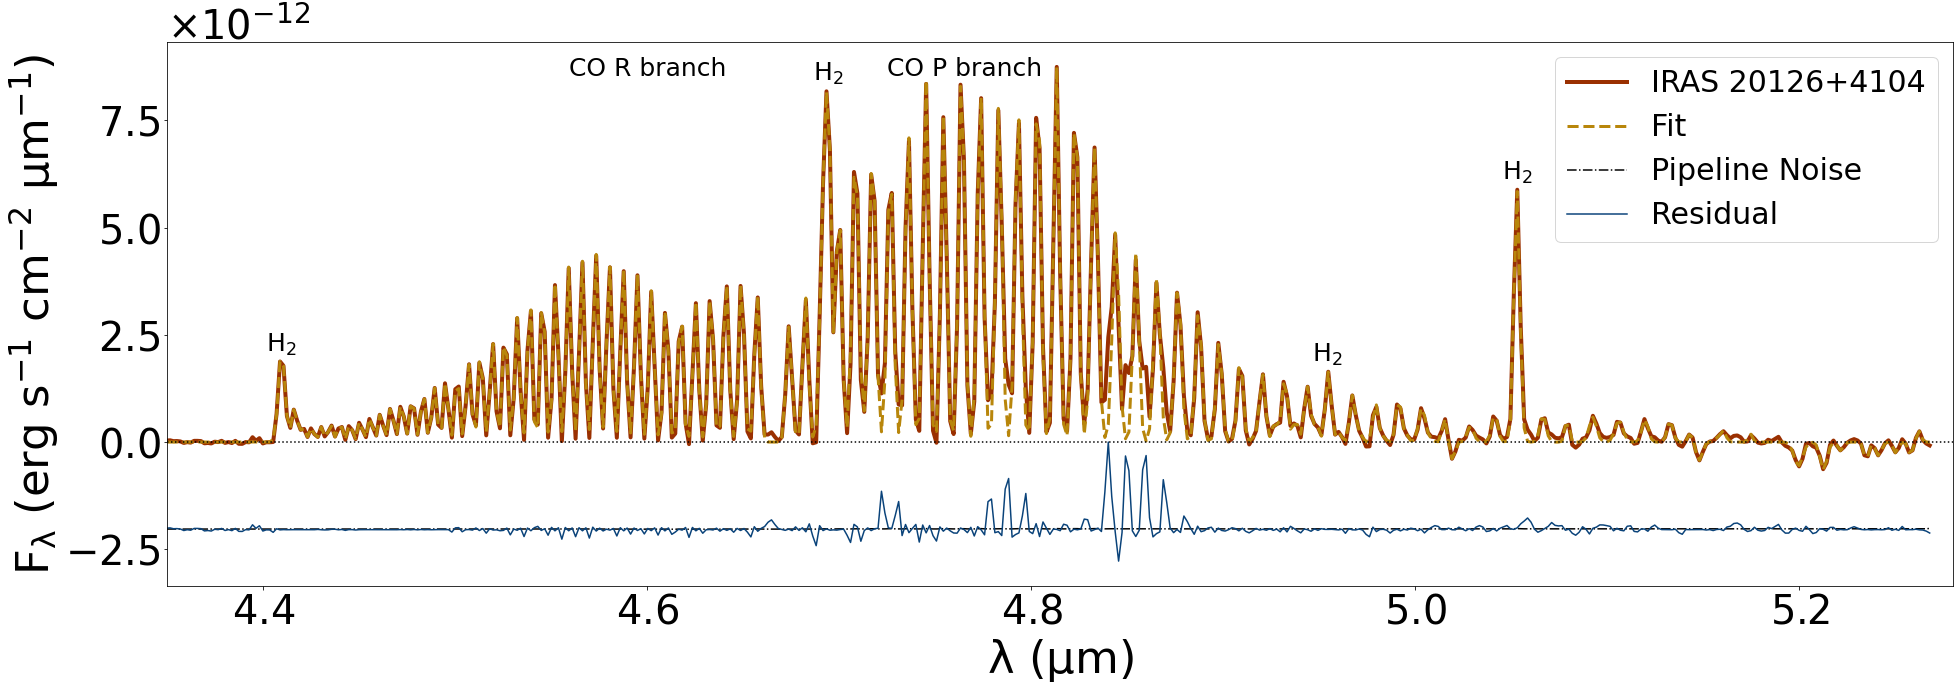

In [66]:
#we read in all the baselines from above...

#need a gaussian and lorentzian function to fit our distributions...tails are still too pronounced
# see https://stackoverflow.com/questions/43498829/fitting-gaussian-and-lorentz-to-data-in-python
# or could use  https://scipy.github.io/devdocs/reference/generated/scipy.stats.ecdf.html
# from scipy.stats import ecdf

#all ready to plot!
for i in range(len(protostar_names)):
    fig, ax = plt.subplots(figsize=(32,10)) #setup fig, axes #make a figure to plot various locations on an image

    #plotting the original data
    wave_units_fix = 1 / delta_lambda #multiply by 1e-4 if you need pure cgs, and whatever wavelength we're about to multiply by will be in microns
    ax.plot(baseline_wave_list[i], wave_units_fix * fityk_intensity_list[i], label=protostar_names[i], linewidth=4, color='xkcd:auburn')
    # ax.plot(baseline_wave_list[i], fityk_intensity_list[i], label=protostar_names[i], color='xkcd:twilight blue')

    #taking lists of fits from earlier, computing gaussians, and creating a total fit
    sigma = wave_fwhm_list[i] / np.sqrt(8.0*np.log(2.0)) #property of gaussians
    sigma_sq = sigma*sigma #pre-calculating sigma^2
    unres_exp = np.array([np.exp(-np.power(baseline_wave_list[i] - wave_centers_list[i][j], 2) / (2 * sigma_sq[j])) for j in range(len(wave_centers_list[i]))])
    total_spectrum = np.einsum('i,il->l', wave_heights_list[i], unres_exp)
    ax.plot(baseline_wave_list[i], wave_units_fix * total_spectrum, label='Fit', linewidth=3, color='darkgoldenrod', alpha=1, linestyle='--') # baseline_wave_list[i] * wave_units_fix * 

    #plotting noise
    residual = fityk_intensity_list[i] - total_spectrum
    ax.plot(baseline_wave_list[i],  wave_units_fix * (err_list[i] - 1.0*np.max(residual)), label='Pipeline Noise', color='xkcd:black', linestyle='-.')
    ax.plot(baseline_wave_list[i],  wave_units_fix * (residual - 1.0*np.max(residual)), label='Residual', color='xkcd:twilight blue')

    #consider to plot v=2 as areas...?
    # can also mark CO high-J lines, v=1 R-branch, v=1 P-branch

    #annotating plot
    flux_increment = np.floor(np.log10(np.max(wave_units_fix * fityk_intensity_list[i])))
    if i == 0 or i == 1:
        flux_multiple = 0.2
    if i == 2:
        flux_multiple = 0.25
    if i == 3 or i == 4:
        flux_multiple = 0.4

    for non_co_ind in range(len(non_co_lines[i]['Species'].values)):
        if non_co_lines[i]['Species'][non_co_ind].find('v=0-0') != -1 or non_co_lines[i]['Species'][non_co_ind].find('v=1-1') != -1 and \
        non_co_ind != 1 or (non_co_lines[i]['Wv_OBS'][non_co_ind] > 4.889 - 0.0001 and non_co_lines[i]['Wv_OBS'][non_co_ind] < 4.889 + 0.0001):
            #grabbing line properties
            nonco_line_wave = non_co_lines[i]['Wv_OBS'][non_co_ind]
            nonco_line_peak_ind = np.argmin(np.abs(baseline_wave_list[i] - nonco_line_wave))
            non_co_peak_flux = np.max(wave_units_fix * fityk_intensity_list[i][nonco_line_peak_ind-5:nonco_line_peak_ind+5])
            #plot text
            if non_co_lines[i]['Species'][non_co_ind].find('v=0-0') != -1 or non_co_lines[i]['Species'][non_co_ind].find('v=1-1') != -1: #H2
                ax.annotate(r'$\rm H_2$', xy = (nonco_line_wave, non_co_peak_flux + flux_multiple*10**(flux_increment)), fontsize=25, color='black', \
                    horizontalalignment='center', verticalalignment='center')
            else: #[FeII]
                ax.annotate(r'$\rm [Fe~II]$', xy = (nonco_line_wave, non_co_peak_flux + flux_multiple*10**(flux_increment)), fontsize=25, color='black', \
                    horizontalalignment='center', verticalalignment='center')
    #marking the CO branches for the "non-cognoscenti" (quoth Neal J Evans II)
    ax.annotate('CO R branch', xy = (4.6, 0.95), fontsize=25, color='black', \
                    horizontalalignment='center', verticalalignment='center', xycoords=('data', 'axes fraction'))
    ax.annotate('CO P branch', xy = (4.765, 0.95), fontsize=25, color='black', \
                    horizontalalignment='center', verticalalignment='center', xycoords=('data', 'axes fraction'))

    #formatting
    ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
    ax.set_xlim(4.35, 5.28)
    ax.tick_params(axis='both', which='major', labelsize=40)
    # ax.set_ylabel(r'$\rm \lambda F_{\lambda} \ (erg \ {cm}^{-2} \ {s}^{-1})$', fontsize=45)
    ax.set_ylabel(r'$\rm F_{\lambda} \ (erg \ {s}^{-1} \ {cm}^{-2} \ {\mu m}^{-1})$', fontsize=45)
    if i == len(protostar_names) - 1:
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=45)

    # Get the text object for order of mag following https://stackoverflow.com/questions/23392833/python-pylab-how-to-alter-the-size-of-the-label-specifying-the-magnitude-of-the
    text = ax.yaxis.get_offset_text()
    text.set_size(40)     # Set the size. # Overkill?
    ax.ticklabel_format(useMathText=True) #following scalar formatters https://matplotlib.org/stable/gallery/ticks/scalarformatter.html

    #set legend last
    if i != 3 and i != 4:
        ax.legend(loc='upper left', fontsize=30)
    elif i == 3 or i == 4:
        ax.legend(loc='upper right', fontsize=30)
    fig.savefig('CentralSource_CO/' + protostar_substr[i] + '_OptimalFit.pdf') #save plot
    

# Check wavelength centers to see shifts and outliers

In [67]:
from scipy.integrate import simpson #we need to integrate the gaussians

0.00010000000000021103
0.00018000000000029104
-0.0003600000000005821
-0.00032999999999994145
0.00011999999999989797
[1e-17, 1e-17, 1e-17, 1e-14, 1e-15]


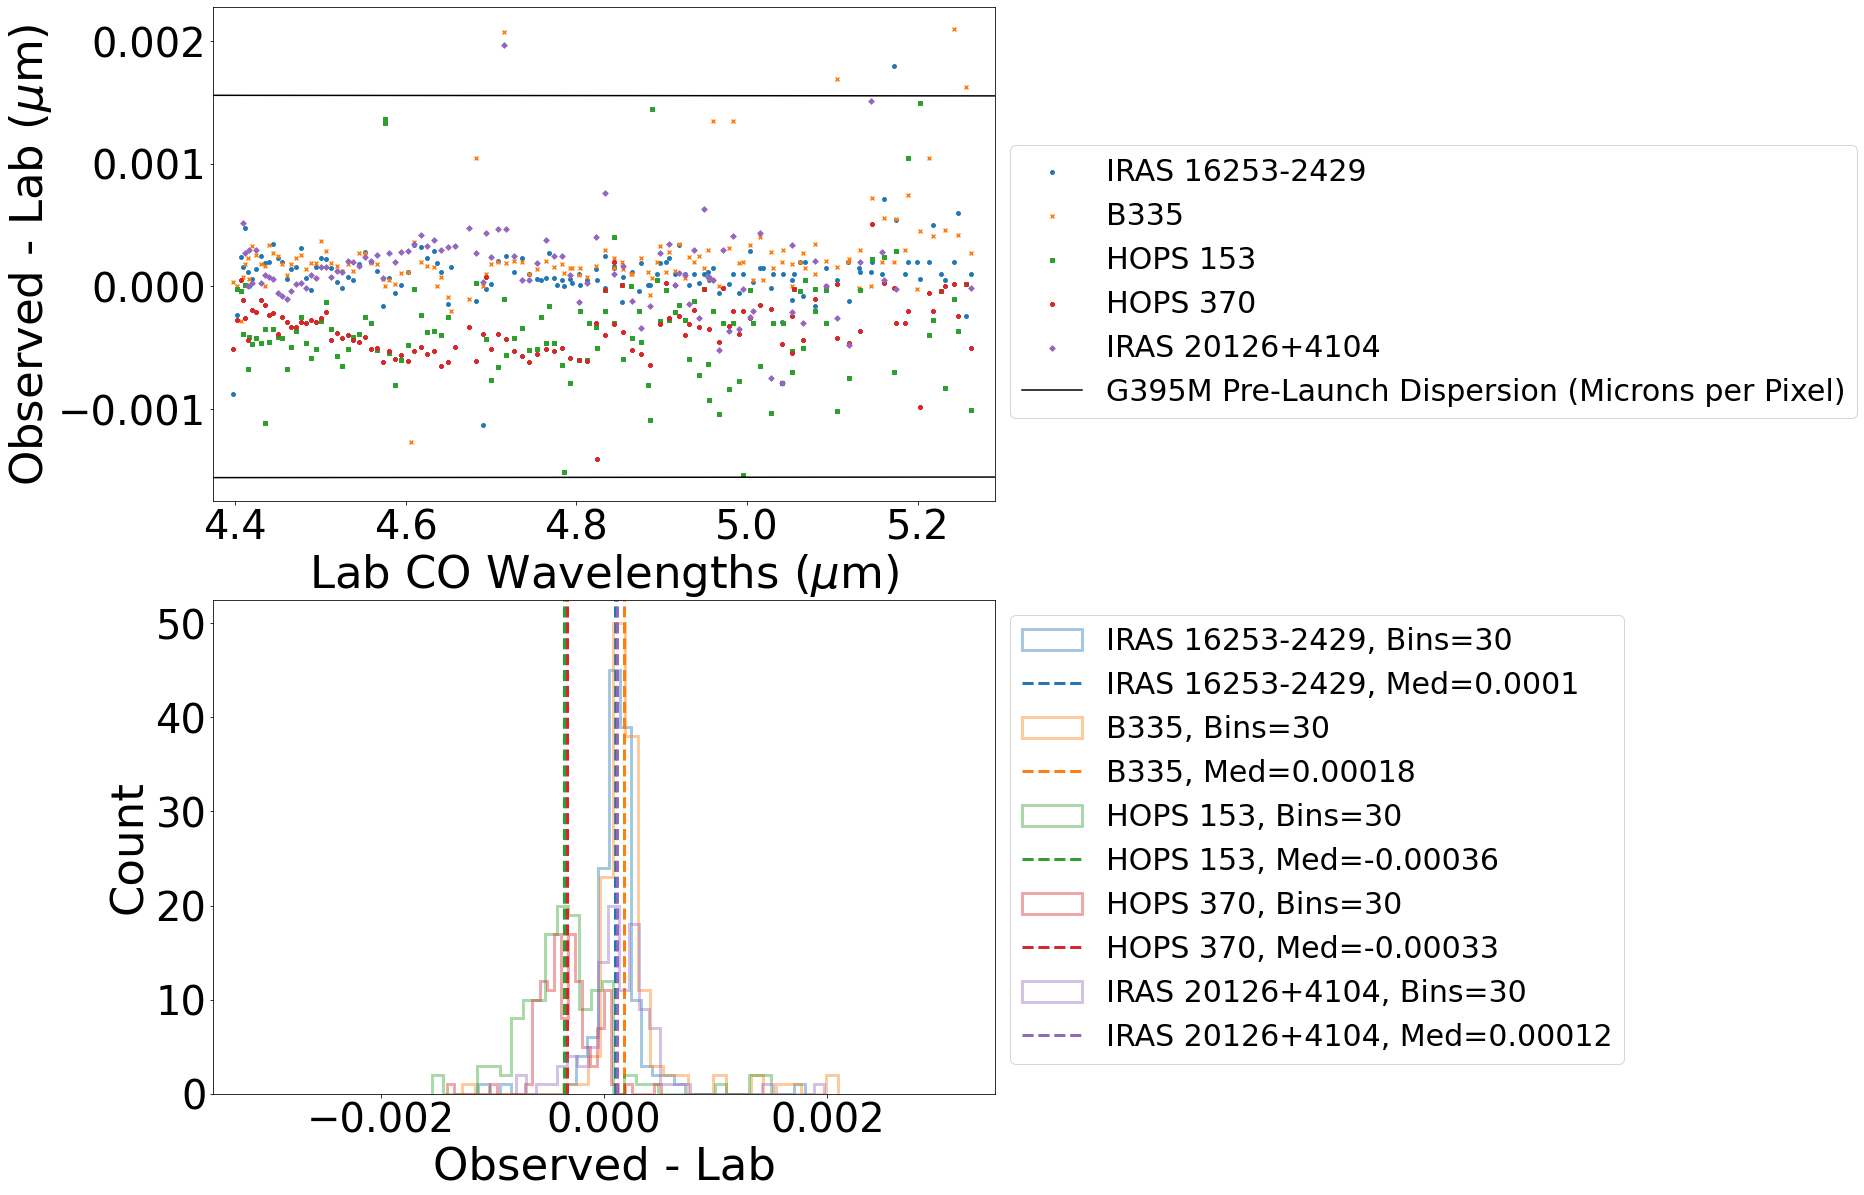

In [68]:
#prepare to create a table of fluxes by reading in all lines and defining our columns
fig, (ax, ax_hist) = plt.subplots(figsize=(14,20), nrows=2)  #defining a plot of systematic wavelength offsets
matplotlib_color_defaults = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
median_wave_offset = [0.000140000000000029, 0.00018999999999991246, -0.00040999999999957737, -0.00033000000000082963, 9.000000000014552e-05] #update regularly!

#reading in from line list for CO
#done first so we can add it to our long table!
# columns = A, sec-1	E_u/k	g_u
table_path = 'Line list 2.1 for python.xlsx'
co_lab_columns = ['Wv, microns', 'A, sec-1', 'E_u/k', 'g_u', 'Transition, v',	'Transition, J']
co_lab_props = pd.read_excel(table_path, sheet_name='CO', usecols=co_lab_columns, nrows=165) #up till the v=2, P-branch lines (we don't fit R-branch here)

#initialize a table is harder, but here's an example...instead we should *merge some tables
#to merge some tables, we need to read in all the non-CO lines and then generate a unique line list to merge among our sources...
non_co_lines = pd.read_excel('nonCOLines_CentralSource.xlsx', sheet_name=[0,1,2,3,4]) #note we're using all the sheets and all the cols

#loop over protostars and extract fit parameters for each CO line
fityk_path = 'fityk_byhand/'
flux_norm_list = [] #list used to contain both the normalization factor and the max of each set of line fluxes
co_forest_obs_list = []
median_diff_list = []
for i in range(len(protostar_names)):
    # extract all lines greater than a cutoff wavelength CO lines between wave_centers list and pandas lab spectra table and a separate handmade line list
    line_wave_mask = wave_centers_list[i] > np.min((np.min(co_lab_props['Wv, microns'].values), np.min(non_co_lines[i]['Wv_OBS'].values)))
    baseline_wave_mask = baseline_wave_list[i] > np.min((np.min(co_lab_props['Wv, microns'].values), np.min(non_co_lines[i]['Wv_OBS'].values)))
    protostar_obs_wave = wave_centers_list[i][line_wave_mask] #first extract relevant wavelengths of peaks
    protostar_baseline_wave = baseline_wave_list[i][baseline_wave_mask]

    #AFTER we get a restriction on the observed wavelengths of interest...
    # always can first generate the fluxes and uncertainties from the peak parameters (center, FWHM) 
    #UNITS the present peak parameters are likely already in terms of lambda * Flambda...that means we need to divide by delta_lambda and multiply by FWHM we measured 
    #this is done IN MICRONS! Because we used c in microns...
    #we also do not need to divide by transmission here because the extinctions (by klaus pontoppidan) we are going to calculate already include them
    line_fluxes = []
    peak_uncert = []
    for k in range(len(protostar_obs_wave)):
        sigma = wave_fwhm_list[i][line_wave_mask][k] / np.sqrt(8.0*np.log(2.0)) #property of gaussians
        sigma_sq = sigma*sigma #pre-calculating sigma^2
        
        #defining a mask to integrate over (+/- 5 * fwhm)
        exp_mask = (protostar_baseline_wave > (protostar_obs_wave[k] - 5.0 * sigma)) * \
                    (protostar_baseline_wave < (protostar_obs_wave[k] + 5.0 * sigma))
        unres_exp = np.exp(-np.power(protostar_baseline_wave[exp_mask] - protostar_obs_wave[k], 2) / (2 * sigma_sq)) #unfortunatley cannot be "factored out" of for loop because of dependence on sigma
        single_line_flux = simpson(wave_heights_list[i][line_wave_mask][k] / delta_lambda * unres_exp, x=protostar_baseline_wave[exp_mask], dx=delta_lambda )
        # single_line_flux = np.einsum('i,il->l', wave_heights_list[i][line_wave_mask][k] / delta_lambda, unres_exp)
        # line_fluxes = wave_heights_list[i][line_wave_mask] / delta_lambda * wave_fwhm_list[i][line_wave_mask]  #in CGS units
        uncert_flux = simpson(err_list[i][np.argmin(np.abs(baseline_wave_list[i] - protostar_obs_wave[k]))] / delta_lambda * unres_exp, x=protostar_baseline_wave[exp_mask], dx=delta_lambda )  #so far this is the uncertainty in the peak value!
        line_fluxes.append(single_line_flux)
        peak_uncert.append(uncert_flux)

    # WITH uncertainties (maybe just grab peak value from the uncertainty cube? then * by fwhm of the line!
    # alt: compute gaussians using that peak and the widths and wavelengths we determined by hand?)
    wave_ind = [np.argmin(np.abs(baseline_wave_list[i] - line_wave)) for line_wave in protostar_obs_wave] #first need to locate index in the original data we're using to find peaks
    # fwhm_uncert =  delta_lambda / 2.0 #this is the uncertainty in the fwhm...a constant?
    # total_uncert = line_fluxes * np.sqrt((peak_uncert / line_fluxes)**2.0 + (fwhm_uncert / wave_fwhm_list[i])**2.0) #since we always multiply these two terms

    #create full string for fluxes...
    #value used to normalize our fluxes and uncertainties
    if i <= 3:
        flux_norm = 10
    elif i == 4:
        flux_norm = 100
    flux_max = 10**round(np.log10(float(np.nanmax(line_fluxes)/flux_norm))) #determine scaling factor
    flux_norm_list.append(flux_max) #store value

    #now loop through those wavelengths
    line_matches = []
    wave_diff_list = [] #for plotting
    wave_matches = [] #for plotting
    for j in range(len(protostar_obs_wave)):
        #grab the appropriate line flux, correct sig figs
        flux_str = '{:0.3f}'.format(np.nan_to_num(line_fluxes[j])/flux_max) + (r'$\pm$') + \
                                        '{:0.3f}'.format(np.nan_to_num(peak_uncert[j])/flux_max) #if using 3 sigma, multiply peak_uncert by (3.*)

        #with fluxes and uncertainties in hand, we can move onto generating wavelengths
        nonco_check = np.isclose(protostar_obs_wave[j], non_co_lines[i]['Wv_OBS'].values, rtol=1e-5, atol=1e-5) #check if values in lists match
        ind_nonco_check = [k for k, x in enumerate(nonco_check) if x]

        if len(ind_nonco_check) >= 1: #if they do... (i.e. is NOT a CO line ...)
            match_orig = non_co_lines[i].iloc[ind_nonco_check].values[0]
            co_lam_str = '{:0.4f}'.format(match_orig[2])
            match = [co_lam_str, match_orig[1], flux_str] #this is the lab wavelength, species in the spreadsheeet..

            #and appending to a list to eventually make our table!
            wave_matches.append(float(match[0]))
            diff = float(match[0]) - protostar_obs_wave[j] #for plotting
            wave_diff_list.append(diff)
            line_matches.append(match)
            
        elif line_fluxes[j] > 0: #if they don't (i.e. is a CO line...)
            match_orig = co_lab_props.iloc[(co_lab_props['Wv, microns'] - protostar_obs_wave[j]).abs().argsort()[:1]].values[0]
            co_lam_str = '{:0.4f}'.format(match_orig[0])
            match = [co_lam_str, ('CO $v = ' + match_orig[4] + '$  ' +  match_orig[5]), flux_str]

            #and appending to a list to eventually make our table!
            wave_matches.append(float(match[0]))
            diff = float(match[0]) - protostar_obs_wave[j] #for plotting
            wave_diff_list.append(diff)
            line_matches.append(match)

    co_forest_obs_list.append(line_matches)

    # TO DO: use pandas to .merge or overlap two tables


    #make plot to check wavelength offsets
    scatter_plot = ax.scatter(np.array(wave_matches), np.array(wave_diff_list), s=15, label=protostar_names[i], marker=marker_list[i])
    ax_hist.hist(np.array(wave_diff_list), bins = 30, alpha=0.4, label=protostar_names[i] + ', Bins=' + str(30), histtype='step', linewidth=3, color=matplotlib_color_defaults[i])
    ax_hist.axvline(np.median(np.array(wave_diff_list)), label=protostar_names[i] + ', Med=' + str(round(np.median(np.array(wave_diff_list)), 5)), \
                    color=matplotlib_color_defaults[i], linestyle='--', linewidth=3)
    print(np.median(np.array(wave_diff_list)))
    median_diff_list.append(np.median(np.array(wave_diff_list)))

#format plot 1
# ax.axhline(y=0.001, linestyle='--', color='black')
# ax.axhline(y=-0.001, linestyle='--', label=r'Spectral Resolution at 5 $\mu$m', color='black')
# ax.plot(baseline_wave_list[3], baseline_wave_list[3]/R/R_factor, label='Pre-Launch Width')
ax.plot(data['WAVELENGTH'],data['dlds']/R_factor, color='black')
ax.plot(data['WAVELENGTH'],-data['dlds']/R_factor, label='G395M Pre-Launch Dispersion (Microns per Pixel)', color='black')
ax.set_xlabel(r'Lab CO Wavelengths ($\mu$m)', fontsize=45)
ax.set_ylabel(r'Observed - Lab ($\mu$m)', fontsize=45)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.legend(loc='best', fontsize=30, bbox_to_anchor=(1,0.75))
ax.set_xlim(4.375, 5.29)

#format histogram
ax_hist.set_xlabel('Observed - Lab', fontsize=45)
ax_hist.set_ylabel('Count', fontsize=45)
ax_hist.tick_params(axis='both', which='major', labelsize=40)
ax_hist.set_xlim(-0.0035, 0.0035)
ax_hist.legend(loc='best', fontsize=30, bbox_to_anchor=(1,1))

# save table
print(flux_norm_list) #update in table!


In [71]:
5.0 * sigma

0.005717273397773822

In [12]:
#with the full stack of data in hand, we can now run through each protostar's sub-table to form a larger table...

#first, initialize the table!
table_cols = ['lambda_0', 'Species', 'IRAS 16253-2429', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126+4104'] #columns for reference
dummy = [] #to be filled in 
for i in range(len(co_forest_obs_list)):
    for j in range(len(co_forest_obs_list[i])):
        dummy.append([co_forest_obs_list[i][j][0],co_forest_obs_list[i][j][1]])
unique_entries = np.unique(dummy, axis=0)
complete_co_data = np.full((len(unique_entries), len(table_cols)), fill_value='--', dtype='<U40')

#can fill in the table now with the unique wavelengths and species
for i in range(len(unique_entries)):
    for j in range(len(unique_entries[i])):
        complete_co_data[i][j] = unique_entries[i][j]

#loop over data to fill in line fluxes!
for i in range(len(co_forest_obs_list)): #looping over each protostars
    for j in range(len(co_forest_obs_list[i])): #looping over each line
        for k in range(len(complete_co_data)): #loop over each line
            line = co_forest_obs_list[i][j]
            if complete_co_data[k][0] == line[0]:
                complete_co_data[k][i+2] = line[2]

#save the table..
#first, format it so each line ends with the appropriate endline character in latex (\\)
latex_formatted_data = []
for i in range(len(complete_co_data)):
    latex_formatted_data.append(complete_co_data[i])
    latex_formatted_data[-1][-1] = latex_formatted_data[-1][-1] + r' \\'
np.savetxt('CentralSource_CO/line_flux.txt', latex_formatted_data, fmt='%s', delimiter=' & ')

# 13CO Estimates

Here we would like an upper limit to the 13CO flux based on the residuals left. You can model it as a Gaussian distribution and see if that works.
But usually the best ways are not to impose a model and not to remove outliers, else biasing or applying too much outside knowledge in case we don't know what's happening.

If you are to not include any data in further analysis, the best ways to do this are to omit the outliers by hand using field expert knowledge (in this case, we know there's some spectral line or spectral rule this feature didn't follow). One nice thing here is a lot of the noisier regions of the spectrum are excluded from the noise because they would have weaker 13CO lines anyway! We're actually primarily driven by the noise in the R-branch and the low-J lines of the P-branch. Potentially also show the data as excluded for good practices. This is DMW's preferred approach, and it's totally fair. Then can proceed to either model the noise as he does, use a KS test, use an unbiased maximum likelihood (ML) estimator, or just simply report some possible ratios.

Another way is the qq plot, or the studentized residual plot or the. Both are graphical methods that enable testing for normality without imposing or assuming a test statistic. You should not use normality testing to reject outliers unless you are 100% sure why and can explain it consistently.

And yet another way is the z score (sigma from the mean), MAD cutoff, or truncated mean. Or the CDf-based nonparametric confidence interval. These can involve point estimations or sigma cuts. They are okay but usually more arbitrary and harder to actually justify for any long-run implications

The best way is probably bootstrapping the residuals with some metrics (KS test, trying to achieve constant variance aka heteroskedastic, etc). You get to first model an underlying normal distribution even though there's outliers or can resample the residuals in a way that's better behaved upon running many numerical experiments.

Primary reference: Textbook by Cowan

For ideas on upper limits, can see:

From UCI dept of stats: https://www.ma.imperial.ac.uk/~dvandyk/Research/11-phystat-ul.pdf 

SLAC: https://www.slac.stanford.edu/econf/C030908/papers/TUAT004.pdf 

By CERN: https://cds.cern.ch/record/452078/files/open-2000-213.pdf 

ApJ Paper: https://iopscience.iop.org/article/10.1088/0004-637X/719/1/900/pdf 

In [13]:
#ranges of values to exclude computed based upon iras 20126 (one of the toughest to fit cases)
#each is then subtracted by the offset from iras 20126 so we can pick any wavelength offset for each object...
residual_exclusions = [
                        4.605510664, #all cases
                        (4.72046 - median_diff_list[-1], 4.77579 - median_diff_list[-1]),
                        # (4.72046 - median_diff_list[-1], 4.73262 - median_diff_list[-1]),
                        (4.77579 - median_diff_list[-1], 4.80065 - median_diff_list[-1]),
                        (4.8300 - median_diff_list[-1], 4.87251 - median_diff_list[-1]),
                        4.980385452 - median_diff_list[-1]  #all cases
                        ]
print(residual_exclusions)


[4.605510664, (4.72034, 4.77567), (4.77567, 4.80053), (4.82988, 4.87239), 4.980265452]


In [14]:
#read in the 13co values
co_isotopologue_lab_columns = ['Column3', 'Column7', 'Column9', 'Column10']
co_isotopologue_lab_data = pd.read_excel('13co.xlsx', usecols=[2, 6, 8, 9]) 
co_isotopologue_lab_data = co_isotopologue_lab_data.loc[co_isotopologue_lab_data[co_isotopologue_lab_columns[1]] == 1] #filter out v > 1-0
co_isotopologue_lab_data[co_isotopologue_lab_columns[0]] = co_isotopologue_lab_data[co_isotopologue_lab_columns[0]].rdiv(1)*1e4 #change wavenumber to wavelength

# now filter the wavelength range using residual exclusions
co_isotopologue_lab_data = co_isotopologue_lab_data.loc[(co_isotopologue_lab_data[co_isotopologue_lab_columns[0]]>residual_exclusions[0])*\
                                                        (co_isotopologue_lab_data[co_isotopologue_lab_columns[0]]<residual_exclusions[-1])]

IRAS 16253-2429 [41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18
 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3] 39


C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2830666582.py:213: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  exp_list_for_weighting = np.array([val[-2] for val in dummy_list])
C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2830666582.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wave_mask_for_weighting = np.array([val[-4] for val in dummy_list])


B335 [41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18
 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2] 40


C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2830666582.py:213: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  exp_list_for_weighting = np.array([val[-2] for val in dummy_list])
C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2830666582.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wave_mask_for_weighting = np.array([val[-4] for val in dummy_list])


HOPS 153 [40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17
 16 15 14 13 12 11  9  8  7  6  5  3] 36


C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2830666582.py:213: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  exp_list_for_weighting = np.array([val[-2] for val in dummy_list])
C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2830666582.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wave_mask_for_weighting = np.array([val[-4] for val in dummy_list])


HOPS 370 [41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18
 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2] 40


C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2830666582.py:213: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  exp_list_for_weighting = np.array([val[-2] for val in dummy_list])
C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2830666582.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wave_mask_for_weighting = np.array([val[-4] for val in dummy_list])


IRAS 20126+4104 [38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15
 14 13 12 11 10  9  8  7  6  5  4  3  2] 37


C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2830666582.py:213: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  exp_list_for_weighting = np.array([val[-2] for val in dummy_list])
C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2830666582.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wave_mask_for_weighting = np.array([val[-4] for val in dummy_list])


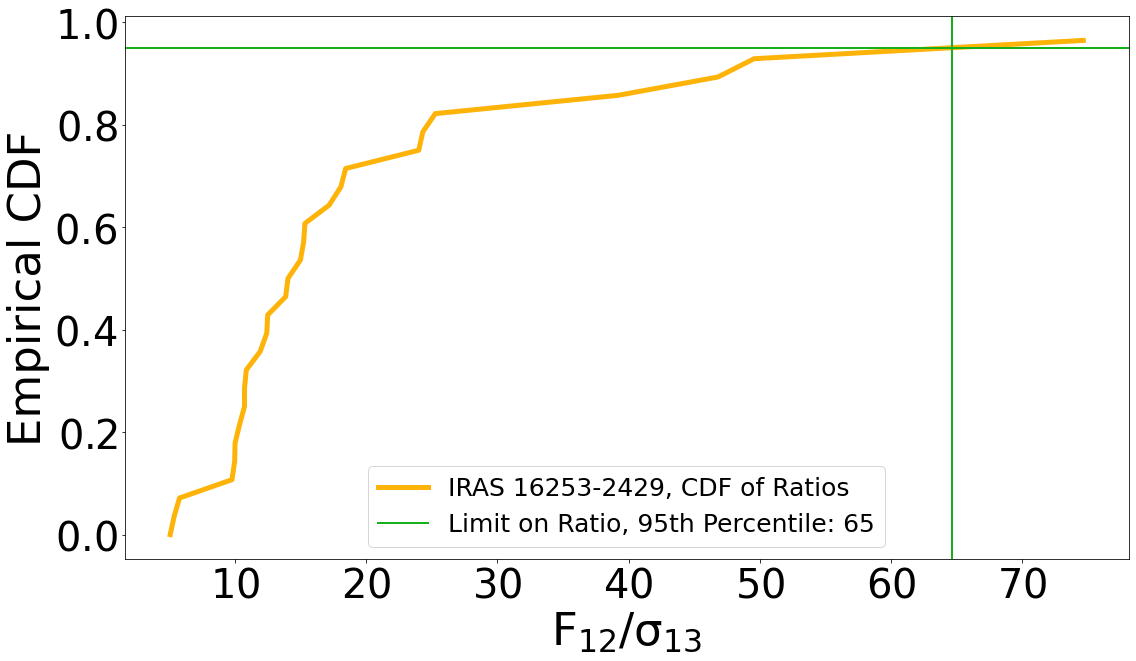

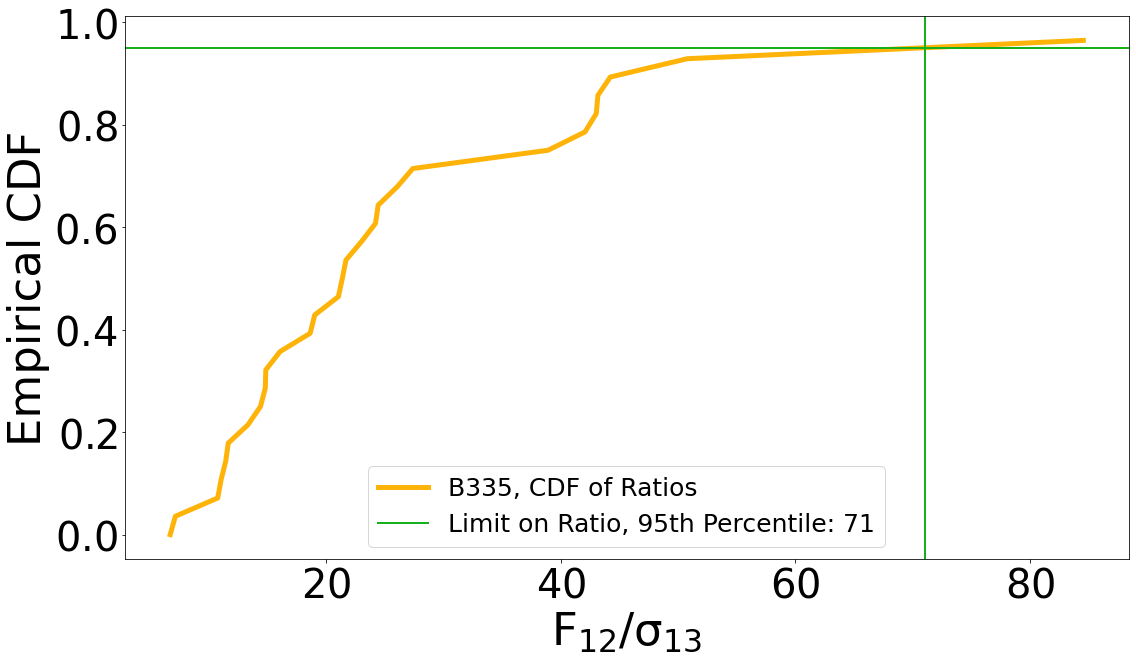

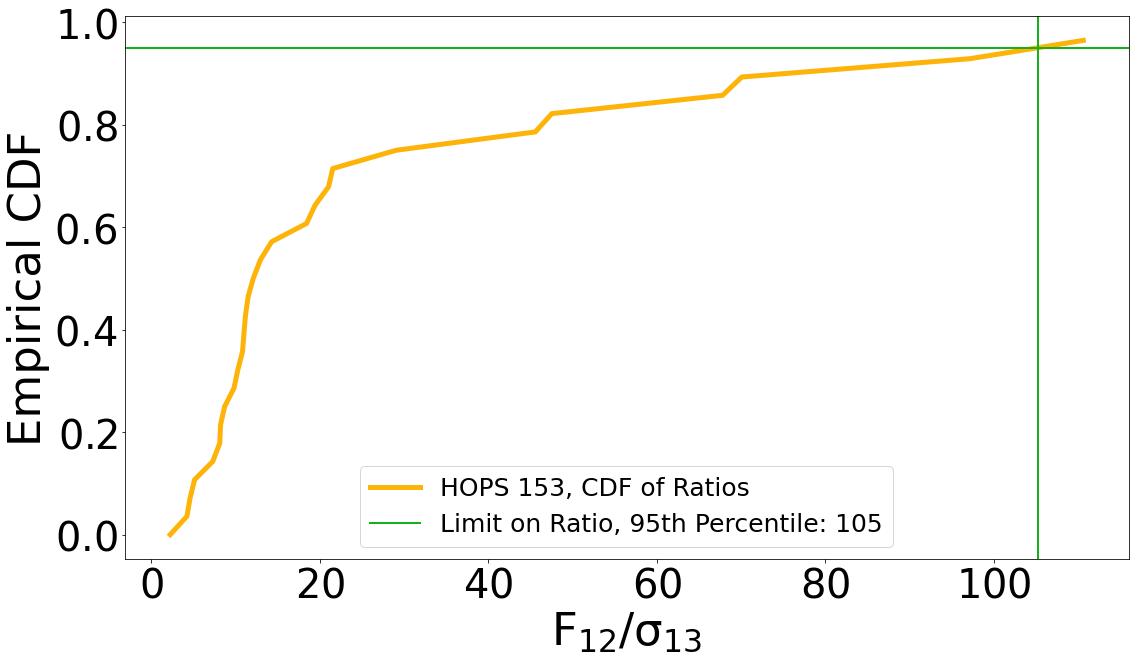

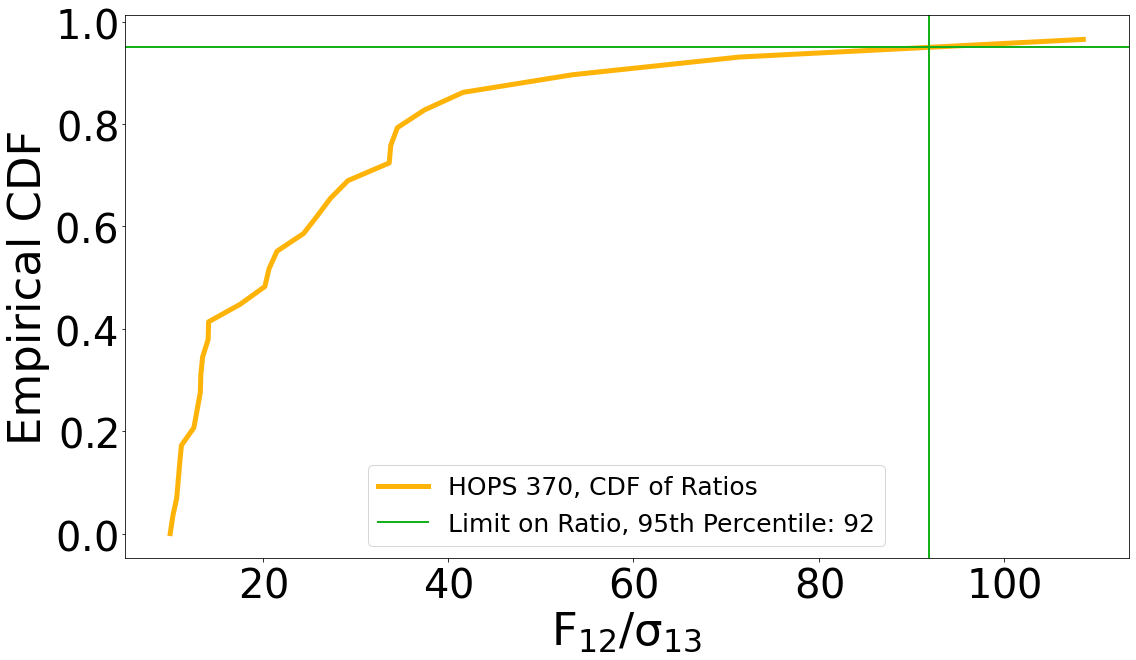

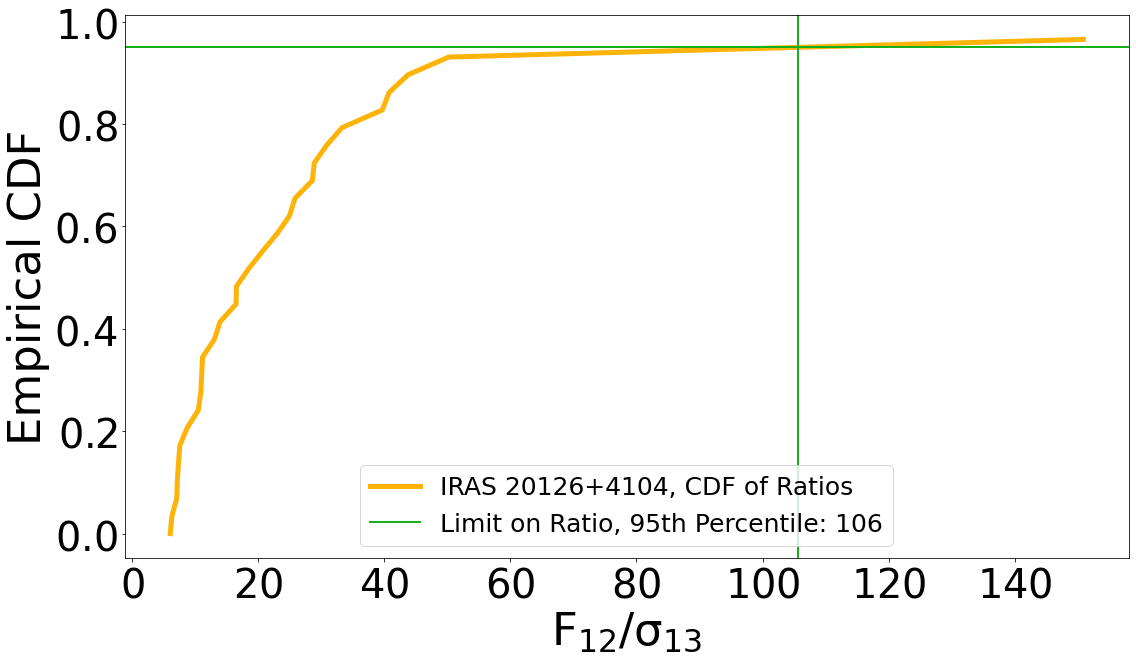

In [15]:
# from scipy.stats import ecdf
# from scipy.stats import kstest
# kstest(np.random.normal(0,1,1000), np.random.normal(0,0.9,1000))

#need a gaussian and lorentzian function to fit our distributions...tails are still too pronounced
# see https://stackoverflow.com/questions/43498829/fitting-gaussian-and-lorentz-to-data-in-python
# or could use  https://scipy.github.io/devdocs/reference/generated/scipy.stats.ecdf.html

#all ready to plot!...~statistically~
percentile_cut = 95 #percent!
co_isotope_flux_center = []
co_isotope_flux_upper = []
co_isotope_flux_lower = []
co_isotopologue_ratio_list = []

#the 1e-4 comes in because this is cgs, and whatever wavelength we're about to multiply by will be in microns
wave_units_fix = 1 / delta_lambda 

for i in range(len(protostar_names)):
        #taking lists of fits from earlier, computing gaussians, and creating a total fit
        sigma = wave_fwhm_list[i] / np.sqrt(8.0*np.log(2.0)) #property of gaussians
        sigma_sq = sigma*sigma #pre-calculating sigma^2
        unres_exp = np.array([np.exp(-np.power(baseline_wave_list[i] - wave_centers_list[i][j], 2) / (2 * sigma_sq[j])) for j in range(len(wave_centers_list[i]))])
        total_spectrum = np.einsum('i,il->l', wave_heights_list[i], unres_exp)
        residual = fityk_intensity_list[i] - total_spectrum #residuals from observed - fit

        #plotting statistical distributions to check if residuals are gaussian
        # fig, (ax_cdf, ax_ratios, ax_resid) = plt.subplots(figsize=(25,35), nrows=3) #setup fig, axes #make a figure to plot various locations on an image; ax_hist
        fig, (ax_cdf) = plt.subplots(figsize=(18,10), nrows=1) #setup fig, axes #make a figure to plot various locations on an image; ax_hist

        #setup a mask that we can iterate over...could write it as a z score, but here we select specific wavelength ranges graphically
        #here we take the residual exclusions from above and add on the median offset for our wavelength calibrations for each object
        #the first and second cases represent extrema at either edge of the residuals (<4.35 microns and >5.0 micorns respectively)
        # always keep the first case (<4.35) in any mask if doing CO
        mask = (baseline_wave_list[i] > residual_exclusions[0] + median_diff_list[i]) * \
                (
                ((baseline_wave_list[i] < residual_exclusions[1][0] + median_diff_list[i]) | (baseline_wave_list[i] > residual_exclusions[1][1] + median_diff_list[i])) * \
                ((baseline_wave_list[i] < residual_exclusions[2][0] + median_diff_list[i]) | (baseline_wave_list[i] > residual_exclusions[2][1] + median_diff_list[i])) * \
                ((baseline_wave_list[i] < residual_exclusions[3][0] + median_diff_list[i]) | (baseline_wave_list[i] > residual_exclusions[3][1] + median_diff_list[i]))
                ) * \
                (baseline_wave_list[i] < residual_exclusions[-1] + median_diff_list[i])
        wave_masked = baseline_wave_list[i][mask]
        resid_flux_masked = baseline_wave_list[i][mask] * wave_units_fix * residual[mask]
        RMS_masked = baseline_wave_list[i][mask] * wave_units_fix * err_list[i][mask]

        #also setup the opposite so we can mark what we ended up rejection
        #unfortunately can't totally do the ~mask (negation) trick since we have one condition we want to preserve...could write to variables, but might as well make sure this is all correct
        mask_opposite =  ((baseline_wave_list[i] < residual_exclusions[0] + median_diff_list[i]) * (baseline_wave_list[i] > residual_exclusions[0] + median_diff_list[i] - 0.05)) | \
                        ((baseline_wave_list[i] > residual_exclusions[1][0] + median_diff_list[i]) * (baseline_wave_list[i] < residual_exclusions[1][1] + median_diff_list[i])) | \
                        ((baseline_wave_list[i] > residual_exclusions[2][0] + median_diff_list[i]) * (baseline_wave_list[i] < residual_exclusions[2][1] + median_diff_list[i])) | \
                        ((baseline_wave_list[i] > residual_exclusions[3][0] + median_diff_list[i]) * (baseline_wave_list[i] < residual_exclusions[3][1] + median_diff_list[i])) | \
                        (baseline_wave_list[i] > residual_exclusions[-1] + median_diff_list[i])
        wave_masked_opposite = baseline_wave_list[i][mask_opposite]
        resid_flux_masked_opposite = baseline_wave_list[i][mask_opposite] * wave_units_fix * residual[mask_opposite]
        RMS_masked_opposite = baseline_wave_list[i][mask_opposite] * wave_units_fix * err_list[i][mask_opposite]
                        

        #the processed residuals
        # ax_resid.scatter(wave_masked, resid_flux_masked , color='xkcd:azul', \
        #                 label=protostar_names[i] + ' Residual Flux', s=200) # (>'+ str(resid_cutoff) +'x RMS masked)')
        # ax_resid.scatter(wave_masked_opposite, resid_flux_masked_opposite, color='black', marker='x', s=50, label='Residuals Excluded (Systematic Effects)')
        # ax_resid.errorbar(wave_masked, resid_flux_masked, yerr=RMS_masked, linestyle='', ecolor = 'xkcd:gray', color='xkcd:azul')

        #next we need to try to nab 13CO fluxes, which can only be done by knowing some info about the 12CO fluxes as follows...
        #for each protostar, check for different v states
        co_j_list = []
        co_r_lam_list = []
        co_p_lam_list = []
        co_r_flux_list = []
        co_p_flux_list = []
        co_r_unc_list = []
        co_p_unc_list = []

        p_match = [o for o in latex_formatted_data if ('P' in o[1] and 'v = 1 - 0' in o[1])] #check for P state and v state, will need as we go...
        #for each v state, go through the R branch lines to find the associated P branch lines
        for idx in range(len(latex_formatted_data)): #inefficient as we don't have to search through the whole list, but being basic for now
                #we need to check which line we're handling
                co_r_str = latex_formatted_data[idx][1] #the string for a given line

                #only continue on certain conditions for R
                if co_r_str.find('R') >= 0 and co_r_str.find('v = 1 - 0') >= 0:

                        #useful CO values derived just from R-branch lines of a certain v state
                        co_r_num = int(latex_formatted_data[idx][1][-2:]) #which r-branch line?
                        co_j = co_r_num - 1 #which j then? delta_J in R branch is 1, so we need to subtract 1 to get J!

                        #search for the associated P-branch line
                        for p in p_match:
                                #need these to check if a valid comparison can be made
                                co_p_num = int(p[1][-2:]) #which r-branch line?
                                co_r_flux_unc_str = latex_formatted_data[idx][i+2].split(' \\\\')[0]
                                co_p_flux_unc_str = p[i+2].split(' \\\\')[0]

                                #if we have a match then...store values!
                                if co_p_num == co_j - 1 and p[1].find('v = 1 - 0') >= 0 and co_r_flux_unc_str != '--' and co_p_flux_unc_str != '--':
                                        #getting fluxes and uncertainties in R branch
                                        co_r_lam = float(latex_formatted_data[i][0])

                                        co_r_flux = float(co_r_flux_unc_str.split('$')[0]) * flux_norm_list[i]
                                        co_r_unc = float(co_r_flux_unc_str.split('$')[-1]) * flux_norm_list[i]
                                        #same in p branch
                                        co_p_lam = float(p[0])
                                        co_p_flux = float(co_p_flux_unc_str.split('$')[0]) * flux_norm_list[i]
                                        co_p_unc = float(co_p_flux_unc_str.split('$')[-1]) * flux_norm_list[i]

                                        #separate flux data into lists
                                        co_j_list.append(co_j)
                                        co_r_lam_list.append(co_r_lam)
                                        co_p_lam_list.append(co_p_lam)
                                        co_r_flux_list.append(co_r_flux)
                                        co_p_flux_list.append(co_p_flux)
                                        co_r_unc_list.append(co_r_unc)
                                        co_p_unc_list.append(co_p_unc)

        #now can use lists! before resetting for next protostar and/or v-state; first make sure arrays are numpy...
        co_j_list = np.array(co_j_list)
        co_r_lam_list = np.array(co_r_lam_list)
        co_p_lam_list = np.array(co_p_lam_list)
        co_r_flux_list = np.array(co_r_flux_list)
        co_p_flux_list = np.array(co_p_flux_list)
        co_r_unc_list = np.array(co_r_unc_list)
        co_p_unc_list = np.array(co_p_unc_list)

        print(protostar_names[i], co_j_list, len(co_j_list))

        #this part with the flux calculation is the only difference between the two cases of sources in the IPA sample
        #for the case of residuals, now we want to plot a model spectrum and compute the proper ratio upper limit to 13CO (lower limit to the 12CO/13CO ratio)
        #based on the confidence intervals, we can tell if range of the confidence interval > the central value, then it is RMS dominated
        dummy_list = []
        for idx in range(len(co_isotopologue_lab_data[co_isotopologue_lab_columns[0]].values)):
                upperlim_wave = co_isotopologue_lab_data[co_isotopologue_lab_columns[0]].values[idx] #13co wavelength
                upperlim_wave_corrected = upperlim_wave + median_wave_offset[i] #we need to compare more to the physical data, so a correction needed

                #next do match for 12co fluxes and widths depending on branch to isiolate their properties...
                co_isotopologue_j = co_isotopologue_lab_data[co_isotopologue_lab_columns[3]].values[idx] #13co j
                if co_isotopologue_j >= 5: #filter out any low-J outliers
                        if co_isotopologue_lab_data[co_isotopologue_lab_columns[2]].values[idx] == 'R':
                                co_bright_j_match = np.argmin(np.abs(co_j_list - (co_isotopologue_j)+1))
                                co_bright_flux_match = co_r_flux_list[co_bright_j_match] #grab 12co flux match, R -> J + 1 
                                co_bright_wave_match = co_r_lam_list[co_bright_j_match]
                        elif co_isotopologue_lab_data[co_isotopologue_lab_columns[2]].values[idx] == 'P':
                                co_bright_j_match = np.argmin(np.abs(co_j_list - (co_isotopologue_j)-1))
                                co_bright_flux_match = co_p_flux_list[co_bright_j_match] #grab 12co flux match, P -> J - 1
                                co_bright_wave_match = co_p_lam_list[co_bright_j_match]

                        #need fwhm the same either way
                        fwhm_match = wave_fwhm_list[i][np.argmin(np.abs(wave_centers_list[i] - co_bright_wave_match))] #fwhm 
                        sigma = fwhm_match / np.sqrt(8.0*np.log(2.0)) #property of gaussians
                        sigma_sq = sigma*sigma #pre-calculating sigma^2

                        #defining a mask to integrate over (+/- 5 * fwhm)
                        exp_mask = (wave_masked > (upperlim_wave_corrected - 5.0 * sigma)) * (wave_masked < (upperlim_wave_corrected + 5.0 * sigma))

                        # if (lower_percentile_bar + (x_plus[cdf_percentile_plus]/percentile_exponentiated - x_center[cdf_percentile]/percentile_exponentiated)) > cdf_percent_rounded/percentile_exponentiated:
                        #         #check wavelengths for appropriate unc from RMS or residuals to draw from for 13co, then locate matching j flux
                        # if upperlim_wave < 4.65748585: #the wavelength of R0
                        #         upperlim_r_check = np.argmin(np.abs(co_r_lam_list - upperlim_wave)) #match wavelength for index of 12co where there is 13co
                        #         #in such cases (the low-mass stars) we may simply take the associated RMS error bar at a line as the 13CO upper limit of another line...
                        #         co_isotoplogue_flux_weighted = co_r_flux_list[co_bright_j_match] / np.max(co_r_flux_list) * \
                        #                 np.sqrt(np.std(resid_flux_masked[exp_mask], ddof=1)**2 + np.std(RMS_masked[exp_mask], ddof=1)**2) #grab uncertainty
                        # elif upperlim_wave > 4.65748585: #for the p-branch...
                        #         upperlim_p_check = np.argmin(np.abs(co_p_lam_list - upperlim_wave)) #match wavelength for index of 12co where there is 13co
                        #         #in such cases (the low-mass stars) we may simply take the associated RMS error bar at a line as the 13CO upper limit of another line...
                        #         co_isotoplogue_flux_weighted = co_p_flux_list[co_bright_j_match] / np.max(co_p_flux_list) * \
                        #                 np.sqrt(np.std(resid_flux_masked[exp_mask], ddof=1)**2 + np.std(RMS_masked[exp_mask], ddof=1)**2) #grab uncertainty
                        #         #only append if the ratio of this one is *more* than the last (so the 13CO is constantly diminishing) for INCREASING J, 
                        #         # the reverse for DECREASING J
                        #         if idx == 0 or (co_isotopologue_j > dummy_list[-1][4] and co_bright_flux_match / co_isotoplogue_flux_upperlim > dummy_list[-1][2]) \
                        #                 or (co_isotopologue_j < dummy_list[-1][4] and co_bright_flux_match / co_isotoplogue_flux_upperlim < dummy_list[-1][2]):
                        #                 dummy_list.append((upperlim_wave, co_isotoplogue_flux_upperlim, co_bright_flux_match / co_isotoplogue_flux_upperlim, fwhm_match, co_isotopologue_j))

                        # else:        #for the high-mass stars, instead we have to focus on the residuals                       
                        if len(wave_masked[exp_mask]) > 3:
                                avg_noise_power = np.sqrt(np.std(resid_flux_masked[exp_mask], ddof=1)**2 + np.std(RMS_masked[exp_mask], ddof=1)**2)
                                unres_exp = np.exp(-np.power(wave_masked[exp_mask] - upperlim_wave_corrected, 2) / (2 * sigma_sq)) #unfortunatley cannot be "factored out" of for loop because of dependence on sigma
                                co_isotoplogue_flux_upperlim = simpson(avg_noise_power * unres_exp, x=wave_masked[exp_mask]) #note the residual units have already been fixed, no need for dividing by delta_lambda or even filling in dx

                                # weighted_flux_upperlim = simpson(co_isotoplogue_flux_weighted * unres_exp, x=wave_masked[exp_mask])

                                #only append if the ratio of this one is *more* than the last (so the 13CO is constantly diminishing) for INCREASING J, 
                                # the reverse for DECREASING J
                                # if idx == 0 or (co_isotopologue_j > dummy_list[-1][4] and co_bright_flux_match / co_isotoplogue_flux_upperlim > dummy_list[-1][2]) \
                                #         or (co_isotopologue_j < dummy_list[-1][4] and co_bright_flux_match / co_isotoplogue_flux_upperlim < dummy_list[-1][2]):
                                dummy_list.append((upperlim_wave_corrected, co_isotoplogue_flux_upperlim, co_bright_flux_match, \
                                                co_bright_flux_match / co_isotoplogue_flux_upperlim, wave_masked[exp_mask], fwhm_match, unres_exp, co_isotopologue_j))

                                #if plotting...
                                #defining a mask to integrate over (+/- 5 * fwhm)
                                unres_exp = np.exp(-np.power(wave_masked[exp_mask] - upperlim_wave_corrected, 2) / (2 * sigma_sq)) #unfortunatley cannot be "factored out" of for loop because of dependence on sigma
                                single_line_flux_set = avg_noise_power * unres_exp #or can multiply the exponential by the peak value; co_isotoplogue_flux_upperlim / fwhm_match
                                # weighted_line_set = co_isotoplogue_flux_weighted * unres_exp #or can multiply the exponential by the peak value; co_isotoplogue_flux_upperlim / fwhm_match

                                # if idx != 0:
                                #         ax_resid.plot(wave_masked[exp_mask], single_line_flux_set, color='xkcd:amber', lw=3)
                                # elif idx == 0:
                                #         ax_resid.plot(wave_masked[exp_mask], single_line_flux_set, color='xkcd:amber', label=r'$\rm Unweighted\ {}^{13}CO \ Profiles$', lw=3)
                
        #add a complete list for a single protostar - done!
        co_isotopologue_ratio_list.append(dummy_list) 

        # rms_resid = 0
        # co_isotopologue_mask = (baseline_wave_list[i] > (upperlim_wave - 5.0 * 0.00342529802)) * (baseline_wave_list[i] < (upperlim_wave + 5.0 * 0.00342529802))
        # for rms in residual[co_isotopologue_mask]:
        #         rms_resid += rms**2.0
        # rms_resid = np.sqrt(rms_resid / len(residual[co_isotopologue_mask]))
        # print(protostar_names[i], 'RMS of residuals: ', rms_resid)


        #extracting list of just the ratios
        j_list_for_weighting = np.array([val[-1] for val in dummy_list])
        wave_center_list_for_weighting = np.array([val[0] for val in dummy_list])
        fwhm_list_for_weighting = np.array([val[-3] for val in dummy_list])
        exp_list_for_weighting = np.array([val[-2] for val in dummy_list])
        wave_mask_for_weighting = np.array([val[-4] for val in dummy_list])
        ratio_only_list = np.array([val[3] for val in dummy_list])
        noise_fluxes = np.array([val[1] for val in dummy_list])
        bright_co_fluxes = np.array([val[2] for val in dummy_list])

        #devise the weighted average distribution for a "real physical possibility"
        # weighted_average = np.max(bright_co_fluxes)**2.0 /  (np.mean(bright_co_fluxes) * np.mean(3.0*noise_fluxes))

        weighted_line_set = []
        weighted_ratio_set = []
        for isotopologue in range(len(j_list_for_weighting)):
                #compute the total flux in a line
                # if wave_center_list_for_weighting[isotopologue] < 4.65748585: #the wavelength of R0
                #         co_isotoplogue_flux_weighted = bright_co_fluxes[isotopologue] / np.max(bright_co_fluxes) / weighted_average * np.max(3.0*noise_fluxes) #grab uncertainty (peak)
                # elif wave_center_list_for_weighting[isotopologue] > 4.65748585: #for the p-branch...
                #         co_isotoplogue_flux_weighted = bright_co_fluxes[isotopologue] / np.max(bright_co_fluxes) / weighted_average * np.max(3.0*noise_fluxes) #grab uncertainty (peak)
                # weighted_ratio_set.append(bright_co_fluxes[isotopologue] / co_isotoplogue_flux_weighted)
                co_isotoplogue_flux_weighted = 3.0 * np.sum(bright_co_fluxes) / np.sum(noise_fluxes) # np.mean(bright_co_fluxes) / np.mean(noise_fluxes)
                weighted_ratio_set.append(co_isotoplogue_flux_weighted)

                #now compute the weighted line profile to plot
                #I take it that the flux/fwhm is about correct for the peak...
                weighted_profile = 1.0 / fwhm_list_for_weighting[isotopologue] * exp_list_for_weighting[isotopologue] * (bright_co_fluxes[isotopologue] / co_isotoplogue_flux_weighted)
                weighted_line_set.append(weighted_profile)

                #plot profiles
                # if isotopologue != 0:
                #         ax_resid.plot(wave_mask_for_weighting[isotopologue], weighted_profile, color='xkcd:deep pink', linestyle='-', lw=3)
                # elif isotopologue == 0:
                #         ax_resid.plot(wave_mask_for_weighting[isotopologue], weighted_profile, color='xkcd:deep pink', linestyle='--', label=r'$\rm Scaled\ {}^{12}CO\ Spectrum$', lw=3)
        #convert to numpy array for help
        weighted_ratio_set = np.array(weighted_ratio_set)

        #plotting the *spectrum* (function of wavelength) of the different ratio possibilities...
        # ax_ratios.scatter(wave_center_list_for_weighting, ratio_only_list, color='xkcd:amber', label=protostar_names[i] + ', Unweighted')
        # ax_ratios.plot(wave_center_list_for_weighting, weighted_ratio_set, color='xkcd:deep pink', linestyle='--', label=r'$\rm Scaled\ {}^{12}CO\ Spectrum$', lw=3)


        #for case of ecdfs
        x_center = np.sort(ratio_only_list) #the constant variance case
        y_center = np.arange(len(x_center))/float(len(x_center)) 
        ax_cdf.plot(x_center, y_center, linewidth=5, color='xkcd:amber', label=protostar_names[i] + ', CDF of Ratios') #central value
        ax_cdf.axhline(percentile_cut/100.0, color='xkcd:green', linewidth=2) #mark 95% level, needs to be done before going to marking the unmodeled noise
        cdf_percentile = np.argmin(np.abs(y_center - percentile_cut/100.0))
        cdf_percentile_exponent = round(np.log10(x_center[cdf_percentile]))
        percentile_exponentiated = 10**(cdf_percentile_exponent)
        cdf_percent_rounded = round(x_center[cdf_percentile] / percentile_exponentiated, 4) * percentile_exponentiated

        x_center_weighted = np.sort(weighted_ratio_set) #the constant variance case
        y_center_weighted = np.arange(len(x_center_weighted))/float(len(x_center_weighted)) 
        # ax_cdf.axhline(percentile_cut/100.0, color='xkcd:black', linestyle='--', linewidth=2) #mark 95% level, needs to be done before going to marking the unmodeled noise
        cdf_percentile_weighted = np.argmin(np.abs(y_center_weighted - percentile_cut/100.0))
        cdf_percentile_exponent_weighted = round(np.log10(x_center_weighted[cdf_percentile_weighted]))
        percentile_exponentiated_weighted = 10**(cdf_percentile_exponent_weighted)
        cdf_percent_rounded_weighted = round(x_center_weighted[cdf_percentile_weighted] / percentile_exponentiated_weighted, 4) * percentile_exponentiated_weighted
        # ax_cdf.plot(x_center_weighted, y_center_weighted, linewidth=5, linestyle='--', color='xkcd:deep pink', label=protostar_names[i] + r'$\rm , \ Scaled\ {}^{12}CO: \ $' +  str(round(x_center_weighted[cdf_percentile_weighted]))) #central value

        # x_plus = np.sort(ratio_only_list + RMS_masked) #with RMS up
        # y_plus = np.arange(len(x_plus))/float(len(x_plus)) 
        # ax_cdf.plot(x_plus, y_plus, linewidth=5, color='xkcd:gray', label=r'$\rm Residuals \pm Pipeline \ Uncertainty$', linestyle='--') #upper bound
        # cdf_percentile_plus = np.argmin(np.abs(y_plus - percentile_cut/100.0))
        # cdf_percentile_exponent_plus = round(np.log10(x_plus[cdf_percentile_plus]))
        # percentile_exponentiated_plus = 10**(cdf_percentile_exponent_plus)
        # cdf_percent_rounded_plus = round(x_plus[cdf_percentile_plus] / percentile_exponentiated_plus, 4) * percentile_exponentiated_plus

        # x_minus = np.sort(ratio_only_list - RMS_masked) #with RMS down
        # y_minus = np.arange(len(x_minus))/float(len(x_minus)) 
        # ax_cdf.plot(x_minus, y_minus, linewidth=5, color='xkcd:gray', linestyle='--') #lower bound
        # cdf_percentile_minus = np.argmin(np.abs(y_minus - percentile_cut/100.0))
        # cdf_percentile_exponent_minus = round(np.log10(np.abs(x_minus[cdf_percentile_minus])))
        # percentile_exponentiated_minus = 10**(cdf_percentile_exponent_minus)
        # cdf_percent_rounded_minus = round(x_minus[cdf_percentile_minus] / percentile_exponentiated_minus, 4) * percentile_exponentiated_minus


        #finally formulate the proper string and round it and plot it !
        # if x_minus[cdf_percentile_minus] < 0:
        #         lower_percentile_bar = np.abs(x_minus[cdf_percentile_minus]/percentile_exponentiated - x_center[cdf_percentile]/percentile_exponentiated)
        # else:
        #         lower_percentile_bar = np.abs(x_center[cdf_percentile]/percentile_exponentiated - np.abs(x_minus[cdf_percentile_minus])/percentile_exponentiated)
        # cdf_percent_rounded_str = '(' + str(round(x_center[cdf_percentile] / percentile_exponentiated,2)) + \
        #                                 r'$_{-%.2f}^{+%.2f} ) \times$' %   (lower_percentile_bar, (x_plus[cdf_percentile_plus]/percentile_exponentiated - x_center[cdf_percentile]/percentile_exponentiated) ) + \
        #                                 r'$10^{%.0f}$' % cdf_percentile_exponent
        # cdf_percent_rounded_str = '(' + str(round(x_center[cdf_percentile] / percentile_exponentiated,2)) + \
        #                                 r'$10^{%.0f}$' % cdf_percentile_exponent + ')'
        cdf_interp = np.interp(0.95, y_center, x_center)
        ax_cdf.axvline(cdf_interp, label='Limit on Ratio, ' + str(percentile_cut) + 'th Percentile: ' + str(round(cdf_interp)), color='xkcd:green', linewidth=2)
        co_isotope_flux_center.append(x_center[cdf_percentile]) #and save these values for later!
        # co_isotope_flux_upper.append(cdf_percent_rounded_plus)
        # co_isotope_flux_lower.append(cdf_percent_rounded_minus)
        # 
        # ax_cdf.axvline(x_center_weighted[cdf_percentile_weighted], label=r'$\rm Scaled\ {}^{12}CO, Weighted \ Average: \ $' + str(round(x_center_weighted[cdf_percentile_weighted])), linestyle='--', color='xkcd:black', linewidth=2) # + cdf_percent_rounded_str

        # x = np.sort(resid_flux_masked_opposite) #the opposite case
        # y = np.arange(len(x))/float(len(x))
        # ax_cdf.plot(x, y, linewidth=5, color='black', label='Noise Not Modeled', linestyle=':')

        #for the case of histograms
        # ax_hist.hist(ratio_only_list, bins='auto', color='xkcd:dark gold', label=protostar_names[i] + ' (Not Weighted)', lw=3)     #for case of histograms, central value
        # ax_hist.axvline(x_center[cdf_percentile], label=str(percentile_cut) + 'nd Percentile (Not Weighted)', color='xkcd:green', linewidth=2) #ddo with the first case...  + cdf_percent_rounded_str
       # ax_hist.hist(weighted_ratio_set, bins='auto', color='xkcd:deep pink', label=r'$\rm Scaled\ {}^{12}CO\ Spectrum$', lw=3)     #for case of histograms, central value
        # ax_hist.axvline(weighted_average, label=r'$\rm Weighted\ Average$', linestyle='--', color='xkcd:black', linewidth=2)


        #formatting
        # ax_resid.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=45)
        # ax_resid.set_ylabel(r'$\rm Residual \ F_{\lambda} \ (erg \ {s}^{-1} \ {cm}^{-2} \ {\mu m}^{-1})$', fontsize=45)
        # ax_ratios.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=45)
        # ax_ratios.set_ylabel(r'$\rm F_{12}/\sigma_{13}$', fontsize=45)
        ax_cdf.set_xlabel(r'$\rm F_{12}/\sigma_{13}$', fontsize=45)
        ax_cdf.set_ylabel('Empirical CDF', fontsize=45)
        # ax_resid.tick_params(axis='both', which='major', labelsize=40)
        # ax_resid.legend(loc='best', fontsize=25)
        # ax_ratios.tick_params(axis='both', which='major', labelsize=40)
        # ax_ratios.legend(loc='best', fontsize=25)
        ax_cdf.tick_params(axis='both', which='major', labelsize=40)
        ax_cdf.legend(loc='lower center', fontsize=25)
        # ax_hist.set_xlabel(r'$\rm F_{12}(J)/F_{13}(J)$', fontsize=40)
        # ax_hist.set_ylabel('Count', fontsize=40)
        # ax_hist.tick_params(axis='both', which='major', labelsize=40)
        # ax_hist.legend(loc='best', fontsize=27)

        # Get the text object for order of mag following https://stackoverflow.com/questions/23392833/python-pylab-how-to-alter-the-size-of-the-label-specifying-the-magnitude-of-the
        # text = ax_resid.yaxis.get_offset_text()
        # text.set_size(40)     # Set the size. # Overkill?
        # ax_resid.ticklabel_format(useMathText=True) #following scalar formatters https://matplotlib.org/stable/gallery/ticks/scalarformatter.html
        text = ax_cdf.xaxis.get_offset_text()
        text.set_size(40)     # Set the size. # Overkill?
        ax_cdf.ticklabel_format(useMathText=True) #following scalar formatters https://matplotlib.org/stable/gallery/ticks/scalarformatter.html
        # text = ax_hist.xaxis.get_offset_text()
        # text.set_size(40)     # Set the size. # Overkill?
        # ax_hist.ticklabel_format(useMathText=True) #following scalar formatters https://matplotlib.org/stable/gallery/ticks/scalarformatter.html

        #log scale for the distributions
        # ax_cdf.set_xscale('log')
        # ax_hist.set_xscale('log')


        #save
        fig.savefig('CentralSource_CO/' + protostar_substr[i] + '_Stats.pdf', bbox_inches='tight')

In [16]:
#need lambertw to solve for tau
from scipy.special import lambertw
abund_ratio = 67 #update this

#can do by hand (see comments below)

#13co properties
co_isotopologue_width = 0.00342529802
co_isotopologue_wave = 4.907811716 #P15
#if taking the median and assuming the underlying distribution is actually an exponential aka laplace dist
# The Poisson distribution gives the probabilities for the number of events taking place in the given time period 
# whereas the exponential distribution gives the probabilities for times between the events. Both of these concern events occurring randomly 
# in time at a constant average rate, λ .
# co_isotopologue_byhist = [2.385415368108453e-19, 1.5930235421672742e-19, 4.511659298810542e-19, 6.733148168858336e-18, 3.0390949501169022e-18] #1x RMS
# co_isotopologue_byhist = [ 1.3119784524596492e-18, 5.57558239758546e-19, 1.5790807545836897e-18, 4.847866681578002e-16, 2.1881483640841697e-16] #1x sigma of dist of residuals
co_isotopologue_byhist = [( (1.02-5.86)*1e-15, 1.02e-15, (1.02+6.46)*1e-15 ), 
                            ( (0.49-4.95)*1e-15, 0.49e-15, (0.49+6.19)*1e-15 ), 
                            ( (1.18-11.28)*1e-15, 1.18e-15, (1.18+14.74)*1e-15 ), 
                            ( (2.92-2.27)*1e-13, 2.92e-13, (2.92+2.02)*1e-13 ), 
                            ( (1.27-0.75)*1e-13, 1.27e-13, (1.27+0.78)*1e-13 )]
# instead could use: (co_isotope_flux_upper, co_isotope_flux_center, co_isotope_flux_lower)
co_ratio_lim_strs = ['Lower', 'Center', 'Upper']

#12CO fluxes!!! ...  update when table is updated
co_brightest_p_fluxes = [28.294e-17, 11.773e-17, 21.639e-17, 7.717e-14, 34.573e-15]
# co_brightest_p_fluxes = [1e-17, 1e-17, 1e-17, 1e-14, 1e-15]
# co_brightest_r_fluxes = [11.653e-17, 2.473e-17, 2.4797e-17, 2.846e-14, 10.104e-15]

#loop through protostars computing 13co lines, fluxes, and taus
for i in range(len(protostar_names)):
    #grab the appropriate list of ratio from the list we just made of model profiles
    flux_ratio_list = [val[2] for val in co_isotopologue_ratio_list[i]]
    mean_flux_ratio = np.mean(flux_ratio_list) # co_isotopologue_byhist[i]

    #the upper limits to the 13co line fluxes - if done only for the single brightest line
    # wave_ind = [np.argmin(np.abs(baseline_wave_list[i] - line_wave)) for line_wave in co_isotopologue_wave] #first need to locate index in the original data we're using to find peaks
    # isotopologue_uncert = err_list[i][wave_ind] / delta_lambda * co_isotopologue_width * 2500/6500 #so far this is the uncertainty in the peak value!
    # isotopologue_uncert = co_isotope_flux_center[i] #swap with co_isotope_flux_upper, _center, or _lower as you like

    #from last cell
    mask = (baseline_wave_list[i] > residual_exclusions[0] + median_diff_list[i]) * \
                (
                ((baseline_wave_list[i] < residual_exclusions[1][0] + median_diff_list[i]) | (baseline_wave_list[i] > residual_exclusions[1][1] + median_diff_list[i])) * \
                ((baseline_wave_list[i] < residual_exclusions[2][0] + median_diff_list[i]) | (baseline_wave_list[i] > residual_exclusions[2][1] + median_diff_list[i])) * \
                ((baseline_wave_list[i] < residual_exclusions[3][0] + median_diff_list[i]) | (baseline_wave_list[i] > residual_exclusions[3][1] + median_diff_list[i]))
                ) * \
            (baseline_wave_list[i] < residual_exclusions[-1] + median_diff_list[i])
    wave_masked = baseline_wave_list[i][mask]

    #grab the width and convert
    sigma = co_isotopologue_width / np.sqrt(8.0*np.log(2.0)) #property of gaussians
    sigma_sq = sigma*sigma #pre-calculating sigma^2

    #computing the integrated flux
    co_isotopologue_wave_corrected = co_isotopologue_wave + median_diff_list[i]
    exp_mask = (wave_masked > (co_isotopologue_wave_corrected - 5.0 * co_isotopologue_width)) * (wave_masked < (co_isotopologue_wave_corrected + 5.0 * co_isotopologue_width))
    unres_exp = np.exp(-np.power(wave_masked[exp_mask] - co_isotopologue_wave_corrected, 2) / (2 * sigma_sq)) #unfortunatley cannot be "factored out" of for loop because of dependence on sigma
    integrated_uncert = simpson(co_isotopologue_byhist[i][1] * unres_exp, x=wave_masked[exp_mask]) #choose 1 here for the central value!
    single_line_flux_ratio = co_brightest_p_fluxes[i] / integrated_uncert

    #propagated uncertainties in the ratio!
    rms_resid_list = [1.4362679535949426e-18, 4.0039421868566776e-19, 1.1115201926037339e-18, 3.666354842056273e-16, 1.2858934564953205e-16]
    flux_lower = simpson(co_isotopologue_byhist[i][0] * unres_exp, x=wave_masked[exp_mask])
    flux_ratio_lower = mean_flux_ratio * np.abs(np.abs(integrated_uncert) - np.abs(flux_lower)) / integrated_uncert #this is delta(F12/F13)
    flux_upper = simpson(co_isotopologue_byhist[i][2] * unres_exp, x=wave_masked[exp_mask])
    flux_ratio_upper = mean_flux_ratio * np.abs(np.abs(flux_upper) - np.abs(integrated_uncert)) / integrated_uncert #this is delta(F12/F13)
    # flux_ratio_lower = co_brightest_p_fluxes[i] / simpson(rms_resid_list[i] * unres_exp, x=wave_masked[exp_mask])
    # flux_ratio_upper = co_brightest_p_fluxes[i] / simpson(rms_resid_list[i] * unres_exp, x=wave_masked[exp_mask])
    # print('backup using rms: ', flux_ratio_lower, flux_ratio_upper)

    #compute upper limits to the taus
    y = mean_flux_ratio / abund_ratio #ratio used to solve for with the special lambert w function
    x = -1.0 / (y * np.exp(1.0/y))
    w_x = lambertw(x).real
    tau = w_x + 1.0 / y  # using https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.lambertw.html
    z = tau - 1/y
    # print(lambertw(-1.0 / (y * np.exp(1.0/y))).real, 1.0 / y)

    #output the flux ratios and taus
    # print(protostar_names[i], ' R7: ', co_brightest_r_fluxes[i] / isotopologue_uncert[0])
    print(protostar_names[i], 'Flux ratio from S/N: ', mean_flux_ratio, ' ; tau12 = ', tau)
    print('check on tau equation: ', z * np.exp(z), x)
    print('Upper Flux ', flux_upper, 'Integrated Uncertainty of CO P15: ' , integrated_uncert, 'Lower Flux ', flux_lower)
    print('Lower Flux Bound ',  flux_lower - integrated_uncert, 'Upper Flux Bound ', flux_upper - integrated_uncert)
    print('Upper Bound Ratio ', flux_ratio_upper, 'CO P15 Ratio Limit', single_line_flux_ratio, 'Lower Bound Ratio ', flux_ratio_lower)

    # print(co_brightest_p_fluxes[i] / flux_lower)

IRAS 16253-2429 Flux ratio from S/N:  1.8495607142857143e-16  ; tau12 =  3.6224817862156454e+17
check on tau equation:  0.0 -0.0
Upper Flux  2.7673870525423337e-17 Integrated Uncertainty of CO P15:  3.7737096171031814e-18 Lower Flux  -1.7906622104685686e-17
Lower Flux Bound  -2.1680331721788868e-17 Upper Flux Bound  2.3900160908320155e-17
Upper Bound Ratio  1.1713884523809526e-15 CO P15 Ratio Limit 74.97662213267849 Lower Bound Ratio  6.926786204481794e-16
B335 Flux ratio from S/N:  6.4055e-17  ; tau12 =  1.0459761142767933e+18
check on tau equation:  0.0 -0.0
Upper Flux  2.4772697881410212e-17 Integrated Uncertainty of CO P15:  1.8171589763309883e-18 Lower Flux  -1.6539855172318796e-17
Lower Flux Bound  -1.8357014148649785e-17 Upper Flux Bound  2.2955538905079223e-17
Upper Bound Ratio  8.0918459183673485e-16 CO P15 Ratio Limit 64.78794730316206 Lower Bound Ratio  5.18976224489796e-16
HOPS 153 Flux ratio from S/N:  1.301025e-16  ; tau12 =  5.1497857458542304e+17
check on tau equation: 

C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2623663001.py:73: RuntimeWarning: overflow encountered in exp
  x = -1.0 / (y * np.exp(1.0/y))


# Extract fluxes from table and find column densities

In [3]:
#optically thin case for foreground extinction
from scipy.interpolate import CubicSpline

#for de-extincting, you need the file below! It is taken from Bruce Draine's website for Rv = 5.5, to be interpolated
#https://ui.adsabs.harvard.edu/abs/2001ApJ...548..296W/abstract
#this is used for the cross sections Cext or kext, which can be used to compute tau or Av

#extracting relevant data and interpolating; weingartner and draine 
# kext_dat = np.genfromtxt('kext_albedo_WD_MW_5.5A_30_D03_delimmod.txt', delimiter=' ', dtype=None, skip_header=80, usecols=range(0,5)) #reading in excel file of extinctions
# kext_dat_ascend = sorted(kext_dat, key=lambda x:x[0]) #sorted in ascending order, from small to large lambda
# lam_kext = np.array([i[0] for i in kext_dat_ascend])
# Cext_kext = np.array([i[3] for i in kext_dat_ascend]) #cross section per H nucleon (?); change columns depending on file

#extracting relevant data and interpolating; kp5 
kext_dat_ascend = pd.read_excel('extinc_kp5.0_rv_ncol.xlsx') #UPGRADE: klaus pontoppidan 5.0 (by dmw)
kext_dat_ascend = pd.read_csv('Klaus_extinction_law_v5.csv') #kp5 (original)
kext_dat_ascend = pd.read_csv('KP5_benchmark_RNAAS.csv') #kp5 (using OpTool)
lam_kext = kext_dat_ascend['wavelength'].values  # [i[0] for i in kext_dat_ascend]
Abs_ext = kext_dat_ascend['kabs'].values #cm^2/g
Sca_ext = kext_dat_ascend['ksca'].values #cm^2/g
sum_kext = Abs_ext + Sca_ext #sum together to form a total extinction factor

#comparison to gas to dust masses...
gas_2_dust = 100.0 #ratio for normalization #if people care, there are many relevant papers: Kennicutt & Evans 2012, https://www.astro.princeton.edu/~draine/dust/Draine_IPMU_Lectures.pdf, Giannetti et al 2017, Tricco et al 2017, Battisti & Heyer 2014, and Reach et al 2017 
# also, on gas 2 dust...if we care about the hensely/draine law, we would refer to https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PEXRD0 and https://ui.adsabs.harvard.edu/abs/2021ApJ...906...73H/abstract / https://ui.adsabs.harvard.edu/abs/2022yCat..19060073H/abstract
#2.809 is for h molecules, while 1.34 is for h atoms
h_nucleon_scale = 2.809 * 1.6735e-24 #multiply this to say per nucleon we multiply by this much mass...
Cext_kext = sum_kext / gas_2_dust * h_nucleon_scale #take 1 / sum_kext to formulate cext

#the all important interpolating function, note it comes from Cext on the table
vs = CubicSpline(lam_kext, Cext_kext) 

#check the extinction
print('Checking the Kext for P25 transition: ', vs(4.9091)  * gas_2_dust / h_nucleon_scale)

#function and global lambdaV for reference
lambdaV = 0.547
def extinc(co_r_wavelengths, co_p_wavelengths, co_r_p_ratio_list, co_err_r_p_ratio_list, co_A_ij_r, co_A_ij_p):
    #computing intrinsic lab measured ratio
    r_to_p_0 = co_A_ij_r/co_A_ij_p * co_p_wavelengths/co_r_wavelengths #from HITRAN
    C_ext_co = vs(co_r_wavelengths) - vs(co_p_wavelengths) #needed to define "Rv" for our set of CO transitions
    
    #computing tau for each image, then taking image * exp(tau) to de-extinct, and saving
    ''' 
    av = vs(lambdaV)/C_ext_co * 2.5 * np.log10(r_to_p_0 / i)
    av_err = vs(lambdaV)/C_ext_co * 2.5 * r_to_p_0 / np.log(10.0) * co_err_r_p_ratio_list[i] / co_r_p_ratio_list[i]
    '''
    # co_red_list = 2.5 * np.log10(r_to_p_0 / co_r_p_ratio_list) #the reddening Rv / Av = E
    # co_red_err_list = 2.5 * r_to_p_0 / np.log(10.0) * co_err_r_p_ratio_list / co_r_p_ratio_list #note that log(x) -> dx/x for uncertainty (e.g. https://openbooks.library.umass.edu/p132-lab-manual/chapter/uncertainty-for-natural-logarithms/)
    # co_av_list = vs(lambdaV)/C_ext_co * co_red_list #visual extinction, Av
    # co_av_err_list = vs(lambdaV)/C_ext_co * co_red_err_list

    #now we are closer to full analysis, but first we need tau in the continuum to deextinct...
    ''' 
    keep in mind we are doing a ratio of co values...this means we are doing a ratio of different tau ultimately...
    deext ratio = (flux_co_r * exp(tau_r)) / (flux_co_p * exp(tau_p))
    deext sum = (flux_co_r * exp(tau_r)) + (flux_co_p * exp(tau_p))
    '''
    tau_r_ext_list = vs(co_r_wavelengths) / C_ext_co * np.log(r_to_p_0 / co_r_p_ratio_list) # 
    tau_p_ext_list = vs(co_p_wavelengths) / C_ext_co * np.log(r_to_p_0 / co_r_p_ratio_list) # 

    #computing uncertainties in tau
    tau_r_err_list = vs(co_r_wavelengths) / C_ext_co * r_to_p_0 * co_err_r_p_ratio_list /  co_r_p_ratio_list # 
    tau_p_err_list = vs(co_p_wavelengths) / C_ext_co *r_to_p_0 * co_err_r_p_ratio_list /  co_r_p_ratio_list #  


    #we also want tau / sigma = Sigma = n L, a column density
    column_density_r_list = tau_r_ext_list / vs(co_r_wavelengths)
    column_density_p_list = tau_p_ext_list / vs(co_p_wavelengths)

    # print('lambda_R ', co_r_wavelengths, 'lambda_P ', co_p_wavelengths, 'A_R ', co_A_ij_r, 'A_P ', co_A_ij_p, 'r/p intrinsic ', r_to_p_0)
    # print('delta_Cext,CO(R - P) ', C_ext_co, 'tau ~ cext(lambda) / delta_Cext x log(intrinsic/R_P_ratio_obs) ', tau_r_ext_list, tau_p_ext_list)
    # print('column density ', column_density_r_list, column_density_p_list)

    return column_density_r_list, column_density_p_list, tau_r_ext_list, tau_p_ext_list, tau_r_err_list, tau_p_err_list

Checking the Kext for P25 transition:  911.3096653875201


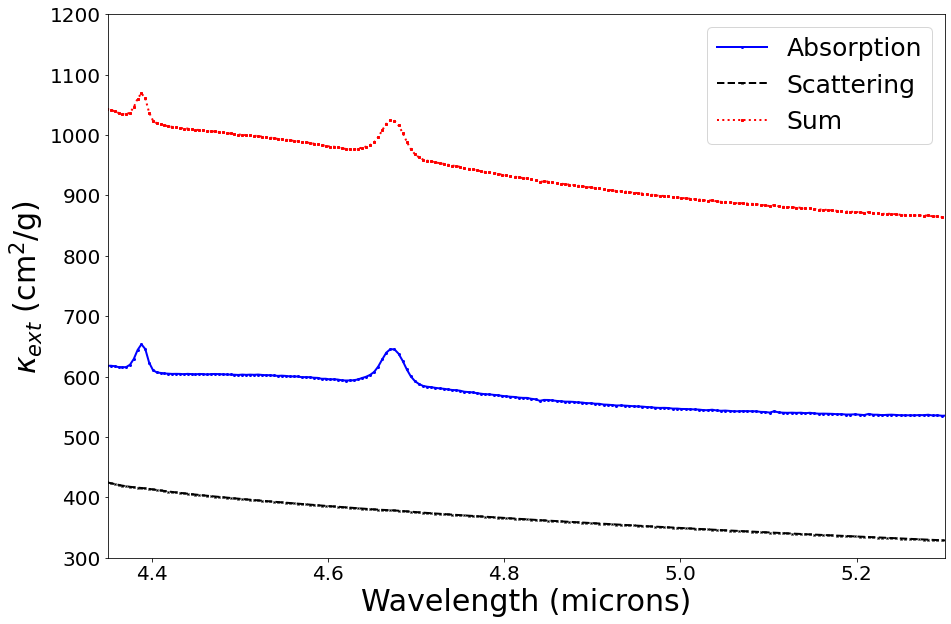

In [18]:
# print(kext_dat_ascend)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))

#if plotting the total law
# cext_orderofmag = 1e-23
# ax.plot(lam_kext, Cext_kext / cext_orderofmag, '--o', markersize=3.5, markerfacecolor='black', color='black')
# ax.set_ylim(3.4, 6.0)
# ax.set_ylabel(r'$ \rm C_{ext} \ (\times 10^{-23} \ cm^2)$', fontsize=30)

#if plotting only contributions from different processes
ax.plot(lam_kext, Abs_ext, label='Absorption', color='blue', marker='o', markersize=2, lw=2)
ax.plot(lam_kext, Sca_ext, label='Scattering', color='black', ls='--', marker='x', markersize=2, lw=2)
ax.plot(lam_kext, Abs_ext+Sca_ext, label='Sum', color='red', ls=':', marker='s', markersize=2, lw=2)
ax.set_ylim(3e2, 1.2e3)
ax.legend(fontsize=25)



#generic formatting
# ax.set_yscale('log')
ax.set_xlim(4.35, 5.3)
ax.set_ylabel(r'$\kappa_{ext} \ {\rm (cm^2 / g)}$', fontsize=30)
ax.set_xlabel('Wavelength (microns)', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)  

fig.savefig('CentralSource_CO/kp5_ext_law.pdf', bbox_inches='tight')

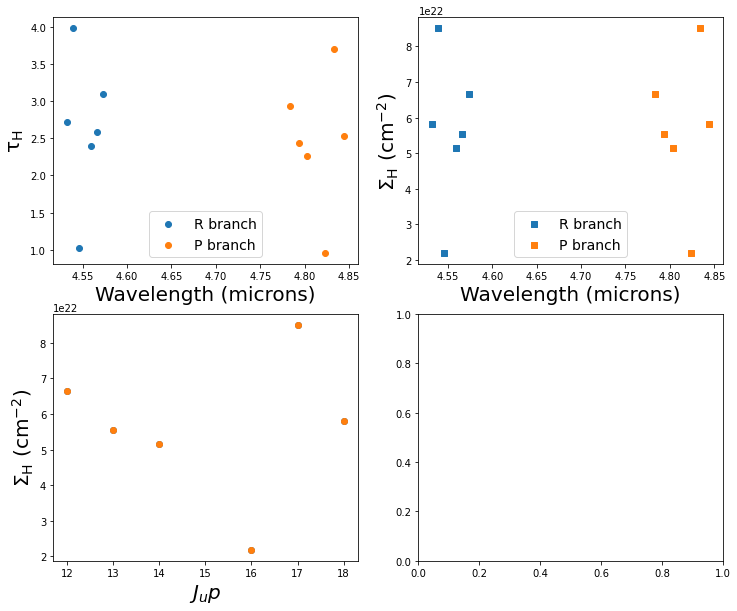

In [19]:
#tests with dr tau based on https://www.spexodisks.com/ExploreData/ishell_4516nm_5239nm_vstar_dr_tau 
# as well as https://iopscience.iop.org/article/10.3847/1538-3881/ac52f0/pdf
# ... McClure et al 2013 https://iopscience.iop.org/article/10.1088/0004-637X/769/1/73/pdf
# Muzerolle et al 2003 https://iopscience.iop.org/article/10.1086/379921/pdf
# McJunkin et al 2014 https://iopscience.iop.org/article/10.1088/0004-637X/780/2/150/pdf 
#p -> jup-1 while r -> jup+1
j_list = np.array([12, 13, 14, 16, 17, 18])
co_r_lam_list = np.array([4.573228, 4.566173, 4.559217, 4.545597, 4.538933, 4.532365]) #R11 (skipR14) to R17
co_p_lam_list = np.array([4.783296, 4.793124, 4.803069, 4.82331, 4.833610, 4.844029]) #P13 to P15, (skipP16)... P17, P18, P19
co_r_flux_list = np.array([5.28992, 5.1989, 5.16888, 5.7962, 4.76078, 5.37369])
co_p_flux_list = np.array([5.57661, 5.28781, 5.14677, 5.1719, 5.15197, 5.25218])
co_r_p_ratio_list = co_r_flux_list / co_p_flux_list

#intrinsic properties, einstein A-coefficients
co_A_ij_r = np.array([1.79E+01, 1.80E+01, 1.82E+01, 1.84E+01, 1.85E+01, 1.87E+01]) #r-branch
co_A_ij_p = np.array([1.69E+01, 1.67E+01, 1.66E+01, 1.63E+01, 1.62E+01, 1.60E+01]) #p-branch

r_to_p_0 = co_A_ij_r/co_A_ij_p * co_p_lam_list/co_r_lam_list #from HITRAN
C_ext_co = vs(co_r_lam_list) - vs(co_p_lam_list) #needed to define "Rv" for our set of CO transitions
tau_r_ext_list = vs(co_r_lam_list) / C_ext_co * np.log(r_to_p_0 / co_r_p_ratio_list) # 
tau_p_ext_list = vs(co_p_lam_list) / C_ext_co * np.log(r_to_p_0 / co_r_p_ratio_list) # 

#we also want tau / sigma = Sigma = n L, a column density
column_density_r_list = tau_r_ext_list / vs(co_r_lam_list)
column_density_p_list = tau_p_ext_list / vs(co_p_lam_list)

#setup a figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

ax[0,0].set_xlabel('Wavelength (microns)', fontsize=20)
ax[0,0].set_ylabel(r'$\rm \tau_{H}$', fontsize=20)    
ax[0,0].scatter(co_r_lam_list, tau_r_ext_list, label='R branch')
ax[0,0].scatter(co_p_lam_list, tau_p_ext_list, label='P branch')
ax[0,0].legend(loc='best', fontsize=14)

ax[0, 1].set_xlabel('Wavelength (microns)', fontsize=20)
ax[0, 1].set_ylabel(r'$\rm \Sigma_{H} \ ({cm}^{-2})$', fontsize=20)
ax[0, 1].scatter(co_r_lam_list, column_density_r_list, marker='s', label='R branch')
ax[0, 1].scatter(co_p_lam_list, column_density_p_list, marker='s', label='P branch')
ax[0, 1].legend(loc='best', fontsize=14)

ax[1, 0].set_xlabel(r'$J_up$', fontsize=20)
ax[1, 0].set_ylabel(r'$\rm \Sigma_{H} \ ({cm}^{-2})$', fontsize=20)    
ax[1, 0].scatter(j_list, column_density_r_list)
ax[1, 0].scatter(j_list, column_density_p_list)


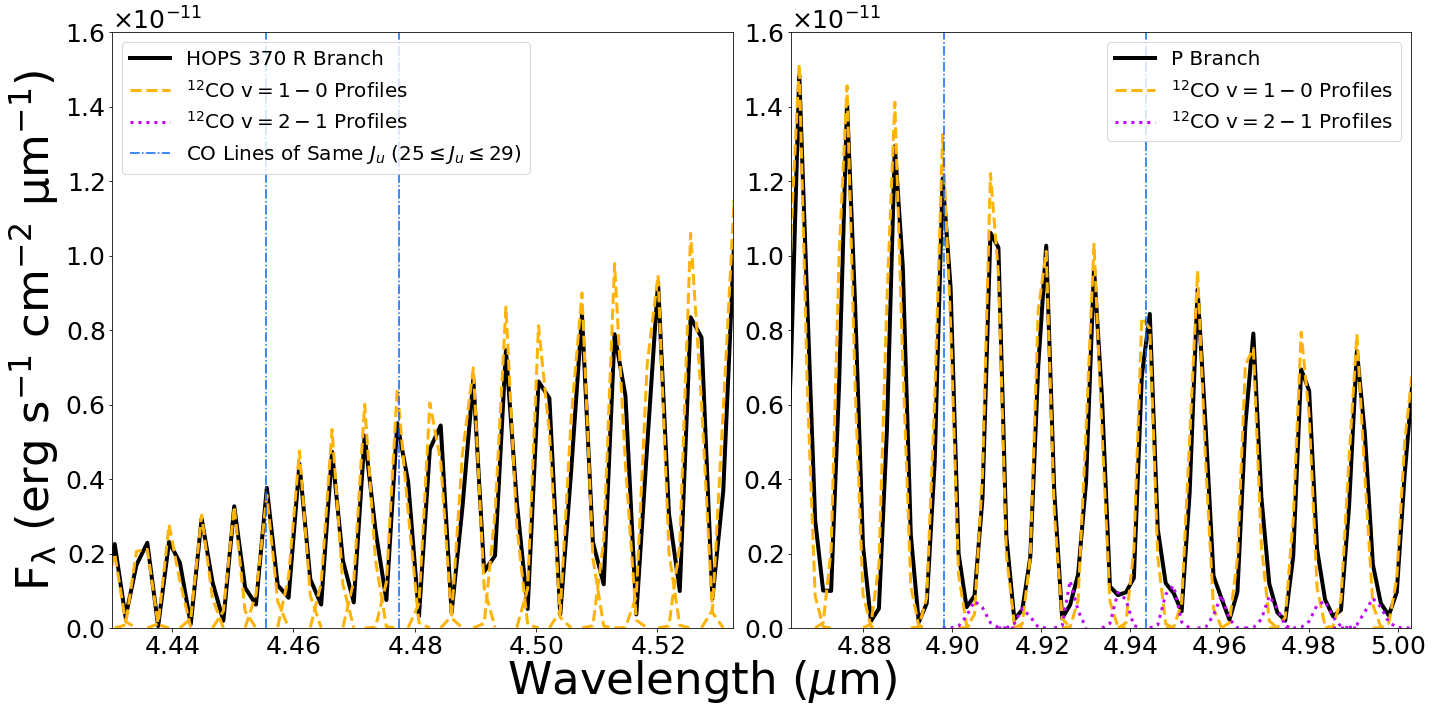

In [20]:
#here we want to demonstrate how we defined the extinction above and which J we choose!
color_list = ['xkcd:brick red', 'goldenrod', 'xkcd:cerulean', 'green', 'black'] #other params
co_branches = ['R Branch', 'P Branch']
v_list = ['v = 1 - 0' , 'v = 2 - 1']
protostar_chosen = [3]
fig, ax = plt.subplots(figsize=(20,10), nrows=len(protostar_chosen), ncols=len(co_branches), sharex='col') #setup fig, axes #make a figure to plot various locations on an image
fig.set_tight_layout(True)

#all ready to plot!
for count, i in enumerate(protostar_chosen): #choosing hops 370 by hand for now here # range(len(protostar_names)):
    for j in range(len(co_branches)):
        if j == 0:
            data_label = protostar_names[i] + ' ' + co_branches[j]
        else:
            data_label = co_branches[j]
        #plotting the original data
        wave_units_fix = 1 / delta_lambda #multiply by 1e-4 if you need pure cgs, and whatever wavelength we're about to multiply by will be in microns
        ax[j].plot(baseline_wave_list[i], wave_units_fix * fityk_intensity_list[i], label=data_label, linewidth=4, color='xkcd:black')


        #for each protostar, check for different v states
        for v_counter, v in enumerate(v_list):
            co_j_list = []
            co_r_lam_list = []
            co_p_lam_list = []
            co_r_flux_list = []
            co_p_flux_list = []
            co_r_unc_list = []
            co_p_unc_list = []

            p_match = [o for o in latex_formatted_data if ('P' in o[1] and v in o[1])] #check for P state and v state, will need as we go...
            #for each v state, go through the R branch lines to find the associated P branch lines
            for idx in range(len(latex_formatted_data)): #inefficient as we don't have to search through the whole list, but being basic for now
                #we need to check which line we're handling
                co_str = latex_formatted_data[idx][1] #the string for a given line


                #only continue on certain conditions for R
                if co_str.find('R') >= 0 and co_str.find(v) >= 0 and v == 'v = 1 - 0':
                    #useful CO values derived just from R-branch lines of a certain v state
                    co_r_num = int(latex_formatted_data[idx][1][-2:]) #which r-branch line?
                    co_j = co_r_num - 1 #which j then? delta_J in R branch is 1, so we need to subtract 1 to get J!

                    #search for the associated P-branch line
                    for p in p_match:
                        #need these to check if a valid comparison can be made
                        co_p_num = int(p[1][-2:]) #which r-branch line?
                        co_r_flux_unc_str = latex_formatted_data[idx][i+2].split(' \\\\')[0]
                        co_p_flux_unc_str = p[i+2].split(' \\\\')[0]

                        #if we have a match then...store values!
                        if co_p_num == co_j - 1 and p[1].find(v) >= 0 and co_r_flux_unc_str != '--' and co_p_flux_unc_str != '--' and co_j > 10:
                            #getting fluxes and uncertainties in R branch
                            co_r_lam = float(latex_formatted_data[idx][0])
                            co_r_flux = float(co_r_flux_unc_str.split('$')[0]) * flux_norm_list[i]
                            co_r_unc = float(co_r_flux_unc_str.split('$')[-1]) * flux_norm_list[i]
                            #same in p branch
                            co_p_lam = float(p[0])
                            co_p_flux = float(co_p_flux_unc_str.split('$')[0]) * flux_norm_list[i]
                            co_p_unc = float(co_p_flux_unc_str.split('$')[-1]) * flux_norm_list[i]

                            #separate flux data into lists
                            co_j_list.append(co_j)
                            co_r_lam_list.append(co_r_lam)
                            co_p_lam_list.append(co_p_lam)
                            co_r_flux_list.append(co_r_flux)
                            co_p_flux_list.append(co_p_flux)
                            co_r_unc_list.append(co_r_unc)
                            co_p_unc_list.append(co_p_unc)

                #for vibrationally excited state, we just directly use values since no pairs            
                elif v == 'v = 2 - 1' and co_str.find(v) >= 0 and latex_formatted_data[idx][i+2].split(' \\\\')[0] != '--' and int(co_str[-2:]) > 13:
                                        
                    #grab data
                    co_num = int(co_str[-2:]) #which r-branch line?
                    co_j = co_num - 1 #which j then? delta_J in R branch is 1, so we need to subtract 1 to get J!
                    co_p_flux_unc_str = latex_formatted_data[idx][i+2]
                    #getting fluxes and uncertainties in P branch
                    co_p_lam = float(latex_formatted_data[idx][0])
                    co_p_flux = float(co_p_flux_unc_str.split('$')[0]) * flux_norm_list[i]
                    co_p_unc = float(co_p_flux_unc_str.split('$')[-1]) * flux_norm_list[i]
                    #and store
                    co_j_list.append(co_j)
                    co_p_lam_list.append(co_p_lam)
                    co_p_flux_list.append(co_p_flux)
                    co_p_unc_list.append(co_p_unc)    

                        
            #this part uses flux/width to approximate the peak and plot the line profiles
            for idx in range(len(co_j_list)):
                    #next do match for 12co fluxes and widths depending on branch to isiolate their properties...
                    if co_j_list[idx] >= 10 and co_j_list[idx] <= 40: #filter out any low-J outliers
                            if j == 0 and v != 'v = 2 - 1': #r branch
                                    co_bright_flux_match = co_r_flux_list[idx] #grab 12co flux match, R -> J + 1 
                                    co_bright_wave_match = co_r_lam_list[idx]
                            elif j == 1: #p branch
                                    co_bright_flux_match = co_p_flux_list[idx] #grab 12co flux match, P -> J - 1
                                    co_bright_wave_match = co_p_lam_list[idx]

                            #need fwhm the same either way
                            fwhm_match = wave_fwhm_list[i][np.argmin(np.abs(wave_centers_list[i] - co_bright_wave_match))] #fwhm 
                            sigma = fwhm_match / np.sqrt(8.0*np.log(2.0)) #property of gaussians
                            sigma_sq = sigma*sigma #pre-calculating sigma^2

                            #defining a mask to integrate over (+/- 5 * fwhm)
                            exp_mask = (baseline_wave_list[i] > (co_bright_wave_match - 5.0 * sigma)) * (baseline_wave_list[i] < (co_bright_wave_match + 5.0 * sigma))
                            unres_exp = np.exp(-np.power(baseline_wave_list[i][exp_mask] - co_bright_wave_match, 2) / (2 * sigma_sq)) #unfortunatley cannot be "factored out" of for loop because of dependence on sigma

                            #if plotting...
                            #defining a mask to integrate over (+/- 5 * fwhm)
                            unres_exp = np.exp(-np.power(baseline_wave_list[i][exp_mask] - co_bright_wave_match, 2) / (2 * sigma_sq)) #unfortunatley cannot be "factored out" of for loop because of dependence on sigma
                            single_line_flux_set = co_bright_flux_match/fwhm_match * unres_exp #multiply the exponential by the peak value; flux / fwhm_match

                            if co_j_list[idx] != 20 and v == 'v = 1 - 0':
                                ax[j].plot(baseline_wave_list[i][exp_mask], single_line_flux_set, color='xkcd:amber', lw=3, ls='--')
                            elif co_j_list[idx] == 20 and v == 'v = 1 - 0':
                                ax[j].plot(baseline_wave_list[i][exp_mask], single_line_flux_set, color='xkcd:amber', label=r'$\rm {}^{12}CO \ v = 1 - 0 \ Profiles$', lw=3, ls='--')
                            elif co_j_list[idx] != 13 and v == 'v = 2 - 1':
                                 ax[j].plot(baseline_wave_list[i][exp_mask], single_line_flux_set, color='xkcd:bright purple', lw=3, ls=':')
                            elif co_j_list[idx] == 13 and v == 'v = 2 - 1':
                                 ax[j].plot(baseline_wave_list[i][exp_mask], single_line_flux_set, color='xkcd:bright purple', label=r'$\rm {}^{12}CO \ v = 2 - 1 \ Profiles$', lw=3, ls=':')
                

        #formatting
        # ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
        ax[j].tick_params(axis='both', which='major', labelsize=25)
        # ax[j].set_ylabel(r'$\rm \lambda F_{\lambda} \ (erg \ {cm}^{-2} \ {s}^{-1})$', fontsize=45)
        if i == len(protostar_names) - 1:
            ax[j].set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=45)

        #set axes limits according to the Jup = 24 to 29 lines inclusive we are using
        if j == 0: #R26 to R30
            # ax[j].set_yscale('log')
            ax[j].axvline(x=4.4556, linestyle='-.', color='xkcd:bright blue', label=r'CO Lines of Same $J_u$ ($25 \leq J_u \leq 29$)') #R30
            ax[j].axvline(x=4.4775, linestyle='-.', color='xkcd:bright blue') #R26
            ax[j].set_xlim(4.4302, 4.5324) #R17 to R35
            ax[j].set_ylim(-1e-17, 1.6e-11)
            ax[j].legend(loc='upper left', fontsize=20)            #set legend last
        if j == 1:#P24 to P28
            # ax[j].set_yscale('log')
            ax[j].axvline(x=4.8980, linestyle='-.', color='xkcd:bright blue') #P24
            ax[j].axvline(x=4.9434, linestyle='-.', color='xkcd:bright blue') #P28
            ax[j].set_xlim(4.8637, 5.0031) #P15 to P33 
            ax[j].set_ylim(-1e-17, 1.6e-11)        
            ax[j].legend(loc='best', fontsize=20)            #set legend last

        # Get the text object for order of mag following https://stackoverflow.com/questions/23392833/python-pylab-how-to-alter-the-size-of-the-label-specifying-the-magnitude-of-the
        text = ax[j].yaxis.get_offset_text()
        text.set_size(25)     # Set the size. # Overkill?
        ax[j].ticklabel_format(useMathText=True) #following scalar formatters https://matplotlib.org/stable/gallery/ticks/scalarformatter.html

        #need to do this label last
        # if i == len(protostar_names)-3 and j == 0: #need it on the left side too
ax[j-1].set_ylabel(r'$\rm F_{\lambda} \ (erg \ {s}^{-1} \ {cm}^{-2} \ {\mu m}^{-1})$', fontsize=45)
ax[j-1].set_xlabel(r'Wavelength ($\mu \rm{m}$)', fontsize=45)
ax[j-1].xaxis.set_label_coords(0.95, -0.05)
fig.savefig('CentralSource_CO/' + 'CO_ext_lines_' + protostar_names[i].replace(' ', '_') + '.pdf', bbox_inches='tight')

J:  25
tau_diff (P - R): -1.0616461415890743
IRAS 16253-2429 Source
Mean:  2.492253295930631e+23
StD:  5.452195854566826e+21
J:  25
tau_diff (P - R): -1.2917792902860334
B335 Source
Mean:  3.253979053620831e+23
StD:  3.6864918966869477e+22
J:  25
tau_diff (P - R): -1.1717316683181362
HOPS 153 Source
Mean:  2.9830807424466036e+23
StD:  4.308613388037194e+22
J:  25
tau_diff (P - R): -1.3354266467843505
HOPS 370 Source
Mean:  3.33165929801285e+23
StD:  1.879645046076629e+22
J:  25
tau_diff (P - R): -1.3155143364948394
IRAS 20126+4104 Source
Mean:  2.8063112052294905e+23
StD:  1.9693607795789794e+22


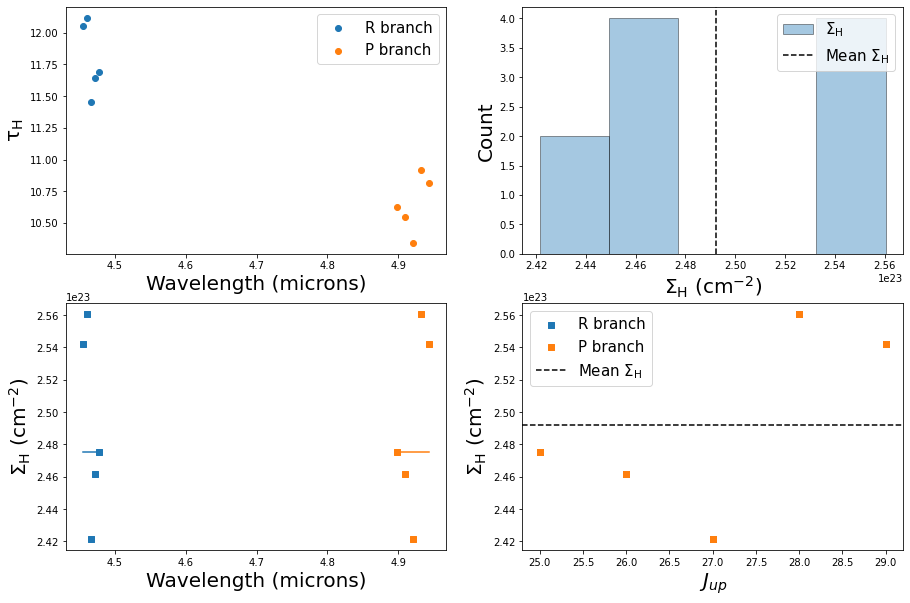

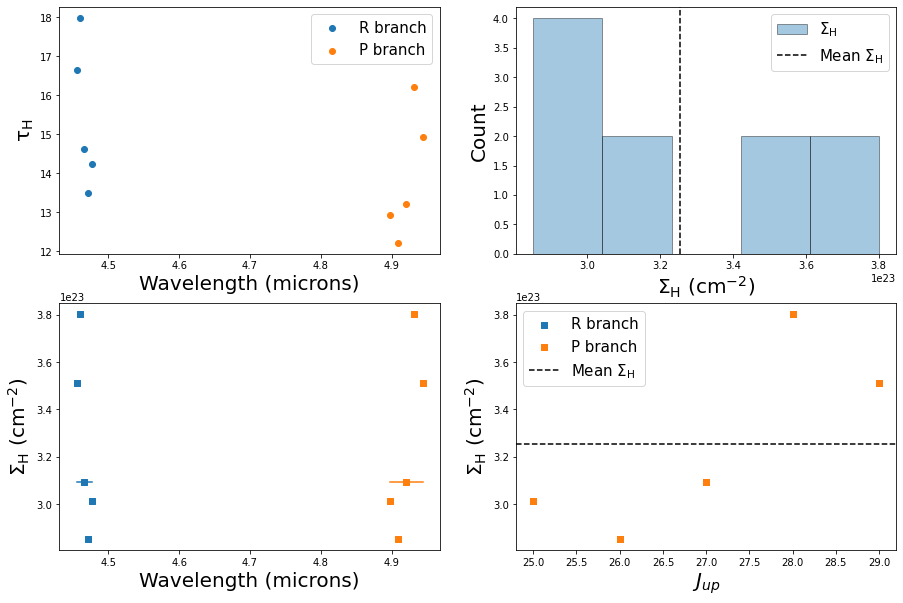

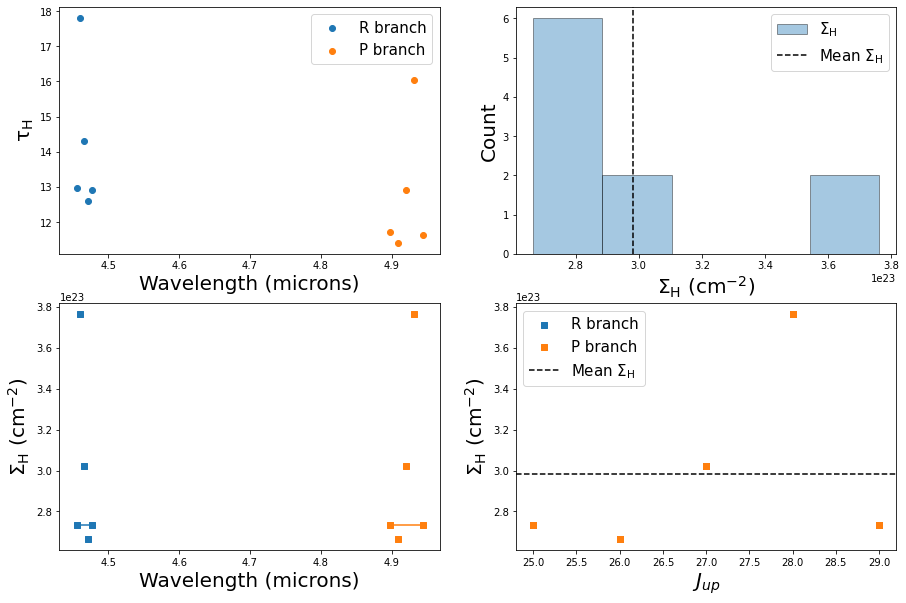

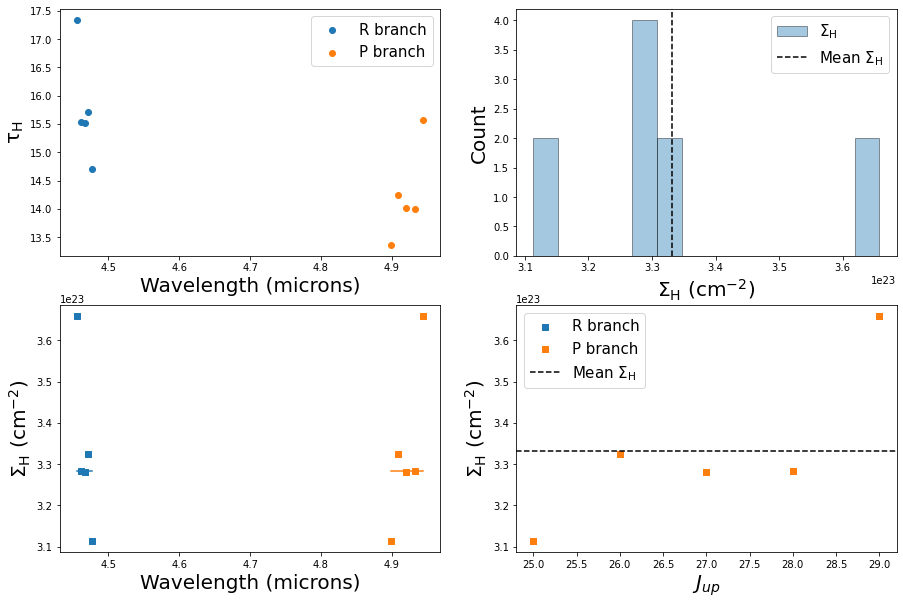

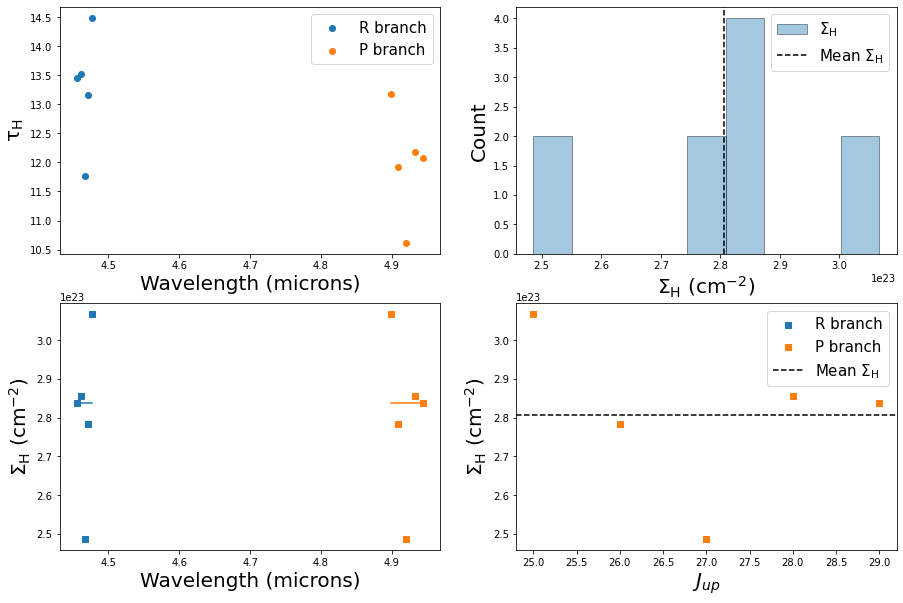

In [21]:
#first format your data so we know what we're dealing with; we want everything from the same upper state so we can fully characterize those lines
from scipy.stats import mode #need to compute mode later

#input values, such as wavelength resolution for our lookup tables
# protostar_idx = 0 #for use in tests
filtered_Sigma_col_arr = []
avg_Sigma_col_arr = [] #empty list needed to be filled for each protostar
avg_Sigma_col_unc_arr = [] #empty list needed to be filled for each protostar
avg_tau_arr = []
v_list = ['v = 1 - 0'] #in this case, we only go over 1 v state for extinction as we don't have the R-branch lines (for population diagrams, we do both)

#loop of a particular protostar
for j in range(len(protostar_names)):
    count = 0
    Sigma_col_r_arr = []
    Sigma_col_p_arr = []

    #setup a figure
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    ax[0,0].set_xlabel('Wavelength (microns)', fontsize=20)
    ax[0,0].set_ylabel(r'$\rm \tau_{H}$', fontsize=20)    
    ax[0,1].set_xlabel(r'$\rm \Sigma_{H} \ ({cm}^{-2})$', fontsize=20)
    ax[0,1].set_ylabel('Count', fontsize=20)
    ax[1,0].set_xlabel('Wavelength (microns)', fontsize=20)
    ax[1,0].set_ylabel(r'$\rm \Sigma_{H} \ ({cm}^{-2})$', fontsize=20)
    ax[1,1].set_xlabel(r'$J_{up}$', fontsize=20)
    ax[1,1].set_ylabel(r'$\rm \Sigma_{H} \ ({cm}^{-2})$', fontsize=20)

    #for each protostar, check for different v states
    for v in v_list:
        co_j_list = []
        co_r_lam_list = []
        co_p_lam_list = []
        co_r_flux_list = []
        co_p_flux_list = []
        co_r_unc_list = []
        co_p_unc_list = []

        p_match = [o for o in latex_formatted_data if ('P' in o[1] and v in o[1])] #check for P state and v state, will need as we go...
        #for each v state, go through the R branch lines to find the associated P branch lines
        for i in range(len(latex_formatted_data)): #inefficient as we don't have to search through the whole list, but being basic for now
            #we need to check which line we're handling
            co_r_str = latex_formatted_data[i][1] #the string for a given line

            #only continue on certain conditions for R
            if co_r_str.find('R') >= 0 and co_r_str.find(v) >= 0:
                #useful CO values derived just from R-branch lines of a certain v state
                co_r_num = int(latex_formatted_data[i][1][-2:]) #which r-branch line?
                co_j = co_r_num - 1 #which j then? delta_J in R branch is 1, so we need to subtract 1 to get J!

                #search for the associated P-branch line
                for p in p_match:
                    #need these to check if a valid comparison can be made
                    co_p_num = int(p[1][-2:]) #which r-branch line?
                    co_r_flux_unc_str = latex_formatted_data[i][j+2].split(' \\\\')[0]
                    co_p_flux_unc_str = p[j+2].split(' \\\\')[0]

                    #if we have a match then...store values!
                    if co_p_num == co_j - 1 and p[1].find(v) >= 0 and co_r_flux_unc_str != '--' and co_p_flux_unc_str != '--' and co_j >= 25 and co_j <= 29: # alternative is co_j > 10

                        #getting fluxes and uncertainties in R branch
                        co_r_lam = float(latex_formatted_data[i][0])

                        co_r_flux = float(co_r_flux_unc_str.split('$')[0]) * flux_norm_list[j]
                        co_r_unc = float(co_r_flux_unc_str.split('$')[-1]) * flux_norm_list[j]
                        #same in p branch
                        co_p_lam = float(p[0])
                        co_p_flux = float(co_p_flux_unc_str.split('$')[0]) * flux_norm_list[j]
                        co_p_unc = float(co_p_flux_unc_str.split('$')[-1]) * flux_norm_list[j]

                        #separate flux data into lists
                        # if co_r_flux / co_r_unc > 10.0 and co_p_flux / co_p_unc > 10.0:
                        # if co_p_lam > 4.75 and co_p_lam < 5.0 and co_r_lam > 4.5 and co_r_lam < 4.7:
                        co_j_list.append(co_j)
                        co_r_lam_list.append(co_r_lam)
                        co_p_lam_list.append(co_p_lam)
                        co_r_flux_list.append(co_r_flux)
                        co_p_flux_list.append(co_p_flux)
                        co_r_unc_list.append(co_r_unc)
                        co_p_unc_list.append(co_p_unc)

        #now can use lists! before resetting for next protostar and/or v-state; first make sure arrays are numpy...
        co_j_list = np.array(co_j_list)
        co_r_lam_list = np.array(co_r_lam_list)
        co_p_lam_list = np.array(co_p_lam_list)
        co_r_flux_list = np.array(co_r_flux_list)
        co_p_flux_list = np.array(co_p_flux_list)
        co_r_unc_list = np.array(co_r_unc_list)
        co_p_unc_list = np.array(co_p_unc_list)

        #some useful ratios and propagated the ratio of uncertainties for later too
        co_r_p_ratio_list = co_r_flux_list / co_p_flux_list #note if conversion done here
        co_err_r_p_ratio_list = co_r_p_ratio_list * np.sqrt( (co_r_unc_list/co_r_flux_list)**2. + (co_p_unc_list/co_p_flux_list)**2.) #note conversion done here
            
        #look up the co lab properties we need and split them into r and p branches for use in calculations
        #column_names[0] is 'Wv, microns', the first column of the co lab properties
        #wave_lookup_res is at the start of this code block and is about the minimum allowed
        #r-branch
        co_A_ij_r = [] #list of indices for use in looking up wavelengths and matching what we have to the lab properties
        for k in range(len(co_r_lam_list)):
            idx = np.argmin([np.abs(co_r_lam_list[k] - lam) for lam in co_lab_props[co_lab_columns[0]]])
            co_A_ij_r.append(co_lab_props[co_lab_columns[1]][idx]) #apply indices to and lookup in table of lab properties
        co_A_ij_r = np.array(co_A_ij_r)

        #p-branch
        co_A_ij_p = [] #list of indices for use in looking up wavelengths and matching what we have to the lab properties
        for k in range(len(co_p_lam_list)):
            idx = np.argmin([np.abs(co_p_lam_list[k] - lam) for lam in co_lab_props[co_lab_columns[0]]])
            co_A_ij_p.append(co_lab_props[co_lab_columns[1]][idx]) #apply indices to and lookup in table of lab properties
        co_A_ij_p = np.array(co_A_ij_p)

        #determine extinction here!
        column_density_r_list, column_density_p_list, tau_r_ext_list, tau_p_ext_list, tau_r_err_list, tau_p_err_list = \
                                                extinc(co_r_lam_list, co_p_lam_list, co_r_p_ratio_list, co_err_r_p_ratio_list, co_A_ij_r, co_A_ij_p)
        Sigma_col_r_arr.append(column_density_r_list)
        Sigma_col_p_arr.append(column_density_p_list)


        #extinction differences
        for flux_ind in range(len(co_r_flux_list)):
            #for checking luminosity and extinction correction
            if co_j_list[flux_ind] == 25: # np.min(co_j_list)
                print('J: ', co_j_list[flux_ind])
                # print('tau: ', tau_r_lam_arr[flux_ind], tau_p_lam_arr[flux_ind])
                print('tau_diff (P - R):', tau_p_ext_list[flux_ind] - tau_r_ext_list[flux_ind])
         

        #now to make some example plots; we will pick one for later
        ### Sigma vs JUP
        ax[0,0].scatter(co_r_lam_list, tau_r_ext_list, marker='o', label='R branch') #should label the very large or negative values as irrelevant...
        ax[0,0].scatter(co_p_lam_list, tau_p_ext_list, marker='o', label='P branch') #should label the very large or negative values as irrelevant...
        avg_tau_arr.append((np.median(tau_r_ext_list) + np.median(tau_p_ext_list)) / 2.0)

        ### Sigma vs JUP
        ax[1,1].scatter(co_j_list, Sigma_col_r_arr, marker='s', label='R branch') #should label the very large or negative values as irrelevant...
        ax[1,1].scatter(co_j_list, Sigma_col_p_arr, marker='s', label='P branch') #should label the very large or negative values as irrelevant...

        ### Sigma vs LAM
        #checking plot of reddening as function of wavelength
        ax[1,0].scatter(co_r_lam_list, Sigma_col_r_arr, marker='s', label='R branch') #should label the very large or negative values as irrelevant...
        ax[1,0].scatter(co_p_lam_list, Sigma_col_p_arr, marker='s', label='P branch') #should label the very large or negative values as irrelevant...

    ### Sigma HISTOGRAM
    #first threshold
    Sigma_col_arr = np.array([Sigma_col_r_arr, Sigma_col_p_arr]).flatten() #combine all the data into one for averaging
    avg_Sigma_stdev = np.nanstd(Sigma_col_arr, ddof=1)/np.sqrt(len(Sigma_col_arr))
    # init_sigma_mask = (Sigma_col_arr > np.nanmedian(Sigma_col_arr) - 5.0 * avg_Sigma_stdev) * \
    #                     (Sigma_col_arr < np.nanmedian(Sigma_col_arr) + 5.0 * avg_Sigma_stdev) 
    Sigma_col_arr_masked = Sigma_col_arr[Sigma_col_arr < 2*5e23] #5e23 is a number we could change...
    avg_Sigma_col_filtered = np.nanmean(Sigma_col_arr_masked)     #now apply threshold and determine average

    #reapply values and store average for later
    avg_Sigma_stdev_filtered = np.nanstd(Sigma_col_arr_masked, ddof=1) # /np.sqrt(len(Sigma_col_arr_masked))
    filtered_Sigma_col_arr.append(Sigma_col_arr_masked)
    avg_Sigma_col_arr.append(avg_Sigma_col_filtered)
    avg_Sigma_col_unc_arr.append(avg_Sigma_stdev_filtered)
    print(protostar_names[j], 'Source')
    print('Mean: ', avg_Sigma_col_filtered)
    # print('Uncertainties: ', avg_Sigma_col_unc_arr[j])
    # print('Removed Outliers: ', avg_Sigma_col_filtered, 'High Transmission, still outliers: ', np.nanmedian(Sigma_col_arr))
    print('StD: ', avg_Sigma_stdev_filtered)
    # Sigma_col_arr = Sigma_col_arr[Sigma_col_arr > 0]
    # _ = ax[0,1].hist(Sigma_col_arr, bins='auto', edgecolor='k', alpha=0.4, label='All data')  # arguments are passed to np.histogram, note auto bins?
    _ = ax[0,1].hist(Sigma_col_arr_masked, bins='auto', edgecolor='k', alpha=0.4, label=r'$\rm \Sigma_{H}$')  # arguments are passed to np.histogram, note auto bins?
    ax[0,1].axvline(avg_Sigma_col_filtered, color='k', linestyle='--', label=r'$\rm Mean \ \Sigma_{H}$')
    ax[1,1].axhline(avg_Sigma_col_filtered, color='k', linestyle='--', label=r'$\rm Mean \ \Sigma_{H}$') #plot on another plot...
    ax[1,0].plot(co_r_lam_list, [np.median(Sigma_col_r_arr)] * len(co_r_lam_list), label=r'R branch, $\rm Median \ \Sigma_{H}')
    ax[1,0].plot(co_p_lam_list, [np.median(Sigma_col_p_arr)] * len(co_p_lam_list), label=r'P branch, $\rm Median \ \Sigma_{H}')

    ax[0,0].legend(loc='best', fontsize=15)
    # ax[0,1].set_xlim(avg_Sigma_col_filtered - 5.0*avg_Sigma_stdev, avg_Sigma_col_filtered + 5.0*avg_Sigma_stdev)
    ax[0,1].legend(fontsize=15)
    # ax[1,0].set_ylim(0,40)
    # ax[1,0].legend(loc='best')
    # ax[1,1].set_ylim(0,1000) #,35)
    ax[1,1].legend(loc='best', fontsize=15)

    
    #saving spectra
    ''' 
    the present units of the spectra to save are in erg/sec/cm^2/micron
    if we divide by c/lambda^2 IN MICRON this factor has units of s/micron, then dividing will get back to 1/sec
    then we divide by 1e-23 erg/sec/cm^2/Hz per Jy, which gets back to units of Jy
    '''
    Jy_units = 1e-23 * 3e14/baseline_wave_list[j]**2.
    with open('Spectra1D_tests/' + protostar_names[j] + '_baselineSubtractedSpectrum.txt', 'w') as f:
        f.write('Baseline subtracted spectrum for ' + protostar_names[j]  + ' (by AER) \n') #set the header
    with open('Spectra1D_tests/' + protostar_names[j] + '_baselineSubtractedSpectrum.txt', 'a') as f: #appending data
        f.write('Wavelength(microns), Fnu(Jy), PipelineUncertainty(Jy), tau_extinction \n')
        for k in range(len(baseline_wave_list[j])): #loop through each line:
            f.write(str(baseline_wave_list[j][k]) + ', ' + str(1.0/delta_lambda/Jy_units[k] * fityk_intensity_list[j][k]) + ', ' + \
                     str(1.0/delta_lambda/Jy_units[k] * err_list[j][k]) + ', ' + str(avg_Sigma_col_arr[j] * vs(baseline_wave_list[j][k])) + '\n')
    # np.savetxt('Spectra1D_tests/' + protostar_names[j] + '_baselineSubtractedSpectrum.txt', (baseline_wave_list[j], 1.0 / delta_lambda * fityk_intensity_list[j], 1.0 / delta_lambda * err_list[i]), delimiter=',', \
    #            header = 'Wavelength(microns), Flambda(erg/sec/cm^2/micron), PipelineUncertainty(erg/sec/cm^2/micron', comments='Baseline subtracted spectrum for ' + protostar_names[i]  + ' (by AER) \n')


# Take Av values from H2 rotation diagrams (credits: Mayank Narang, Himanshu Tyagi) and convert

See equation 2 from Pontoppidan+ 2024 (https://iopscience.iop.org/article/10.3847/2515-5172/ad303f):

$A_{\lambda} = 2.5 log_{10}(e) N \kappa_{ext}(\lambda)$

-->

$N = A_{\lambda} \times (2.5 log_{10}(e) \kappa_{ext}(\lambda))^{-1}$

In [22]:
#first grab values from the fitted H2 rotation diagrams
Av_fromH2_list = np.array([22.68, np.mean([38.85, 36.86]), np.nanmean([30.77, 25.08]), np.mean([7.59, 11.81]), np.mean([9.42, 14.69])]) #IRAS 16253 with H2 is 22.68

lambdaV = 0.547
avg_Sigma_col_arr = Av_fromH2_list * 1.0 / (2.5 * np.log10(np.exp(1)) * vs(lambdaV)) #here, vs(lambdaV is the total kext at visible wavelengths); units will be cm^-2
print(avg_Sigma_col_arr * 116/100 * 2.09/0.7389)

[9.74394781e+22 1.62635425e+23 1.19973432e+23 4.16738509e+22
 5.17915745e+22]


In [23]:
#Dan's version using OH and the depth of the CO2 ice feature
#the extinction column density in units of H nucleon per cm^-2 is 1.35E23
#this should be an Av of approx 6.2
1.35e23 * 1.6735e-24 * 116 * 0.7389 * 2.5 * np.log10(np.exp(1))

21.02458639630617

# Develop functions for rotation or CO population diagrams

In [24]:
#a full worked example with a rotation diagram choosing linear fits by hand

#next, we make rotation diagrams! first grab some constants
#see for example https://iopscience.iop.org/article/10.1088/0004-637X/770/2/123/pdf by Joel (appendix)
#can also see David Neufeld's work (https://iopscience.iop.org/article/10.1088/0004-637X/749/2/125/pdf) or Goldsmith99
#for an option with temperature and density gradients, see https://arxiv.org/pdf/2301.13135.pdf
# jy_to_cgs = 1e-23 #not we're not worrying about mega here b/c we converted that earlier
#but flux conversions were in units of fwhm/lambda^2, which is micron/micron^2 or 1/micron...to cgs! means * 1/1e4
#ignore these conversions, already built in now
pc_to_cm = 3.086e18
dist_list = pc_to_cm*np.array([140, 165, 390, 390, 1.55e3]) #pc: from Ortiz-Leon 2018, Watson 2020, Tobin+2020a, Tobin+2020a, Reid+2019
# au_to_cm = 1.496e13 # au to cm...
# aperture_area_cm = np.pi * (0.5 * dist_list/pc_to_cm * au_to_cm)**2.0 #arcsec * pc = au, so if we go back to pc, multiply by our arcsec aperture length scale 0.5 we can get area...
h_cgs = 6.626e-27 #erg/sec
c_cgs = 3e10 #cm/s
hc_cgs = h_cgs * c_cgs

''' 
here need to check some math for the right hand side of this equation...
NJ/gJ = N/Q * exp(-Eu/Trot)
so log of LHS = log(NJ/gJ)
log of RHS is log(N) + log(Q) + log(exp(-Eu/Trot)) = log(N) + log(Q) + (-Eu/Trot)
Here, Q = approx kbT / (hcB). in equilib, T = Trot...not always correct!

anyway, we can see which has very large deviations so...
log(Q) = log(kbTrot/hcB) = log(kb/(hcB))+log(Trot)
so overall we get log(N) + log(kb/(hcB)) + log(Trot) + (-Eu/Trot)
notice that if you have -x/T+log(T), then log(T) will be relatively small...you can tell this by plotting, for example, y=log(x) and y=x...it could hypothetically change log(N), but if log(N)>>log(T)...
in fact, if you compute the partition function regardless of temperature, you'll find it's quite small: https://www.wolframalpha.com/input?i=log%281.4e-16+erg%2FK+%2F+6.626e27+erg*sec+%2F+3e14+cm%2Fs+%2F+%28192.25%2F100*cm%5E-1%29%29
~on the order of 1E-59...do need to check that and actually add it in, remember logs!, but we have now!
https://www.wolframalpha.com/input?i=2+*+1.4e-16+%2F+%286.626e-27+*+3e10+*+1.9225%29
https://www.wolframalpha.com/input?i=6.626e-27+erg*sec+*+3e10+cm%2Fs+%2F+1.4e-16+erg%2FK

so to simplify, then log of RHS ~= log(N) - Eu/Trot...now just plot vs. Eu!
'''
#rotational constants
k_B_cgs = 1.4e-16 #erg/K
Z_J_const = k_B_cgs / hc_cgs / 1.9225 # 3.663e-1 # in K, or logged???: -127.646482723869880985840966; 1.9225 is in cm^-1 
print('Test for partition function, ZJ(T=3000K) = ', Z_J_const * 3000.0)

#next, make some linear fits
#taken from https://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python
from scipy import optimize 
from scipy.optimize import curve_fit
from lmfit import minimize, Parameters, Parameter, report_fit #alternative methods
from lmfit.models import LinearModel
# def Trot_fitter(Eu, Ntot, slopeT):
#     return np.log(Ntot) + -1.*Eu/slopeT - np.log(Z_J_const*slopeT) #- -1.*d_i*np.log(1.0 - np.exp(-Z_v_const/slopeT))
def linear_fitter(Eu, m, b):
    return -1. * 1.0/m * Eu + b #- -1.*d_i*np.log(1.0 - np.exp(-Z_v_const/slopeT))

#a brute force search https://stackoverflow.com/questions/46218934/piecewise-linear-fit-with-n-breakpoints
npoly = np.polynomial.polynomial
#alternatives #taken from https://stackoverflow.com/questions/19955686/fit-a-curve-for-data-made-up-of-two-distinct-regimes
#or https://stackoverflow.com/questions/41641880/using-scipy-curve-fit-with-piecewise-function
#some imports and styles related to plotting lines
# from scipy.optimize import brute
# num_breakpoints = [2, 1, 1]
# linestyle_list = ['-', '--', ':', '-.']
# color_list = ['red', 'green', 'blue']
# marker_list = ['o', 'D', '^']

#https://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python
#https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a
# alternative (very explicit): https://stackoverflow.com/questions/76845930/multi-line-fitting-on-a-graph-and-calculating-the-position-of-the-intersection-p
# alternative (see explicit piecewise function with parameter to be fit): https://stackoverflow.com/questions/19955686/fit-a-curve-for-data-made-up-of-two-distinct-regimes
def segments_fit(X, Y, count):
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([97.5]*(count+1)) # np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    # print('segment_fit test: ', px_init, py_init)
    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)

#if you would like a latex formatting of numbers to scientific notation (mostly for major plots)
#from https://stackoverflow.com/questions/13490292/format-number-using-latex-notation-in-python
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"${0} \times 10^{{{1}}}$".format(base, int(exponent))
    else:
        return float_str

Test for partition function, ZJ(T=3000K) =  1099.03179224217


### Combine rotation diagrams and/or extinction histograms into a figure for all protostars

Also note and store any values from fitting

IRAS 16253-2429
relevant fit values:  v = 1 - 0 1026 72965 1.5620688685623467e+41 6.363816171036538e+40
break points:  [5303.51534513 5150.79665351 5003.47985565 4861.57092967 4725.07513144
 4593.99786502 4468.34409851 4348.1188029  4233.32637079 4123.97148396
 4020.05825013 3921.5907727  3828.57272776 3741.00764319 3658.8990512
 3582.25019336 3511.06373573 3445.34277744 3385.08955148 3330.30643759]
Formally fitting v=1-0, T1 in curve_fit:  1027.1720930684482 32.95561582213639
Formally fitting v=1-0, T2 in curve_fit:  70200.61318984671 138242.8509518182
IRAS 16253-2429 v = 2 - 1 300915 4.079756941285828e+40
Formally fitting v=2-1, T in curve_fit:  60592.09456617377 134900.2014329392


C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2503704907.py:309: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax_rotation.errorbar(E_u_J_avg[high_sigma_mask], avg_log_NJ_gJ_ratio[high_sigma_mask], xerr=None, yerr=avg_log_NJ_gJ_err[high_sigma_mask], \
C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2503704907.py:313: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  low_snr_3sig_logratios = np.log(np.array((1.0 / hc_lamP_cgs[low_sigma_mask]*(co_p_flux_list[low_sigma_mask]+3.0*co_p_unc_list[low_sigma_mask])*np.exp(tau_p_lam_arr[low_sigma_m

B335
relevant fit values:  v = 1 - 0 1167 5133 1.504116594800857e+41 2.6420778868050923e+40
break points:  [4725.07513144 4593.99786502 4468.34409851 4348.1188029  4233.32637079
 4123.97148396 4020.05825013 3921.5907727  3828.57272776 3741.00764319
 3658.8990512  3582.25019336 3511.06373573 3445.34277744 3385.08955148
 3330.30643759]
Formally fitting v=1-0, T1 in curve_fit:  1247.73238037436 111.38473318254665
Formally fitting v=1-0, T2 in curve_fit:  5711.048293570304 762.8058995858037
B335 v = 2 - 1 -42715 nan


C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2503704907.py:309: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax_rotation.errorbar(E_u_J_avg[high_sigma_mask], avg_log_NJ_gJ_ratio[high_sigma_mask], xerr=None, yerr=avg_log_NJ_gJ_err[high_sigma_mask], \
C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2503704907.py:313: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  low_snr_3sig_logratios = np.log(np.array((1.0 / hc_lamP_cgs[low_sigma_mask]*(co_p_flux_list[low_sigma_mask]+3.0*co_p_unc_list[low_sigma_mask])*np.exp(tau_p_lam_arr[low_sigma_m

HOPS 153
relevant fit values:  v = 1 - 0 1083 8780 1.1245140413832338e+42 1.8422613378172278e+41
break points:  [4725.07513144 4593.99786502 4468.34409851 4348.1188029  4233.32637079
 4123.97148396 4020.05825013 3921.5907727  3828.57272776 3741.00764319
 3658.8990512  3582.25019336 3511.06373573 3445.34277744 3385.08955148
 3330.30643759]
Formally fitting v=1-0, T1 in curve_fit:  1104.1118932747547 60.29021737845549
Formally fitting v=1-0, T2 in curve_fit:  8923.461213249873 4697.42847169323
HOPS 153 v = 2 - 1 -114324 nan


C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2503704907.py:309: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax_rotation.errorbar(E_u_J_avg[high_sigma_mask], avg_log_NJ_gJ_ratio[high_sigma_mask], xerr=None, yerr=avg_log_NJ_gJ_err[high_sigma_mask], \
C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2503704907.py:313: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  low_snr_3sig_logratios = np.log(np.array((1.0 / hc_lamP_cgs[low_sigma_mask]*(co_p_flux_list[low_sigma_mask]+3.0*co_p_unc_list[low_sigma_mask])*np.exp(tau_p_lam_arr[low_sigma_m

HOPS 370
relevant fit values:  v = 1 - 0 1149 2551 1.2148836773092023e+44 2.281604401154572e+43
break points:  [5150.79665351 5003.47985565 4861.57092967 4725.07513144 4593.99786502
 4468.34409851 4348.1188029  4233.32637079 4123.97148396 4020.05825013
 3921.5907727  3828.57272776 3741.00764319 3658.8990512  3582.25019336
 3511.06373573 3445.34277744 3385.08955148 3330.30643759]
Formally fitting v=1-0, T1 in curve_fit:  1150.6675799486147 21.59868680357147
Formally fitting v=1-0, T2 in curve_fit:  2494.0799623408916 120.51570675994175
HOPS 370 v = 2 - 1 3675 1.5927674431782492e+42


C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2503704907.py:309: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax_rotation.errorbar(E_u_J_avg[high_sigma_mask], avg_log_NJ_gJ_ratio[high_sigma_mask], xerr=None, yerr=avg_log_NJ_gJ_err[high_sigma_mask], \
C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2503704907.py:313: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  low_snr_3sig_logratios = np.log(np.array((1.0 / hc_lamP_cgs[low_sigma_mask]*(co_p_flux_list[low_sigma_mask]+3.0*co_p_unc_list[low_sigma_mask])*np.exp(tau_p_lam_arr[low_sigma_m

Formally fitting v=2-1, T in curve_fit:  0.001919416771937213 0.00048534758869647786
IRAS 20126+4104
relevant fit values:  v = 1 - 0 616 1586 7.603298612419869e+45 1.0718237822765929e+44
break points:  [5150.79665351 5003.47985565 4861.57092967 4725.07513144 4593.99786502
 4468.34409851 4348.1188029  4233.32637079 4123.97148396 4020.05825013
 3921.5907727  3828.57272776 3741.00764319 3658.8990512  3582.25019336
 3511.06373573 3445.34277744 3385.08955148 3330.30643759]
Formally fitting v=1-0, T1 in curve_fit:  677.8329934273382 42.486615082105885
Formally fitting v=1-0, T2 in curve_fit:  1477.3599733185354 385.6131239550817
IRAS 20126+4104 v = 2 - 1 3448 9.269295669133988e+42
Formally fitting v=2-1, T in curve_fit:  1928.8521015301276 737.0572494874231


C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2503704907.py:309: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax_rotation.errorbar(E_u_J_avg[high_sigma_mask], avg_log_NJ_gJ_ratio[high_sigma_mask], xerr=None, yerr=avg_log_NJ_gJ_err[high_sigma_mask], \
C:\Users\arubi\AppData\Local\Temp\ipykernel_4888\2503704907.py:313: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  low_snr_3sig_logratios = np.log(np.array((1.0 / hc_lamP_cgs[low_sigma_mask]*(co_p_flux_list[low_sigma_mask]+3.0*co_p_unc_list[low_sigma_mask])*np.exp(tau_p_lam_arr[low_sigma_m

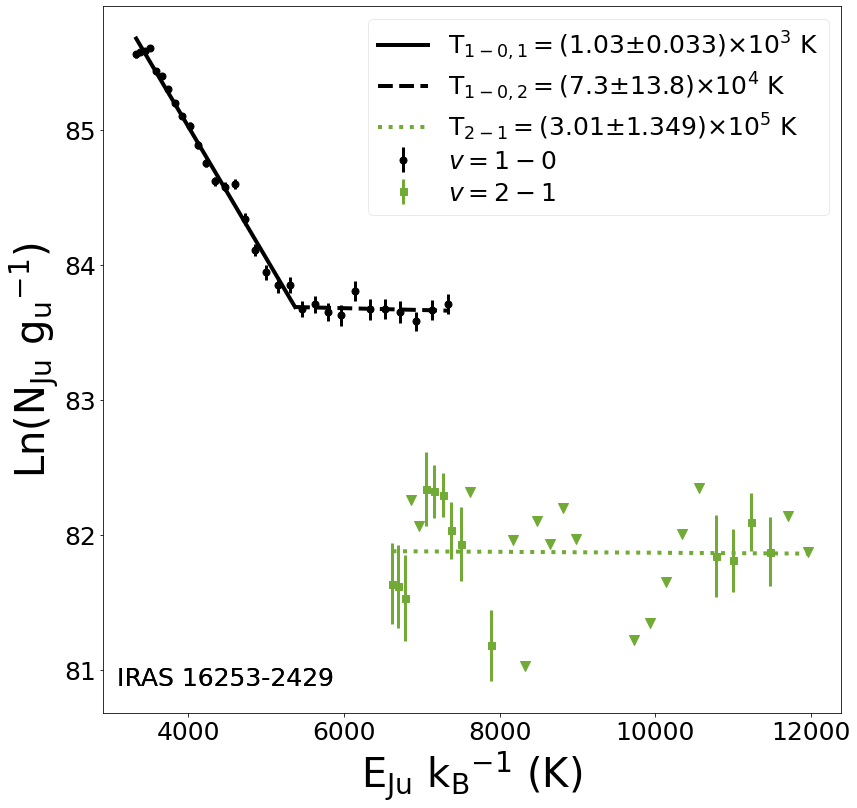

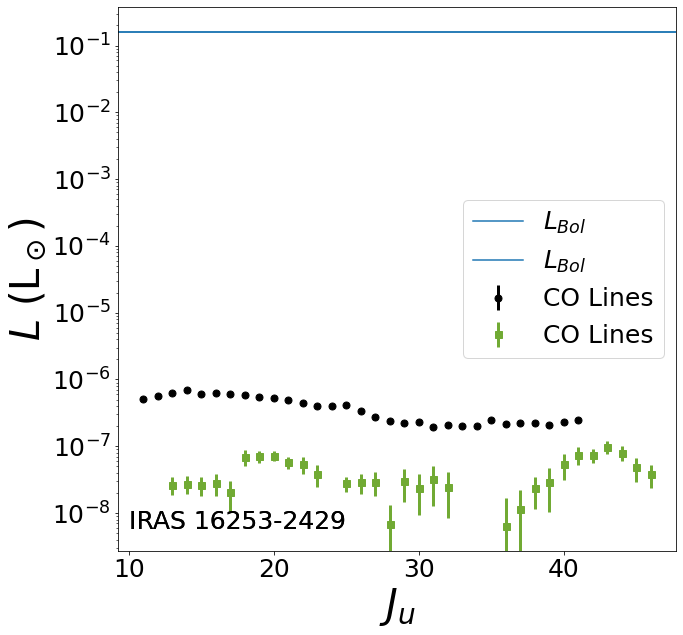

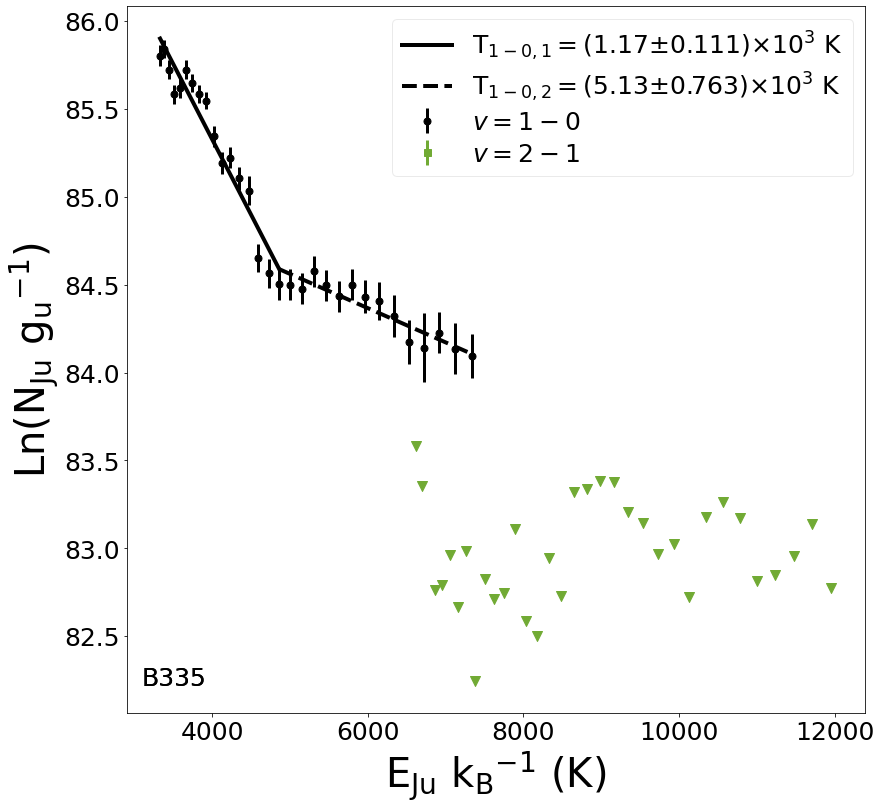

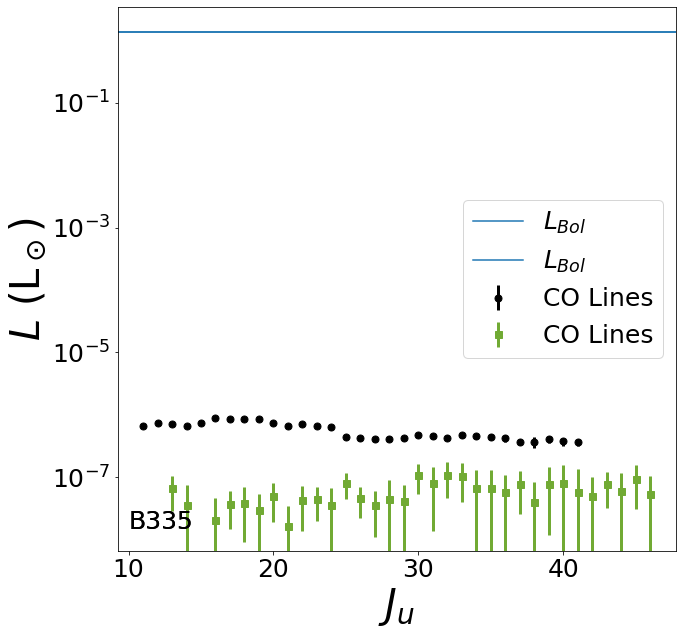

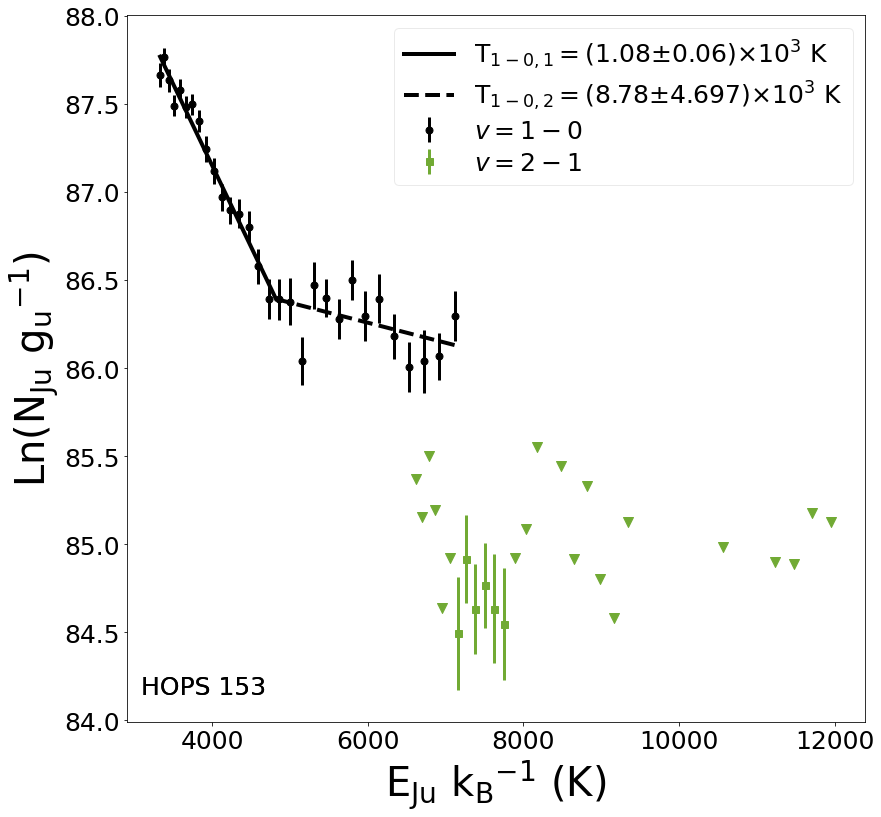

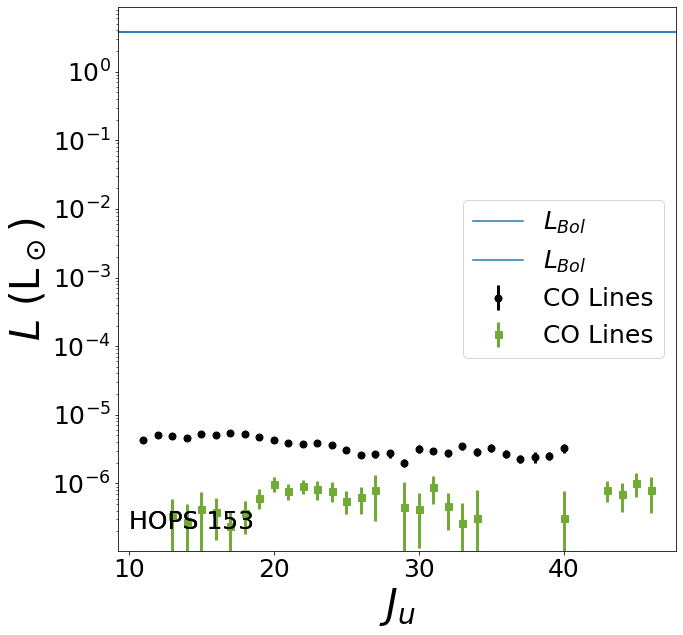

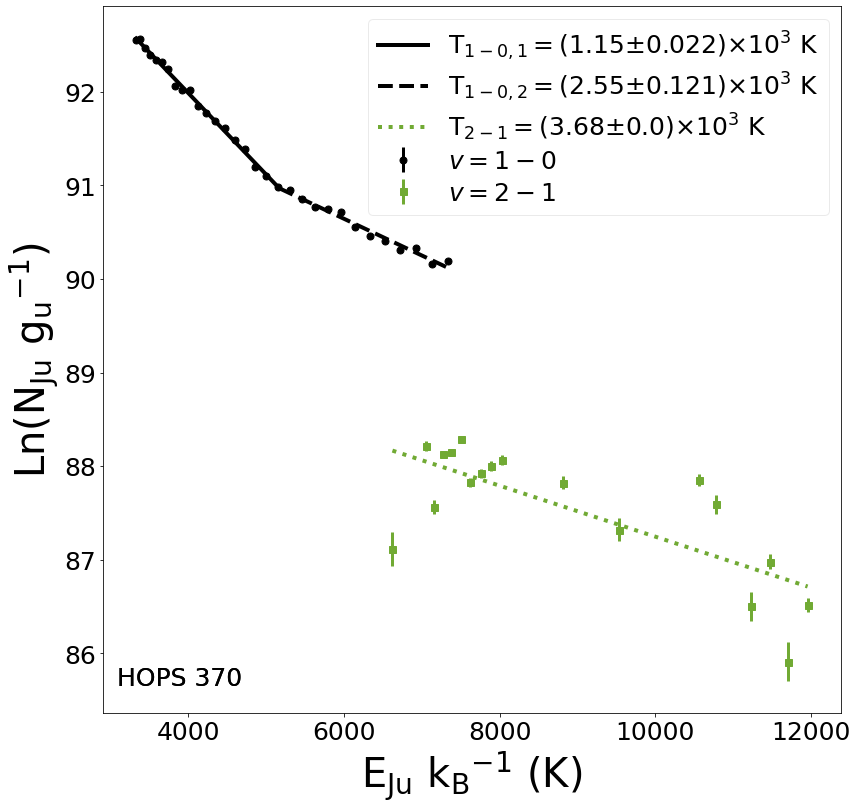

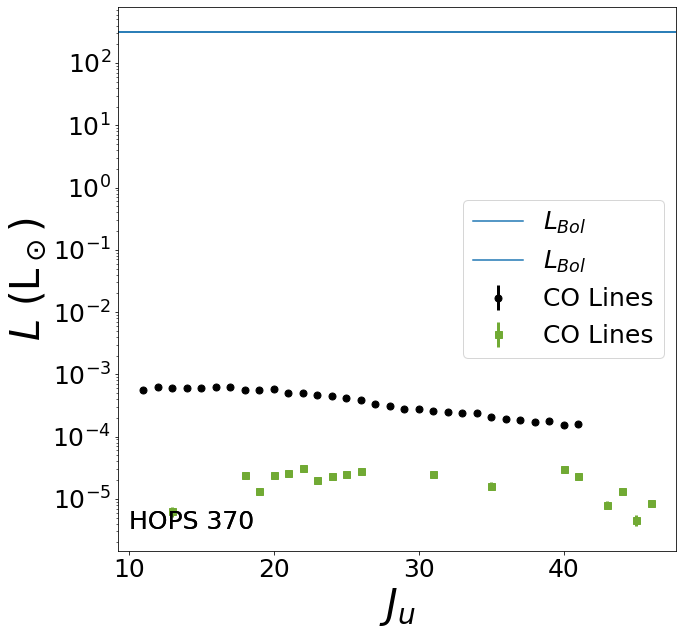

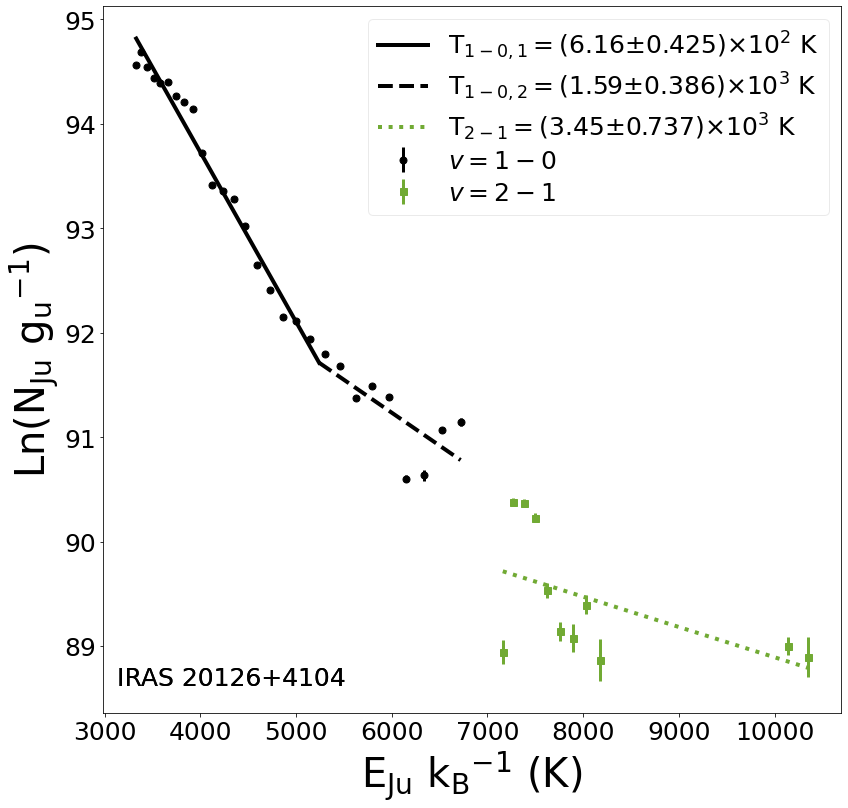

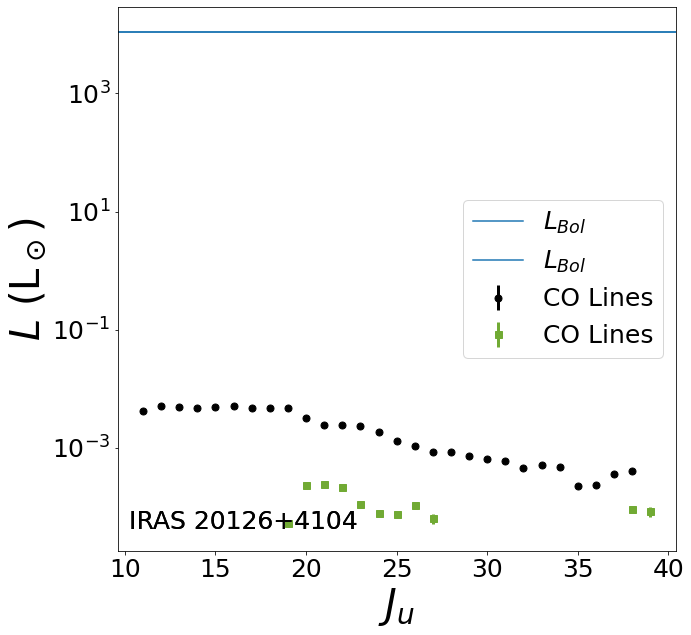

In [25]:
# plot figures of everything...more complicated so done here instead of separate panels as...
# horizontally: extinction plot (histogram or spectrum), rotation diagram
# vertically: each source...

#need to filter out runtimewarnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

#input values, such as wavelength resolution for our lookup tables
v_list = ['v = 1 - 0', 'v = 2 - 1']
num_breakpoints = [2, 1]
nbins_list = [15, 10, 10, 15, 15]
av_colors = ['xkcd:mango', 'xkcd:light blue']
# av_legend_locs = ['upper right', 'upper left', 'upper left', 'upper left', 'upper right']
T_saved = []
N_intercept_saved = []
log_NJ_gJ_saved = []

#relating to rotaiton diagrams and plotting
# T_bound_low = [3.3e3, 3.3e3, 3.5e3, 3.3e3, 3.3e3]
linestyle_list = ['-', '--', ':'] #, '-.']
color_list = ['k', 'xkcd:leaf'] #, 'xkcd:maize']
marker_list = ['o', 's'] #, 'D']
T11_uncrounding_list = [3,3,3,3,3] #used to display round of rotational temperatures on plots
T12_uncrounding_list = [1,3,3,3,3]
T2_uncrounding_list = [3,0,0,3,3]

#need the data for later when plotting line luminosities
Lbol_list = np.array([0.16, 1.36, 3.8, 315.7, 1.1e4]) #in Lsun

#loop over each protostar
fig_path = 'CentralSource_CO/'
for j in range(len(protostar_names)):
    print(protostar_names[j])

    fig = plt.figure(figsize=(45, 13)) #setup a figure

    # #extinctions
    # ax_extinction = fig.add_subplot(131)
    # ax_extinction.set_xlabel(r'$\rm \Sigma_{H} \ (\times {10}^{22} \ {cm}^{-2})$', fontsize=40)     #if histogram of Av do
    # ax_extinction.set_ylabel('Count', fontsize=40)
    # ax_extinction.tick_params(axis='both', which='major', labelsize=25)  

    # #extinction histograms - we only need to do this once
    # _ = ax_extinction.hist(filtered_Sigma_col_arr[j]/1e22, bins='auto', color='xkcd:maize', alpha=1.0, \
    #                     label=protostar_names[j])  # arguments are passed to np.histogram, note auto bins?
    # ax_extinction.locator_params(axis='y', integer=True)
    # ax_extinction.axvline(avg_Sigma_col_arr[j]/1e22, color='k', linestyle='--', label='Mean') #for unc, can use avg_Sigma_col_unc_arr
    # ax_extinction.legend(loc='best', fontsize=25)

    #rotation diagrams
    ax_rotation = fig.add_subplot(132)
    ax_rotation.set_xlabel(r'$\rm E_{Ju} \ {k_B}^{-1} \ (K)$', fontsize=40) # (E_{Ju} - E_{Ju=0})
    ax_rotation.set_ylabel(r'$\rm Ln(N_{Ju} \ {g_u}^{-1})$', fontsize=40)
    ax_rotation.tick_params(axis='both', which='major', labelsize=25)


    #make a separate figure to plot luminosities as a check for how the extinciton correction functions
    fig_lum_ext = plt.figure(figsize=(10,10))
    ax_lum_ext = fig_lum_ext.add_subplot(111)
    ax_lum_ext.set_xlabel(r'$J_u$', fontsize=40)
    ax_lum_ext.set_ylabel(r'$L \ \rm{(L_\odot)}$', fontsize=40)
    ax_lum_ext.tick_params(axis='both', which='major', labelsize=25)

    #for each protostar, check for different v states
    for v_counter, v in enumerate(v_list):
        co_j_list = []
        co_r_lam_list = []
        co_p_lam_list = []
        co_r_flux_list = []
        co_p_flux_list = []
        co_r_unc_list = []
        co_p_unc_list = []

        p_match = [o for o in latex_formatted_data if ('P' in o[1] and v in o[1])] #check for P state and v state, will need as we go...
        #for each v state, go through the R branch lines to find the associated P branch lines
        for i in range(len(latex_formatted_data)): #inefficient as we don't have to search through the whole list, but being basic for now
            #we need to check which line we're handling
            co_str = latex_formatted_data[i][1] #the string for a given line

            #only continue on certain conditions for R
            if co_str.find('R') >= 0 and co_str.find(v) >= 0 and v == v_list[0]:
                #useful CO values derived just from R-branch lines of a certain v state
                co_r_num = int(latex_formatted_data[i][1][-2:]) #which r-branch line?
                co_j = co_r_num - 1 #which j then? delta_J in R branch is 1, so we need to subtract 1 to get J!

                #search for the associated P-branch line
                for p in p_match:
                    #need these to check if a valid comparison can be made
                    co_p_num = int(p[1][-2:]) #which r-branch line?
                    co_r_flux_unc_str = latex_formatted_data[i][j+2].split(' \\\\')[0]
                    co_p_flux_unc_str = p[j+2].split(' \\\\')[0]

                    #if we have a match then...store values!
                    if co_p_num == co_j - 1 and p[1].find(v) >= 0 and co_r_flux_unc_str != '--' and co_p_flux_unc_str != '--' and co_j > 10:
                        #getting fluxes and uncertainties in R branch
                        co_r_lam = float(latex_formatted_data[i][0])
                        co_r_flux = float(co_r_flux_unc_str.split('$')[0]) * flux_norm_list[j]
                        co_r_unc = float(co_r_flux_unc_str.split('$')[-1]) * flux_norm_list[j]
                        #same in p branch
                        co_p_lam = float(p[0])
                        co_p_flux = float(co_p_flux_unc_str.split('$')[0]) * flux_norm_list[j]
                        co_p_unc = float(co_p_flux_unc_str.split('$')[-1]) * flux_norm_list[j]

                        #separate flux data into lists
                        co_j_list.append(co_j)
                        co_r_lam_list.append(co_r_lam)
                        co_p_lam_list.append(co_p_lam)
                        co_r_flux_list.append(co_r_flux)
                        co_p_flux_list.append(co_p_flux)
                        co_r_unc_list.append(co_r_unc)
                        co_p_unc_list.append(co_p_unc)

            #for vibrationally excited state, we just directly use values since no pairs            
            elif v == v_list[1] and co_str.find(v) >= 0 and latex_formatted_data[i][j+2].split(' \\\\')[0] != '--' and int(latex_formatted_data[i][1][-2:]) > 13:

                if co_str.find('R') >= 0:
                    #grab data
                    co_num = int(latex_formatted_data[i][1][-2:]) #which r-branch line?
                    co_j = co_num - 1 #which j then? delta_J in R branch is 1, so we need to subtract 1 to get J!
                    co_r_flux_unc_str = latex_formatted_data[i][j+2].split(' \\\\')[0]
                    #getting fluxes and uncertainties in R branch
                    co_r_lam = float(latex_formatted_data[i][0])
                    co_r_flux = float(co_r_flux_unc_str.split('$')[0]) * flux_norm_list[j]
                    co_r_unc = float(co_r_flux_unc_str.split('$')[-1]) * flux_norm_list[j]
                    #and store
                    co_j_list.append(co_j)
                    co_r_lam_list.append(co_r_lam)
                    co_r_flux_list.append(co_r_flux)
                    co_r_unc_list.append(co_r_unc)
                
                elif co_str.find('P') >= 0:
                    #grab data
                    co_num = int(latex_formatted_data[i][1][-2:]) #which r-branch line?
                    co_j = co_num - 1 #which j then? delta_J in R branch is 1, so we need to subtract 1 to get J!
                    co_p_flux_unc_str = latex_formatted_data[i][j+2].split(' \\\\')[0]
                    #getting fluxes and uncertainties in P branch
                    co_p_lam = float(latex_formatted_data[i][0])
                    co_p_flux = float(co_p_flux_unc_str.split('$')[0]) * flux_norm_list[j]
                    co_p_unc = float(co_p_flux_unc_str.split('$')[-1]) * flux_norm_list[j]
                    #and store
                    co_j_list.append(co_j)
                    co_p_lam_list.append(co_p_lam)
                    co_p_flux_list.append(co_p_flux)
                    co_p_unc_list.append(co_p_unc)     

        #now can use lists! before resetting for next protostar and/or v-state; first make sure arrays are numpy...
        co_j_list = np.array(co_j_list)
        co_r_lam_list = np.array(co_r_lam_list)
        co_p_lam_list = np.array(co_p_lam_list)
        co_r_flux_list = np.array(co_r_flux_list)
        co_p_flux_list = np.array(co_p_flux_list)
        co_r_unc_list = np.array(co_r_unc_list)
        co_p_unc_list = np.array(co_p_unc_list)

        #some useful ratios and propagated the ratio of uncertainties for later too
        # co_r_p_ratio_list = co_r_flux_list / co_p_flux_list #note if conversion done here
        # co_err_r_p_ratio_list = co_r_p_ratio_list * np.sqrt( (co_r_unc_list/co_r_flux_list)**2. + (co_p_unc_list/co_p_flux_list)**2.) #note conversion done here

        #p-branch
        co_A_ij_p = [] #list of indices for use in looking up wavelengths and matching what we have to the lab properties
        co_E_p = []
        co_g_p = []
        for k in range(len(co_p_lam_list)):
            idx = np.argmin([np.abs(co_p_lam_list[k] - lam) for lam in co_lab_props[co_lab_columns[0]]])
            co_A_ij_p.append(co_lab_props[co_lab_columns[1]][idx]) #apply indices to and lookup in table of lab properties
            co_E_p.append(co_lab_props[co_lab_columns[2]][idx]) #apply indices to and lookup in table of lab properties
            co_g_p.append(co_lab_props[co_lab_columns[3]][idx]) #apply indices to and lookup in table of lab properties
        co_A_ij_p = np.array(co_A_ij_p)
        co_E_p = np.array(co_E_p)
        co_g_p = np.array(co_g_p)

        #before rotation diagram, need to remake some constants and get tau
        #tau here is equal to Sigma * sigma...like column density * cross section
        #apply the average for Sigma here
        tau_p_lam_arr = avg_Sigma_col_arr[j] * vs(co_p_lam_list) # avg_tau_arr[j]

        #now actually calculate values for the rotation diagram here
        hc_lamP_cgs = hc_cgs / (1e-4*co_p_lam_list)
        # L_J =  [aperture_area_cm[i] * np.array(co_r_flux_list[i][8:][::-1] + co_p_flux_list[i][1:]) * np.exp(tau_mean_list[i]) * 4.0*np.pi*dist_list[i]**2. for i in range(len(protostar_list))]
        # NJ_gJ_ratio = (1.0 / hc_lamR_cgs* co_r_flux_sorted*np.exp(tau_r_ext_list)/(co_A_ij_r * co_g_r)
                    # + 1.0 / hc_lamP_cgs*co_p_flux_sorted*np.exp(tau_p_ext_list)/(co_A_ij_p * co_g_p) ) \
                    #     * 0.5 * 4.0*np.pi*dist_list[i]**2.  # if you want to use a mask .. np.nanmean(tau_p_ext_list[passed_threshold])
        # log_NJ_gJ_ratio = np.log(NJ_gJ_ratio)
        # log_NJ_gJ_ratio = [np.log(NJ_gJ_ratio[passed_threshold]) for i in range(len(NJ_gJ_ratio))]

        avg_luminosity_list = [] #to check the de-extincted luminosities
        avg_luminosity_err_list = []
        if v_counter == -1: #currently skip this step
            #look up the co lab properties we need and split them into r and p branches for use in calculations
            #column_names[0] is 'Wv, microns', the first column of the co lab properties
            #wave_lookup_res is at the start of this code block and is about the minimum allowed
            #r-branch
            co_A_ij_r = [] #list of indices for use in looking up wavelengths and matching what we have to the lab properties
            co_E_r = []
            co_g_r = []
            for k in range(len(co_r_lam_list)):
                idx = np.argmin([np.abs(co_r_lam_list[k] - lam) for lam in co_lab_props[co_lab_columns[0]]])
                co_A_ij_r.append(co_lab_props[co_lab_columns[1]][idx]) #apply indices to and lookup in table of lab properties
                co_E_r.append(co_lab_props[co_lab_columns[2]][idx]) #apply indices to and lookup in table of lab properties
                co_g_r.append(co_lab_props[co_lab_columns[3]][idx]) #apply indices to and lookup in table of lab properties
            co_A_ij_r = np.array(co_A_ij_r)
            co_E_r = np.array(co_E_r)
            co_g_r = np.array(co_g_r)
            #tau in r-branch
            tau_r_lam_arr = avg_Sigma_col_arr[j] * vs(co_r_lam_list) # avg_tau_arr[j] 
            #const needed in r-branch
            hc_lamR_cgs = hc_cgs / (1e-4*co_r_lam_list) #note the 1e-4 for microns to cm; doing hc/lambda instead of h * nu

            p_NJ_gJ_ratio = []
            r_NJ_gJ_ratio = []
            avg_NJ_gJ_ratio = []
            avg_NJ_gJ_err = []
            p_NJ_gJ_err = []
            for flux_ind in range(len(co_r_flux_list)):
                #for checking luminosity and extinction correction
                if co_j_list[flux_ind] == 25: # np.min(co_j_list)
                    print('J: ', co_j_list[flux_ind])
                    print('fluxes: ', co_r_flux_list[flux_ind], co_p_flux_list[flux_ind])
                    print('tau: ', tau_r_lam_arr[flux_ind], tau_p_lam_arr[flux_ind])
                    print('tau_diff:', tau_r_lam_arr[flux_ind] - tau_p_lam_arr[flux_ind])
                    print('CO_L: ', co_r_flux_list[flux_ind]*np.exp(tau_r_lam_arr[flux_ind])*4.0*np.pi*dist_list[j]**2., co_p_flux_list[flux_ind]*np.exp(tau_p_lam_arr[flux_ind])*4.0*np.pi*dist_list[j]**2.)
                avg_luminosity_list.append(0.5 * (co_r_flux_list[flux_ind]*np.exp(tau_r_lam_arr[flux_ind])*4.0*np.pi*dist_list[j]**2. + co_p_flux_list[flux_ind]*np.exp(tau_p_lam_arr[flux_ind])*4.0*np.pi*dist_list[j]**2.))
                avg_luminosity_err_list.append(np.sqrt((co_r_unc_list[flux_ind]*np.exp(tau_r_lam_arr[flux_ind]))**2.0 + (co_p_unc_list[flux_ind]*np.exp(tau_p_lam_arr[flux_ind]))**2.0) * 4.0*np.pi*dist_list[j]**2.) #ignoring covariance and variance in distance, extinction

                #if neither is nan, then we can proceed to averaging
                avg_NJ_gJ_ratio.append((1.0 / hc_lamR_cgs[flux_ind]* co_r_flux_list[flux_ind]*np.exp(tau_r_lam_arr[flux_ind])/(co_A_ij_r[flux_ind] * co_g_r[flux_ind])
                            + 1.0 / hc_lamP_cgs[flux_ind]*co_p_flux_list[flux_ind]*np.exp(tau_p_lam_arr[flux_ind])/(co_A_ij_p[flux_ind] * co_g_p[flux_ind]) ) \
                                * 0.5 * 4.0*np.pi*dist_list[j]**2.) # if you want to use a mask .. np.nanmean(tau_p_ext_list[passed_threshold])
                #also find error in NJ!
                avg_NJ_gJ_err.append( np.sqrt( (1.0 / hc_lamR_cgs[flux_ind]* co_r_flux_list[flux_ind]*np.exp(tau_r_lam_arr[flux_ind])*np.sqrt((co_r_unc_list[flux_ind]/co_r_flux_list[flux_ind])**2.0 #+ (tau_mean_err_list)**2.0 \ 
                                                                                                                    ) / (co_A_ij_r[flux_ind] * co_g_r[flux_ind]))**2.0 \
                            + (1.0 / hc_lamP_cgs[flux_ind] * co_p_flux_list[flux_ind]*np.exp(tau_p_lam_arr[flux_ind])*np.sqrt((co_p_unc_list[flux_ind]/co_p_flux_list[flux_ind])**2.0 #+ (tau_mean_err_list)**2.0  \
                                                                                                    ) / (co_A_ij_p[flux_ind] * co_g_p[flux_ind]))**2.0 ) \
                                * 0.5 * 4.0*np.pi*dist_list[j]**2.) #IMPORTANT: ignoring covariance...
                # print('both', i, source_ind, j, flux_ind, co_r_flux_sorted[flux_ind], co_p_flux_sorted[flux_ind], avg_NJ_gJ_ratio[flux_ind])

                #now try separately in p branch and r branch because people asked...
                r_NJ_gJ_ratio.append((1.0 / hc_lamR_cgs[flux_ind]* co_r_flux_list[flux_ind]*np.exp(tau_r_lam_arr[flux_ind])/(co_A_ij_r[flux_ind] * co_g_r[flux_ind]) ) \
                                * 4.0*np.pi*dist_list[j]**2.)
                p_NJ_gJ_ratio.append((1.0 / hc_lamP_cgs[flux_ind]*co_p_flux_list[flux_ind]*np.exp(tau_p_lam_arr[flux_ind])/(co_A_ij_p[flux_ind] * co_g_p[flux_ind]) ) \
                                * 4.0*np.pi*dist_list[j]**2.)

            #constructing the luminosity plot (just in v=1-0, which is brightest and most problematic)
            avg_luminosity_list = np.array(avg_luminosity_list) / 3.846e33 #divided by 1 Lsun in erg/sec as this is all done in CGS
            avg_luminosity_err_list = np.array(avg_luminosity_err_list) / 3.846e33 #divided by 1 Lsun in erg/sec as this is all done in CGS
            ax_lum_ext.errorbar(co_j_list, avg_luminosity_list, xerr=None, yerr=avg_luminosity_err_list, ls='none', marker=marker_list[v_counter], markersize=7, color=color_list[v_counter], elinewidth=3, label='CO Lines')
            ax_lum_ext.axhline(Lbol_list[j], label=r'$L_{Bol}$')

            #collecting the values for the rotation diagram
            avg_log_NJ_gJ_err = np.array(avg_NJ_gJ_err) / np.array(avg_NJ_gJ_ratio) #error for a logged value when propagated turns out to be dx/x when no other constants are present...
            avg_log_NJ_gJ_ratio = np.log(np.array(avg_NJ_gJ_ratio))
            log_r_NJ_gJ_ratio = np.log(np.array(r_NJ_gJ_ratio))
            log_p_NJ_gJ_ratio = np.log(np.array(p_NJ_gJ_ratio))

            #and plot for the separate branches if someone wants...
            #define energy levels for x-axis and plot data
            E_u_J_avg = (co_E_r + co_E_p)/2. #[passed_threshold[0]] #took mean to triple check I have correct indices...if correct, these two should match!
            # E_u_J_zeroing = E_u_J_avg - np.min(E_u_J_avg) #if you want to zero your plot, helps for showing intercept and such
            
            #turn these on if you'd like to plot r-branch and p-branch separately!!!
            # ax_rotation.scatter(E_u_J_avg, log_r_NJ_gJ_ratio)
            # ax_rotation.scatter(E_u_J_avg, log_p_NJ_gJ_ratio)
            
        else: #v=2-1 case or if r-branch doesn't work...
            #computing luminosities
            avg_luminosity_list.append(co_p_flux_list*np.exp(tau_p_lam_arr)*4.0*np.pi*dist_list[j]**2.)
            avg_luminosity_err_list.append(np.sqrt((co_p_unc_list*np.exp(tau_p_lam_arr))**2.0) * 4.0*np.pi*dist_list[j]**2.) #ignoring covariance and variance in distance, extinction
            avg_luminosity_list = np.array(avg_luminosity_list)[0] / 3.846e33 #divided by 1 Lsun in erg/sec as this is all done in CGS
            avg_luminosity_err_list = np.array(avg_luminosity_err_list)[0] / 3.846e33 #divided by 1 Lsun in erg/sec as this is all done in CGS
            ax_lum_ext.errorbar(co_j_list, avg_luminosity_list, xerr=None, yerr=avg_luminosity_err_list, ls='none', marker=marker_list[v_counter], markersize=7, color=color_list[v_counter], elinewidth=3, label='CO Lines')
            ax_lum_ext.axhline(Lbol_list[j], label=r'$L_{Bol}$')


            #just do p-branch unless we find r-branch lines
            avg_NJ_gJ_ratio = ((1.0 / hc_lamP_cgs*co_p_flux_list*np.exp(tau_p_lam_arr)/(co_A_ij_p * co_g_p) ) \
                            * 4.0*np.pi*dist_list[j]**2.) # if you want to use a mask .. np.nanmean(tau_p_ext_list[passed_threshold])
            #also find error in NJ!
            avg_NJ_gJ_err = ( np.sqrt( (1.0 / hc_lamP_cgs * co_p_flux_list*np.exp(tau_p_lam_arr)*np.sqrt((co_p_unc_list/co_p_flux_list)**2.0) / (co_A_ij_p * co_g_p))**2.0 ) \
                            * 4.0*np.pi*dist_list[j]**2.) #IMPORTANT: ignoring covariance...
            # print('both', i, source_ind, j, flux_ind, co_r_flux_sorted[flux_ind], co_p_flux_sorted[flux_ind], avg_NJ_gJ_ratio[flux_ind])

            avg_log_NJ_gJ_err = np.array(avg_NJ_gJ_err) / np.array(avg_NJ_gJ_ratio) #error for a logged value when propagated turns out to be dx/x when no other constants are present...
            avg_log_NJ_gJ_ratio = np.log(np.array(avg_NJ_gJ_ratio))

            #and plot
            #define energy levels for x-axis and plot data
            E_u_J_avg = co_E_p #[passed_threshold[0]] #took mean to triple check I have correct indices...if correct, these two should match!
            # E_u_J_zeroing = E_u_J_avg - np.min(E_u_J_avg) #if you want to zero your plot, helps for showing intercept and such

        #filter out by S/N
        # if v == 'v = 2 - 1':
        #     print(protostar_names[j], v, co_p_flux_list/co_p_unc_list, avg_log_NJ_gJ_ratio, avg_log_NJ_gJ_err)
        #     avg_log_NJ_gJ_ratio[co_p_flux_list/co_p_unc_list < 3] = np.nan
        #     avg_log_NJ_gJ_err[co_p_flux_list/co_p_unc_list < 3] = np.nan
        #     E_u_J_avg[co_p_flux_list/co_p_unc_list < 3] = np.nan

        #now can save logNJ_gJ and the associated energies for later
        log_NJ_gJ_saved.append([v, co_j_list, avg_log_NJ_gJ_ratio, E_u_J_avg]), #J, logNJ, EJ

        #a sample rotation diagram for the apertures
        if v != 'v = 2 - 1':
            # plt.scatter(E_u_J_zeroing, log_NJ_gJ_ratio, color='gray', marker='v', s=10, label=str(v_list[j][0]) + ' - ' + str(j) + ', Exact Av')
            ax_rotation.errorbar(E_u_J_avg, avg_log_NJ_gJ_ratio, xerr=None, yerr=avg_log_NJ_gJ_err, \
                                ls='none', marker=marker_list[v_counter], markersize=7, color=color_list[v_counter], elinewidth=3, \
                                    label=r'$' + v + r'$') # label=r'Measurements in $\rm J_{u}$ (Mean $A_V$)')         
        else: #for the case of v=2-1
            high_sigma_mask = [co_p_flux_list/co_p_unc_list > 3] #normal cases:)
            ax_rotation.errorbar(E_u_J_avg[high_sigma_mask], avg_log_NJ_gJ_ratio[high_sigma_mask], xerr=None, yerr=avg_log_NJ_gJ_err[high_sigma_mask], \
                                ls='none', marker=marker_list[v_counter], markersize=7, color=color_list[v_counter], elinewidth=3, \
                                    label=r'$' + v + r'$') # label=r'Measurements in $\rm J_{u}$ (Mean $A_V$)') 
            low_sigma_mask = [co_p_flux_list/co_p_unc_list < 3] #low snr...mostly b335, establish 3*sigma level...
            low_snr_3sig_logratios = np.log(np.array((1.0 / hc_lamP_cgs[low_sigma_mask]*(co_p_flux_list[low_sigma_mask]+3.0*co_p_unc_list[low_sigma_mask])*np.exp(tau_p_lam_arr[low_sigma_mask])/(co_A_ij_p[low_sigma_mask] * co_g_p[low_sigma_mask]) ) \
                * 4.0*np.pi*dist_list[j]**2.)) # if you want to use a mask .. np.nanmean(tau_p_ext_list[passed_threshold])
            ax_rotation.scatter(E_u_J_avg[low_sigma_mask], low_snr_3sig_logratios, marker='v', s=100, color=color_list[v_counter]) #, label=r'$' + v + r'$' + 'Upper Limits') # label=r'Measurements in $\rm J_{u}$ (Mean $A_V$)')                 

            #also correct data to be upper limits...
            avg_log_NJ_gJ_ratio[low_sigma_mask] = low_snr_3sig_logratios
            avg_log_NJ_gJ_err[low_sigma_mask] = 10.0 * avg_log_NJ_gJ_err[low_sigma_mask]

        #fit and plot the lines, first masking, but not explicitly, just from excluding points earlier
        valid = ~np.isnan(avg_log_NJ_gJ_ratio) #~(np.isnan(E_u_J_avg) | np.isnan(avg_log_NJ_gJ_ratio))
        if num_breakpoints[v_counter] > 1: #hops153 breaks with 2 linear fits here
            px, py = segments_fit(E_u_J_avg[valid], avg_log_NJ_gJ_ratio[valid], num_breakpoints[0])
            T1 = round(-1.0 / ((py[1] - py[0]) / (px[1] - px[0])))
            T2 = round(-1.0 / ((py[2] - py[1]) / (px[2] - px[1])))

            #n from intercepts relating to rotational partition function    
            intercept1 = py[0] - ((py[1] - py[0]) / (px[1] - px[0])) * px[0]
            intercept2 = py[1] - ((py[2] - py[1]) / (px[2] - px[1])) * px[1]
            ntot1 = np.exp(intercept1 + np.log(Z_J_const * T1))
            ntot2 = np.exp(intercept2 + np.log(Z_J_const * T2))

            #storing values for later use in vibrational v=1 to v=0 extrapolation by boltzmann equation
            T_saved.append([T1, T2])
            N_intercept_saved.append([ntot1, ntot2])
            print('relevant fit values: ', v, T1, T2, ntot1, ntot2)            #rot_ind if one day want to show transition points
            # print('partition functions: ', Z_J_const * T1, Z_J_const * T2)

            #compute uncertainties and print output
            mask_t1_break = E_u_J_avg < px[1]
            print('break points: ', E_u_J_avg[valid][mask_t1_break])
            p_example, p_cov = curve_fit(linear_fitter, E_u_J_avg[valid][mask_t1_break], avg_log_NJ_gJ_ratio[valid][mask_t1_break], p0=(intercept1, ntot1), sigma=avg_log_NJ_gJ_err[mask_t1_break])
            unc1 = np.sqrt(np.diag(p_cov))
            print('Formally fitting v=1-0, T1 in curve_fit: ', p_example[0], unc1[0])
            mask_t2_break = E_u_J_avg > px[1]
            p_example, p_cov = curve_fit(linear_fitter, E_u_J_avg[valid][mask_t2_break], avg_log_NJ_gJ_ratio[valid][mask_t2_break], p0=(intercept2, ntot2), sigma=avg_log_NJ_gJ_err[mask_t2_break])
            unc2 = np.sqrt(np.diag(p_cov))
            print('Formally fitting v=1-0, T2 in curve_fit: ', p_example[0], unc2[0])

            #with uncertainties done, can plot!
            T1_1_orderofmag = np.floor(np.log10(T1)) 
            T1_1_label = '(' + str(round(T1/10**T1_1_orderofmag,2))+r'$\pm$'+str(round(unc1[0]/10**T1_1_orderofmag,T11_uncrounding_list[j]))  +')'+ r'$\times$'+str(10)+r'${}^{%d}$' % T1_1_orderofmag
            T1_2_orderofmag = np.floor(np.log10(T2)) 
            T1_2_label = '(' + str(round(T2/10**T1_2_orderofmag,2))+r'$\pm$'+str(round(unc2[0]/10**T1_2_orderofmag,T12_uncrounding_list[j])) +')' + r'$\times$'+str(10)+r'${}^{%d}$' % T1_2_orderofmag
            ax_rotation.plot(px[0:2], py[0:2], linestyle=linestyle_list[0], linewidth=4, color = color_list[0], label=r'$\rm T_{1-0,1}=$' + T1_1_label  +' K') # , N = r'$\rm T_{1-0,1}=$' + str(round(T1,-2))+ r'$\pm$' + str(round(int(unc1[0]),-1)) +' K' ... '+str(p_sub_5k[0]))
            ax_rotation.plot(px[1:], py[1:], linestyle=linestyle_list[1], linewidth=4, color = color_list[0], label=r'$\rm T_{1-0,2}=$' + T1_2_label  +' K') #  r'$\rm T_{1-0,2}=$' + str(round(T2,-2))+ r'$\pm$' + str(round(int(unc2[0]),-1)) +' K' , N = '+str(p_sub_5k[0]))

        else:
            px, py = segments_fit(E_u_J_avg[valid], avg_log_NJ_gJ_ratio[valid], num_breakpoints[1])
            T1 = round(-1.0 / ((py[1] - py[0]) / (px[1] - px[0])))

            #n from intercepts relating to rotational partition function    
            intercept1 = py[0] - ((py[1] - py[0]) / (px[1] - px[0])) * px[0]
            ntot1 = np.exp(intercept1 + np.log(Z_J_const * T1))

            #storing values for later use in vibrational v=1 to v=0 extrapolation by boltzmann equation
            T_saved.append([T1])
            N_intercept_saved.append([ntot1])
            print(protostar_names[j], v, T1, ntot1)                    #rot_ind if one day want to show transition points

            #compute uncertainties and print output
            if j != 1 and j != 2: #can proceed as normal, enough data for a reasonable fit
                p_example, p_cov = curve_fit(linear_fitter, E_u_J_avg[valid], avg_log_NJ_gJ_ratio[valid], p0=(intercept1, ntot1), sigma=avg_log_NJ_gJ_err[valid], bounds=((0.0, 0.0), (1e100, 1e100)))
                unc = np.sqrt(np.diag(p_cov))
                print('Formally fitting v=2-1, T in curve_fit: ', p_example[0], unc[0])

                #with uncertainties done, can plot
                T1_orderofmag = np.floor(np.log10(T1)) 
                T1_label = '(' + str(round(T1/10**T1_orderofmag,2))+r'$\pm$'+str(round(unc[0]/10**T1_orderofmag,T2_uncrounding_list[j])) +')' + r'$\times$'+str(10)+r'${}^{%d}$' % T1_orderofmag

                ax_rotation.plot(px, py, linestyle=linestyle_list[v_counter+1], linewidth=4, color = color_list[v_counter], label=r'$\rm T_{2-1}=$' + T1_label  +' K') # , N = '+str(p_sub_5k[0])) r'$\rm T_{2-1}=$' + str(round(T1,-2))+ r'$\pm$' + str(round(int(unc[0]),-1))   +' K'
                
            else:
                model = LinearModel()

                # create a set of Parameters
                intercept1 = -1e-5
                ntot1 = np.exp(83.0)
            
                params = Parameters()
                params.add('slope', value= intercept1, max=0) #value is the initial condition
                params.add('intercept', value= ntot1, min=0)
                # params.add('d', value= 10.0, min=0) #min=0 prevents that d becomes negative

                # do fit, here with leastsq model
                # result = minimize(linear_fitter, params, args=(E_u_J_avg[valid], avg_log_NJ_gJ_ratio[valid]))
                # result = model.fit(avg_log_NJ_gJ_ratio[valid], params, x=E_u_J_avg[valid])

                # write error report
                # print(1.0 / result.params['slope'].value, 1.0 / result.params['slope'].stderr, result.params['intercept'].value, result.params['intercept'].stderr)


                # print(result.fit_report())


        #format the plot but only done once
        # if count == 1 and j >= 3:
        rot_leg = ax_rotation.legend(loc='upper right', fontsize=25, labelspacing=0.3, framealpha=0.4, columnspacing=0.5) #, ncol=2
        ax_rotation.annotate(protostar_names[j], (0.02, 0.04), horizontalalignment = 'left', \
                    xycoords='axes fraction', color='black', fontsize=25)
        # if count == 1 and j < 3:
        # rot_leg = ax_rotation.legend(loc='lower left', ncol=2, fontsize=25, labelspacing=0.3, framealpha=0.4, columnspacing=0.5)
        # ax_rotation.annotate(protostar_names[j], (0.99, 0.94), horizontalalignment = 'right', \
        #             xycoords='axes fraction', color='black', fontsize=25)                 
           
        rot_leg = ax_lum_ext.legend(loc='center right', fontsize=25)
        ax_lum_ext.annotate(protostar_names[j], (0.02, 0.04), horizontalalignment = 'left', \
                    xycoords='axes fraction', color='black', fontsize=25)
        ax_lum_ext.set_yscale('log')

    #save a figure
    fig.savefig(fig_path + 'CO_analysis_' + protostar_names[j].replace(' ', '_') + '.pdf', bbox_inches='tight')
    fig_lum_ext.savefig(fig_path + 'CO_luminosity_' + protostar_names[j].replace(' ', '_') + '.pdf', bbox_inches='tight')

# Final steps for discussion (ratios of vibrational states and matters of disk structure)

1189.3913715082895 492.56033636976895
2024.1887677105128 862.7577840128286
1536.0615440252886 1076.9717357878746
915.5532298883081 229.99663740891924
990.5666143601676 248.0173895770351


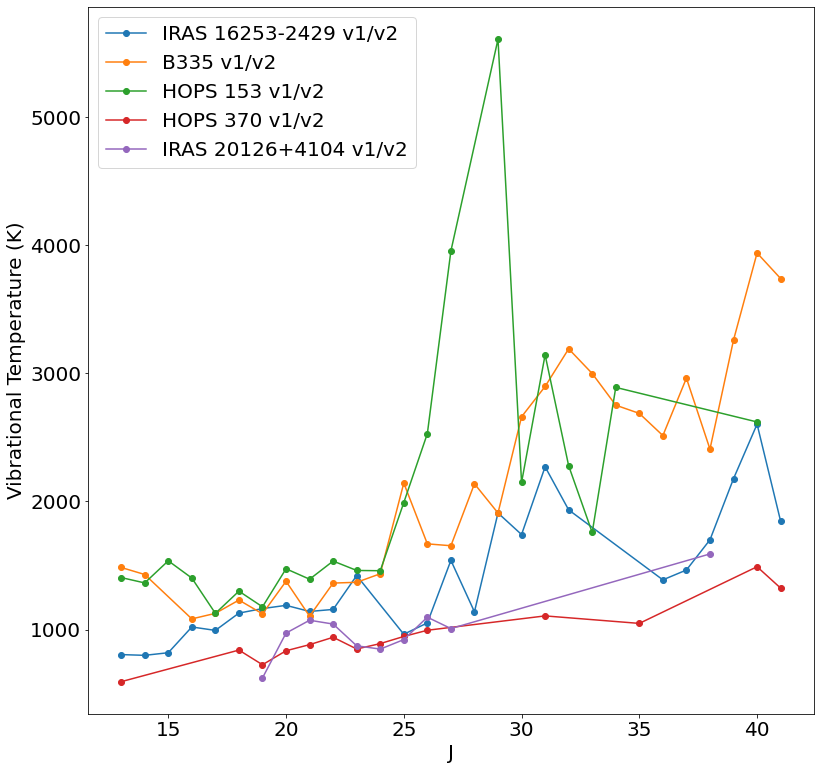

In [26]:
#first, an example calculation with vibrational states and boltzmann factors to check math
#then we output values for a table of gas mass and disk properties

#compute as function of temperature for each component...
'''
for co, we can do N(v=2)/N(v=1) and then N(v=3)/N(v=2) and see what we get
if sensible, this would act as measures of Tvib!
see https://phys.libretexts.org/Bookshelves/Astronomy__Cosmology/Stellar_Atmospheres_(Tatum)/08%3A_Boltzmann's_and_Saha's_Equations/8.04%3A_Boltzmann's_Equation
the boltzmann equation is Ni / Nj = gi/gj * exp(-delta_E / (kB * Tvib))
Then N2 / N1 * g1 / g2 = exp(-delta_E / (kB * Tvib))
log both sides and swap the T with the left side...
Then Tvib = -h*nui / kB / ln(N2/N1 * g1/g2)
And if we apply log law that ln(a^-1) = -ln(a), then...
Tvib = h * nui / kB / ln(N1/N2) if g2/g1 = 1
Then Tvib = (E/kB) / log((Ni / Nj)

In terms of uncertainty, we only have the uncertainty in the ln ratio, which is 
'''

#make figure
plt.figure(figsize=(13,13))

#loop over all stars
T_vib_list = []
T_vib_unc_list = []
for i in range(len(protostar_names)):
    #extract out values
    v, J_10, log_NJ_10, E_J_10 = log_NJ_gJ_saved[2*i]
    v, J_21, log_NJ_21, E_J_21  = log_NJ_gJ_saved[2*i+1]

    #sort values and matching J
    J_10_21 = []
    N_10_21 = []
    E_10_21 = []
    for j in range(len(J_10)):
        for k in range(len(J_21)):
            if J_10[j] == J_21[k]:
                J_10_21.append(J_10[j])
                N_10_21.append(log_NJ_10[j] - log_NJ_21[k])
                E_10_21.append(E_J_10[j] - E_J_21[k])

    J_10_21 = np.array(J_10_21)
    N_10_21 = np.array(N_10_21)
    E_10_21 = np.array(E_10_21)

    #compute positive vibrational temperatures
    T_v1_v2 = -E_10_21 / N_10_21

    #masking
    # J_10_21 = J_10_21[T_v1_v2 > 0]
    # E_10_21 = E_10_21[T_v1_v2 > 0]
    # N_10_21 = N_10_21[T_v1_v2 > 0]
    # T_v1_v2 = T_v1_v2[T_v1_v2 > 0]
    
    # print(J_10_21)
    # print(J_21_32)

    # print(np.nanmedian(T_v1_v2), np.nanmedian(T_v2_V3), 'avg tvib: ', np.mean([np.nanmedian(T_v1_v2), np.nanmedian(T_v2_V3)]))
    # print(np.nanstd(T_v1_v2, ddof=1), np.nanstd(T_v2_V3, ddof=1), 'avg unc: ', np.sqrt(np.nanstd(T_v1_v2, ddof=1)**2.0 + np.nanstd(T_v2_V3, ddof=1)**2.0))
    T_vib_list.append(np.mean([np.nanmedian(T_v1_v2)]))
    T_vib_unc_list.append(np.sqrt(np.nanstd(T_v1_v2, ddof=1)**2.0))
    print(np.mean([np.nanmedian(T_v1_v2)]), np.nanstd(T_v1_v2, ddof=1))
    # print(np.quantile(T_vib_list, [0.25, 0.75]))

    #plot logNratio vs. deltaE
    # if i >= 6:
    if i < 6:
        # slope, intercept, r_value, p_value, std_err = stats.linregress(-1.0/E_10_21, N_10_21)
        # plt.plot(-1.0/E_10_21, N_10_21, label=rot_diag_sources[i] + ' v1/v2', marker='o')
        # print(slope)  
        # plt.ylim(-25, 1)

        #plot T vs J
        plt.plot(J_10_21, T_v1_v2, label=protostar_names[i] + ' v1/v2', marker='o')
        # plt.ylim(1e2, 1e6)
        plt.ylabel('Vibrational Temperature (K)', fontsize=20)
        plt.xlabel('J', fontsize=20)
        # plt.yscale('log')

    #general formatting
    plt.locator_params(axis='x', integer=True)
    plt.legend(fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)  

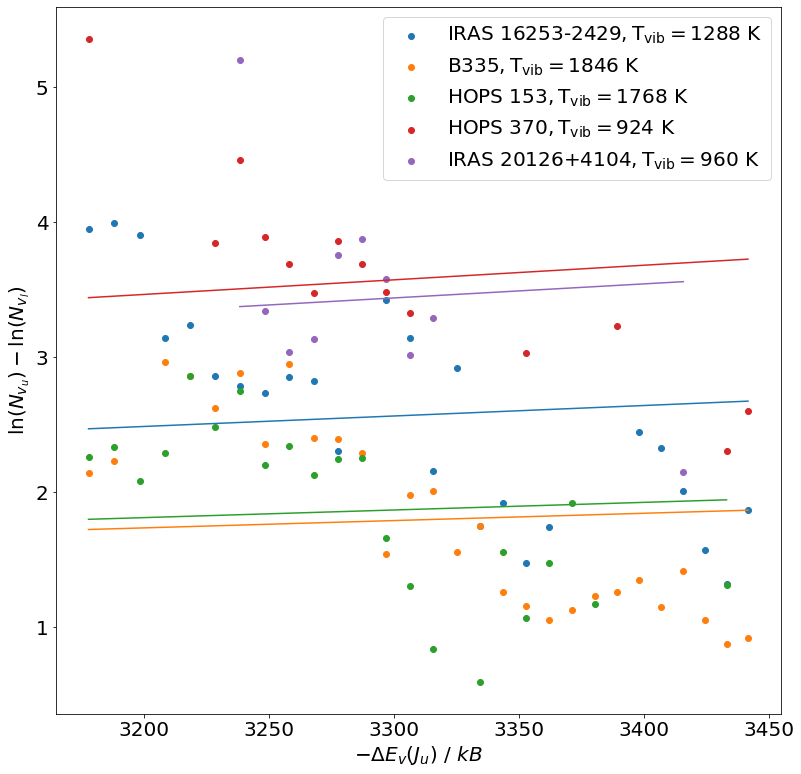

In [27]:
#repeat but trying a linear plot

#for line fitting
from scipy import stats

from scipy.optimize import curve_fit

def f(x, A): # this is your 'straight line' y=f(x)
    return A*x

#make figure
plt.figure(figsize=(13,13))

#loop over all stars
for i in range(len(protostar_names)):
    #extract out values
    v, J_10, log_NJ_10, E_J_10 = log_NJ_gJ_saved[2*i]
    v, J_21, log_NJ_21, E_J_21  = log_NJ_gJ_saved[2*i+1]

    #sort values and matching J
    J_10_21 = []
    N_10_21 = []
    E_10_21 = []
    for j in range(len(J_10)):
        for k in range(len(J_21)):
            if J_10[j] == J_21[k]:
                J_10_21.append(J_10[j])
                N_10_21.append(log_NJ_10[j] - log_NJ_21[k])
                E_10_21.append(E_J_10[j] - E_J_21[k])

    J_10_21 = np.array(J_10_21)
    N_10_21 = np.array(N_10_21)
    E_10_21 = np.array(E_10_21)

    #compute positive vibrational temperatures
    # T_v1_v2 = -E_10_21 / N_10_21

    #plot logNratio vs. deltaE
    # if i >= 6:
    if i < 6:
        # slope, intercept, r_value, p_value, std_err = stats.linregress(-E_10_21, N_10_21)
        # print('stats.linregress: ', 1.0 / slope)  #this should be T in Kelvin since slope = 1/T
        popt, pcov = curve_fit(f, -E_10_21, N_10_21)
        # print('curvefit: ', popt, 1.0/popt[0])
        # plt.ylim(-25, 1)

        #plot T vs J
        plt.scatter(-E_10_21, N_10_21, label=protostar_names[i] + r'$\rm , T_{vib} = $' + str(round(1.0/popt[0])) + ' K', marker='o')
        plt.plot(-E_10_21, popt * -E_10_21)
        plt.xlabel(r'$- \Delta E_v(J_u) \ / \ kB$', fontsize=20)
        plt.ylabel(r'${\rm ln}(N_{v_u}) - {\rm ln}(N_{v_l})$', fontsize=20)

    #general formatting
    plt.locator_params(axis='x', integer=True)
    plt.legend(fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)  

Test for partition function, Zv(T=3000K) =  1.5689406422404237
IRAS 16253-2429
1.083911522741775
2.848893626572734e+40
2.489147305480555e+41 7.00599881065707e+21
B335
1.2859679740688834
2.45939822440841e+40
3.72675386423413e+41 1.048938850784294e+22
HOPS 153
1.159975925949216
1.4117259558540193e+41
2.1456042864887926e+42 6.039056445628513e+22
HOPS 370
1.0373603063395986
7.114569505918883e+42
1.6954686410253695e+44 4.772096555465544e+24
IRAS 20126+4104
1.048572884112731
3.557700129380234e+43
1.09895794546935e+46 3.0931468145610516e+26


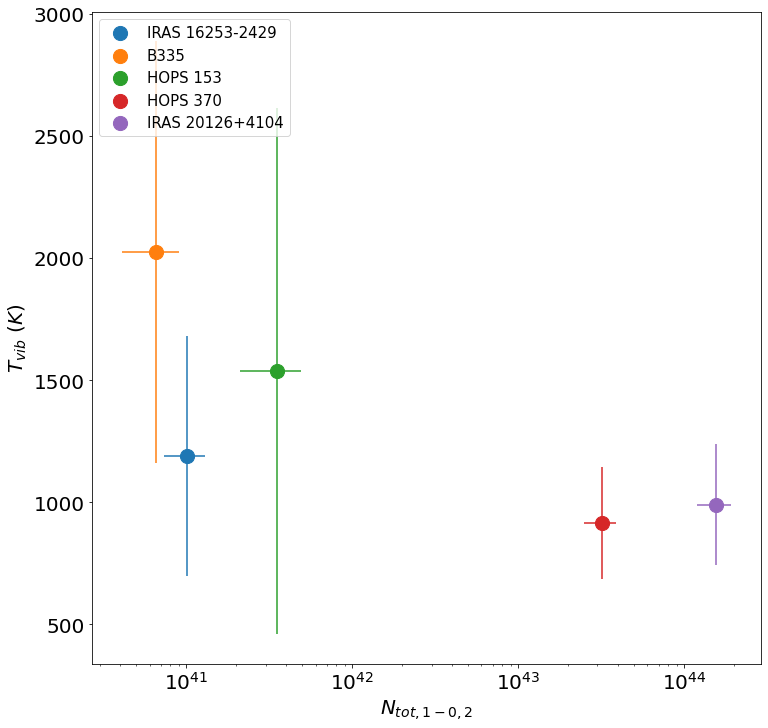

In [28]:
#vibrational constants
wavenum_v_CO = 2143.27156 #cm^-1 # see pg 76 of https://www.govinfo.gov/content/pkg/GOVPUB-C13-ce9e9f8bf57ba4aec0e1115a0bef0e38/pdf/GOVPUB-C13-ce9e9f8bf57ba4aec0e1115a0bef0e38.pdf or Table 56
E_v_CO = (3089+3084)/2 #averaging the J=0 and J=1 states to get close to the band center at ~4.67 microns (or P1)
Z_v_const = hc_cgs * wavenum_v_CO / k_B_cgs # equals h * c / kB, giving units of cm * K ... then I divide out the central wavelength of the whole forest, about 4.7 mic???
d_i = 1.0 #degeneracy in the excited v=1-0 state - it is a diatomic molecule! neither C nor O have spin
print('Test for partition function, Zv(T=3000K) = ', (1 - np.exp(-Z_v_const / 3000))**(-d_i))

#computing Z, E, and the prediction according to boltzmann 
# Z_v_0 = (1.0 - np.exp(-Z_v_const*p_above_5k[1]))**-d_i #notice that this approx only uses Z(all v) ~= Z(v=0)
# E_T_ratio = (1./p_above_5k[1] / E_v_CO) #notice that E is in units of kB. So can just take E/T or E * slope

#noting by hand from last cell
# T_vib_list = [5992.442502492737, 7430.287525269987, 5254.790392900535, 2313.668686394652, 3059.41709368204, 5511.6268905229335, \
#               7788.721883898603, 6235.997307874084, 5509.5592837127915, 5479.747486007946, 4562.102988904788]
# T_vib_list = [round(i, -2) for i in T_vib_list]
# T_vib_list = [370, 1320, 520, 580, 240, 270, 360, 320, 100, 730, 350]

#one last needed constant for masses
mass_units = 6e3 * 1.67e-24 * 2.809  #/ 1.899e30 # / 2e33 #jupiter masses

#looping, need some lists to fill
N_tot_10_1_list = []
M_gas_10_1_list = []
N_tot_10_2_list = []
M_gas_10_2_list = []
plt.figure(figsize=(12,12))
for i in range(len(T_vib_list)):
    print(protostar_names[i])
    N10_1 = N_intercept_saved[i * 2][0]
    N10_2 = N_intercept_saved[i * 2][1]
    # N21 = N_intercept_saved[i * 3 + 1][0]
    # N32 = N_intercept_saved[i * 3 + 2][0]

    #exactly estimating the Ntot, correcting for the vibrational temperature to assess the full CO population
    Z_CO_v = (1 - np.exp(-Z_v_const / T_vib_list[i]))**(-d_i)
    Ntot_10_1 = (N10_1) / (np.exp(-T_vib_list[i] / E_v_CO)) * (Z_CO_v)
    Ntot_10_2 = (N10_2) / (np.exp(-T_vib_list[i] / E_v_CO)) * (Z_CO_v)
    print(Z_CO_v)

    #getting uncertainties on Ntot_10_2:
    Z_CO_v_min = (1 - np.exp(-Z_v_const / (T_vib_list[i] + T_vib_unc_list[i])))**(-d_i)
    Ntot_10_2_min = (N10_2) / (np.exp(-(T_vib_list[i] + T_vib_unc_list) / E_v_CO)) * (Z_CO_v_min)    
    Z_CO_v_max = (1 - np.exp(-Z_v_const / (T_vib_list[i] - T_vib_unc_list[i])))**(-d_i)
    Ntot_10_2_max = (N10_2) / (np.exp(-(T_vib_list[i] - T_vib_unc_list) / E_v_CO)) * (Z_CO_v_max)   
    print(np.mean([np.abs(Ntot_10_2_min-Ntot_10_2), np.abs(Ntot_10_2_max-Ntot_10_2)]))

    #getting gas masses too
    M_gas_nir_10_1 = mass_units * Ntot_10_1
    M_gas_nir_10_2 = mass_units * Ntot_10_2
    print(Ntot_10_1, M_gas_nir_10_1) # Ntot_10_2, M_gas_nir_10_2

    #save data
    N_tot_10_1_list.append(Ntot_10_1)
    M_gas_10_1_list.append(M_gas_nir_10_1)
    N_tot_10_2_list.append(Ntot_10_2)
    M_gas_10_2_list.append(M_gas_nir_10_2)

    plt.errorbar(Ntot_10_2, T_vib_list[i], xerr=np.mean([np.abs(Ntot_10_2_min-Ntot_10_2), np.abs(Ntot_10_2_max-Ntot_10_2)]), yerr=T_vib_unc_list[i])
    plt.scatter(Ntot_10_2, T_vib_list[i], label=protostar_names[i], s=200)

plt.xscale('log')
plt.legend(fontsize=15, loc='upper left')
plt.xlabel(r'$N_{tot,1-0,2}$', fontsize=20)
plt.ylabel(r'$T_{vib} \ (K)$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)  

Slope:  1.008162297792535 . Intercept:  22.256734714178616
UNCSlope:  0.005063106730531605 . UNCIntercept:  0.01991289757018574


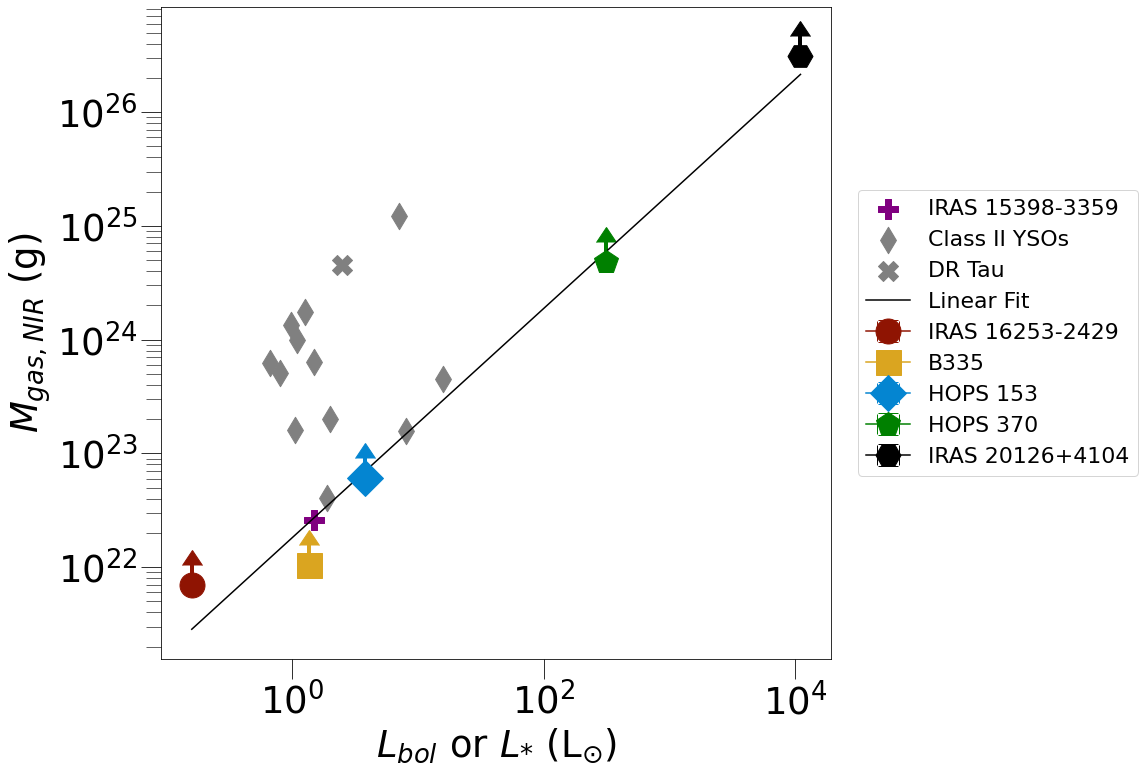

In [76]:
#plotting a correlation! first we compare N or M with a stellar property
Lbol_list = np.array([0.16, 1.36, 3.8, 315.7, 1.1e4]) #in Lsun
Lbol_moresources_list = np.array([0.24, 1.36, 1.36, 4.4, 4.4, 276.0, 276.0, 1.1e4, 1.1e4]) #in Lsun
Rdisk_list = np.array([8, 10, 140, 100, 860]) #in au
# Ncool_list = [1e33, 1e33, 4.1e35, 1.9e35, 1.5e36]
# Nwarm_list = [3e26, 1.8e26, 2.2e27, 1.5e29, 3.3e30]
# Nhot_list = [9.9e23, 6.8e24, 1.4e25, 1.6e27, 1.5e27]

#make a plot
plt.figure(figsize=(12,12))

#plot data
# plt.scatter(Lbol_list[0], M_gas_10_1_list[0], s=400, color='xkcd:brick red', marker='o', label=protostar_names[0])
# plt.scatter(Lbol_list[1], M_gas_10_1_list[1], s=400, color='goldenrod', marker='s', label=protostar_names[1])
# plt.scatter(Lbol_list[2], M_gas_10_1_list[2], s=400, color='xkcd:cerulean', marker='D', label=protostar_names[2])
# plt.scatter(Lbol_list[3], M_gas_10_1_list[3], s=400, color='green', marker='p', label=protostar_names[3])
# plt.scatter(Lbol_list[4], M_gas_10_1_list[4], s=400, color='black', marker='H', label=protostar_names[4])
plt.errorbar(Lbol_list[0], M_gas_10_1_list[0], xerr=0, yerr=0.5*np.max(M_gas_10_1_list[0]), lolims=True, markersize=25, color='xkcd:brick red', marker='o', elinewidth=4, capsize=10, label=protostar_names[0]) # label=protostar_names[0],
plt.errorbar(Lbol_list[1], M_gas_10_1_list[1], xerr=0, yerr=0.5*np.max(M_gas_10_1_list[1]), lolims=True, markersize=25, color='goldenrod', marker='s', elinewidth=4, capsize=10, label=protostar_names[1]) # label=protostar_names[1],
plt.errorbar(Lbol_list[2], M_gas_10_1_list[2], xerr=0, yerr=0.5*np.max(M_gas_10_1_list[2]), lolims=True, markersize=25, color='xkcd:cerulean', marker='D', elinewidth=4, capsize=10, label=protostar_names[2]) # label=protostar_names[2],
plt.errorbar(Lbol_list[3], M_gas_10_1_list[3], xerr=0, yerr=0.5*np.max(M_gas_10_1_list[3]), lolims=True, markersize=25, color='green', marker='p', elinewidth=4, capsize=10, label=protostar_names[3]) # label=protostar_names[3],
plt.errorbar(Lbol_list[4], M_gas_10_1_list[4], xerr=0, yerr=0.5*np.max(M_gas_10_1_list[4]), lolims=True, markersize=25, color='black', marker='H', elinewidth=4, capsize=10, label=protostar_names[4]) # label=protostar_names[4],


# plt.scatter(Lbol_moresources_list, M_gas_list, marker='o', s=100, color='black')
# plt.errorbar(Lbol_list, Ntot_list, yerr=3.*Ntot_err_list, ls='none', marker='o', markersize=5, elinewidth=3, color='black', label='Measurement')
# plt.plot(Lbol_list, Ncool_list, linestyle='-', color='red', marker='v', markersize=10, label='Cool')
# plt.plot(Lbol_list, Nwarm_list, linestyle=':', color='xkcd:brick orange', marker='o', markersize=10, label='Warm')
# plt.plot(Lbol_list, Nhot_list, linestyle='--', color='blue', marker='^', markersize=10, label='Hot')

#fit a line quickly...
# fit = np.polyfit(np.log10(Lbol_moresources_list), np.log10(M_gas_list), deg=1)
# plt.plot(Lbol_moresources_list, 10**(fit[0] *np.log10(Lbol_moresources_list) + fit[1]), color='black', label='Linear Fit')

# #a whole lot of formatting to do
# plt.xscale('log')
# plt.yscale('log')
# plt.ylabel(r'$\rm N_{tot}$ of CO, v = $1-0$', fontsize=20)
# plt.xlabel(r'$\rm L_{bol} \ (L_{\odot})$', fontsize=20)
# plt.tick_params(axis='x', labelsize=15)
# plt.tick_params(axis='y', labelsize=15)
# plt.tick_params(axis='x', which='major', length=10)
# plt.tick_params(axis='y', which='major', length=10)
# plt.tick_params(axis='x', which='minor', length=5)
# plt.tick_params(axis='y', which='minor', length=5)
# # plt.legend(loc='best', fontsize=20)
# plt.savefig('CentralSource_CO/Lbol_N_corr.pdf')

# plt.errorbar(Lbol_list, np.array(N_v0_list) * mass_units, yerr=3.*Ntot_err_list * mass_units, ls='none', marker='o', markersize=5, elinewidth=3, color='black', label='Measurement')
# plt.plot(Lbol_list, Ncool_list, linestyle='-', color='red', marker='v', markersize=10, label='Cool')
# plt.plot(Lbol_list, Nwarm_list, linestyle=':', color='xkcd:brick orange', marker='o', markersize=10, label='Warm')
# plt.plot(Lbol_list, Nhot_list, linestyle='--', color='blue', marker='^', markersize=10, label='Hot')

#fit a line quickly...
# fit = np.polyfit(np.log10(Lbol_list), np.log10(np.array(N_v0_list) * mass_units), deg=1)
# plt.plot(Lbol_list, 10**(fit[0] *np.log10(Lbol_list) + fit[1]), color='black', label='Linear Fit')

#IRAS 15398-3359, h2 gas mass in grams
# https://www.wolframalpha.com/input?i=1.3e-11+solar+masses+to+grams
mgas_h2 = 2.585e22
plt.scatter(1.5, mgas_h2, s=400, color='purple', label='IRAS 15398-3359', marker='P') #from C Salyk 2024



#class I/II examples
# L_drTau = 1.56 #this is Lstar, according to https://iopscience.iop.org/article/10.1088/0067-0049/180/1/84/pdf (watson 2009?); measures a BROAD AND NARROW component (according to banzatti) but primarily narrow triangular here!
# N_CO_drTau = 10**18.9 #using N from https://iopscience.iop.org/article/10.1088/0004-637X/731/2/130/pdf
# Z_CO_v_drTau = (1 - np.exp(-Z_v_const / 1250.0))**(-d_i) #assume Trot ~ Tvib here...
# Ntot_10_1 = (N10_1) / (np.exp(-T_vib_list[i] / E_v_CO)) * (Z_CO_v)
# M_CO_drTAu = mass_units * N_CO_drTau #assume NCO is the total here... # 0.01 Msun to 1.9889e+31 for total?
''' 
stars in last table with L* and NCO include:LkHa330, V710Tau, AATau, DRTau, HD135344B, GQLup, AS205,  VSSG1, DoAr24E, SR9, V853Oph, Haro1-16, WaOph6
stars without L* or NCO include: LkHa362, LkHa327, LkCa8, IQTau, CoKuTau4, DNTau, FXTau, ...all the sources in Cha(N), Sz50, HTLup, GWLup, IMLup, HD142527, RULup, RYLup, EXLup, Haro1-1(N), Haro1-4(L), DoAr25, SR21, ROX sources have neither, Haro1-17,RNO90(L), the rest here
'''
clasii_L_star = [16, 1.1, 0.98, 2.5, 8.00, 0.8, 7.1, 1.5, 1.26,1.9, 1.05, 2, 0.67] #note that it is not Lbol if from Salyk, would be L* from Table 4; if wanting Lbol->Evans09 or Enoch09 from vizier
classii_log_N_CO = [17.4, 19.3, 18.6, 18.9, 17.9, 18.6, 18.7, 18.6, 18.3, 16.9, 18.0, 18.2, 18.5]
classii_RCO = [0.3, 0.05, 0.13, 0.17, 0.1, 0.08, 0.35, 0.09, 0.21, 0.16, 0.09, 0.08, 0.1]
classii_N_tot = 10**(np.array(classii_log_N_CO)) * np.pi * (np.array(classii_RCO)*1.496e+13)**2.0 #log(cm^-2) * pi * (R_CO * au to cm)^2
classii_Mgas = mass_units * classii_N_tot
plt.scatter(np.concatenate((clasii_L_star[0:3], clasii_L_star[4:])), np.concatenate((classii_Mgas[0:3], classii_Mgas[4:])), s=350, color='gray', marker='d' , label='Class II YSOs')
plt.scatter(clasii_L_star[3], classii_Mgas[3], s=400, color='gray', label='DR Tau', marker='X')


#annotate with Class 0 / Class II
# plt.annotate('Class 0', xy = (0.4, 0.1), xycoords = 'axes fraction', fontsize=30)
# plt.annotate('Class II', xy = (0.1, 0.8), xycoords = 'axes fraction', fontsize=30)



#fit a line quickly...once more!
full_L_list = np.append(Lbol_list, 1.5)
full_Mgas_list = np.append(np.array(M_gas_10_1_list), mgas_h2)
fit, cov = np.polyfit(np.log10(full_L_list), np.log10(full_Mgas_list), deg=1, cov=True)
print('Slope: ', fit[0], '. Intercept: ', fit[1])
print('UNCSlope: ', cov[0][0], '. UNCIntercept: ',  cov[1][1])
plt.plot(Lbol_list, 10**(fit[0] *np.log10(Lbol_list) + fit[1]), color='black', label='Linear Fit')

#a whole lot of formatting to do
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$M_{gas,NIR} \rm \ (g)$', fontsize=37)
plt.xlabel(r'$L_{bol} \ {\rm or} \ L_{*} \rm \ (L_{\odot})$', fontsize=37)
plt.tick_params(axis='x', labelsize=37)
plt.tick_params(axis='y', labelsize=37)
plt.tick_params(axis='x', which='major', length=20)
plt.tick_params(axis='y', which='major', length=20)
plt.tick_params(axis='x', which='minor', length=15)
plt.tick_params(axis='y', which='minor', length=15)
plt.legend(bbox_to_anchor=(1.475, 0.5), loc='center right', fontsize=22)
plt.savefig('CentralSource_CO/Lbol_Msun_corr.pdf', bbox_inches='tight')

# print(Ntot_list)
# print(3.*np.array(Ntot_err_list))
# # print(np.array(Ntot_list) * 1e4 * 2e-24 / 2e33)
# print(np.array(N_v0_list) * mass_units)



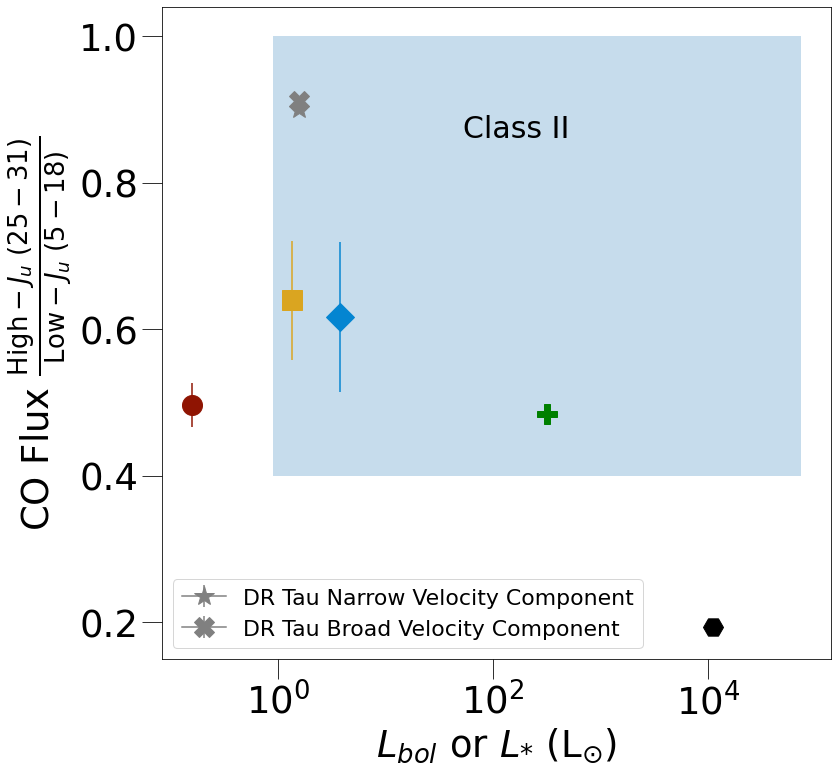

In [30]:
#plotting a correlation! first we compare N or M with a stellar property
Lbol_list = np.array([0.16, 1.36, 3.8, 315.7, 1.1e4]) #in Lsun
# Rdisk_list = np.array([8, 10, 140, 100, 860]) #in au

#make a plot
plt.figure(figsize=(12,12))
color_list = ['xkcd:brick red', 'goldenrod', 'xkcd:cerulean', 'green', 'black'] #other params
shape_list = ['o', 's', 'D', 'P', 'H']

#all Class II sources from banzatti+ 2022
plt.fill_between([.91, 72300], 0.4, 1.0, alpha=0.25) #the x-values are from L*+Lacc of CI Tau and MWC 297 # , label='Class II YSOs'

#next, loop through different states for our high J and low J lines
for i in range(len(protostar_names)):
    co_j_list = []
    co_r_lam_list = []
    co_p_lam_list = []
    co_r_flux_list = []
    co_p_flux_list = []
    co_r_unc_list = []
    co_p_unc_list = []

    p_match = [o for o in latex_formatted_data if ('P' in o[1] and 'v = 1 - 0' in o[1])] #check for P state and v state, will need as we go...
    #for each v state, go through the R branch lines to find the associated P branch lines
    for idx in range(len(latex_formatted_data)): #inefficient as we don't have to search through the whole list, but being basic for now
            #we need to check which line we're handling
            co_r_str = latex_formatted_data[idx][1] #the string for a given line

            #only continue on certain conditions for R
            if co_r_str.find('R') >= 0 and co_r_str.find('v = 1 - 0') >= 0:

                    #useful CO values derived just from R-branch lines of a certain v state
                    co_r_num = int(latex_formatted_data[idx][1][-2:]) #which r-branch line?
                    co_j = co_r_num - 1 #which j then? delta_J in R branch is 1, so we need to subtract 1 to get J!

                    #search for the associated P-branch line
                    for p in p_match:
                            #need these to check if a valid comparison can be made
                            co_p_num = int(p[1][-2:]) #which r-branch line?
                            co_r_flux_unc_str = latex_formatted_data[idx][i+2].split(' \\\\')[0]
                            co_p_flux_unc_str = p[i+2].split(' \\\\')[0]

                            #if we have a match then...store values!
                            if co_p_num == co_j - 1 and p[1].find('v = 1 - 0') >= 0 and co_r_flux_unc_str != '--' and co_p_flux_unc_str != '--':
                                    #getting fluxes and uncertainties in R branch
                                    co_r_lam = float(latex_formatted_data[i][0])

                                    co_r_flux = float(co_r_flux_unc_str.split('$')[0]) * flux_norm_list[i]
                                    co_r_unc = float(co_r_flux_unc_str.split('$')[-1]) * flux_norm_list[i]
                                    #same in p branch
                                    co_p_lam = float(p[0])
                                    co_p_flux = float(co_p_flux_unc_str.split('$')[0]) * flux_norm_list[i]
                                    co_p_unc = float(co_p_flux_unc_str.split('$')[-1]) * flux_norm_list[i]

                                    #separate flux data into lists
                                    co_j_list.append(co_j)
                                    co_r_lam_list.append(co_r_lam)
                                    co_p_lam_list.append(co_p_lam)
                                    co_r_flux_list.append(co_r_flux)
                                    co_p_flux_list.append(co_p_flux)
                                    co_r_unc_list.append(co_r_unc)
                                    co_p_unc_list.append(co_p_unc)

    #now can use lists! before resetting for next protostar and/or v-state; first make sure arrays are numpy...
    co_j_list = np.array(co_j_list)
    co_r_lam_list = np.array(co_r_lam_list)
    co_p_lam_list = np.array(co_p_lam_list)
    co_r_flux_list = np.array(co_r_flux_list)
    co_p_flux_list = np.array(co_p_flux_list)
    co_r_unc_list = np.array(co_r_unc_list)
    co_p_unc_list = np.array(co_p_unc_list)

    ''' with this we can go ahead and grab the low J and high J ratio!
    high-J (J = 25–31 ) to low-J (J = 5–18) line flux ratio for
    v = 1 − 0 lines (a proxy for the rotational excitation), 
    the v = 2 − 1 to v = 1 − 0 line flux ratio (a proxy for the vibrational excitation), 
    and the 12CO/13CO ratio (a proxy for column density).
    '''
    low_j_avg = []
    low_j_avg_unc = []
    high_j_avg = []
    high_j_avg_unc = []
    for j in range(len(co_j_list)):
        if co_j_list[j] >= 5 and co_j_list[j] <= 18: #for both r and p branches
            low_j_avg.append(co_r_flux_list[j])
            low_j_avg.append(co_p_flux_list[j])
            low_j_avg_unc.append(co_r_unc_list[j])
            low_j_avg_unc.append(co_p_unc_list[j])
        if co_j_list[j] >= 25 and co_j_list[j] <= 31:
            high_j_avg.append(co_r_flux_list[j])
            high_j_avg.append(co_p_flux_list[j])
            high_j_avg_unc.append(co_r_unc_list[j])        
            high_j_avg_unc.append(co_p_unc_list[j])        

    rotational_ratio = np.mean(high_j_avg) / np.mean(low_j_avg) #compute avgs 

    #ignoring covariance, the ratio_unc is just unc^2 = ratio^2 * ((sigma_A^2/A^2) + sigma_B^2/B^2)
    #where sigma_A and sigma_B is from summing all the sources in quadrature (possibly dividing by N data points, we'll see)
    rotational_ratio_unc = rotational_ratio * np.sqrt(np.sqrt(np.sum(np.array(low_j_avg_unc)**2.0)/len(low_j_avg_unc))**2.0/np.mean(low_j_avg)**2.0 + \
                            np.sqrt(np.sum(np.array(high_j_avg_unc)**2.0)/len(high_j_avg_unc))**2.0/np.mean(high_j_avg)**2.0)

    #plot data
    plt.errorbar(Lbol_list[i], rotational_ratio, yerr=rotational_ratio_unc, markersize=20, color=color_list[i], marker=shape_list[i]) # , label=protostar_names[i]

#class I/II examples
L_drTau = 1.56 #this is Lstar, according to https://iopscience.iop.org/article/10.1088/0067-0049/180/1/84/pdf (watson 2009?); measures a BROAD AND NARROW component (according to banzatti) but primarily narrow triangular here!
ratio_drtau = 1.90e-14 / 2.11e-14 #high j / low j
err_drtau = ratio_drtau * np.sqrt((2.38e-17/1.90e-14)**2.0 + (2.71e-17/2.11e-14)**2.0) #ratio * sqrt(highj^2 + lowj^2)
plt.errorbar(L_drTau, ratio_drtau, yerr=err_drtau, markersize=20, color='gray', label='DR Tau Narrow Velocity Component', marker='*')
ratio_drtau = 4.91e-14 / 5.39e-14 #high j / low j
err_drtau = ratio_drtau * np.sqrt((3.13e-17/4.91e-14)**2.0 + (4.15e-17/5.39e-14)**2.0) #ratio * sqrt(highj^2 + lowj^2)
plt.errorbar(L_drTau, ratio_drtau, yerr=err_drtau, markersize=20, color='gray', label='DR Tau Broad Velocity Component', marker='X')
L_tmc1a = 2.8 #this is lbol according to https://www.aanda.org/articles/aa/pdf/2011/09/aa16246-10.pdf (herczeg 2011, table 2, pg 4); measures a BROAD AND NARROW component
#unsure what the ratio is, not enough lines detected?

#annotate with Class 0 / Class II
# plt.annotate('Class 0', xy = (0.4, 0.15), xycoords = 'axes fraction', fontsize=30)
plt.annotate('Class II', xy = (0.45, 0.8), xycoords = 'axes fraction', fontsize=30)

#a whole lot of formatting to do
plt.xscale('log')
# plt.yscale('log')
plt.ylabel(r'${\rm CO \ Flux \ }  \frac{{\rm High-}J_u \ (25-31)}{{\rm Low-}J_u \ (5-18)}$', fontsize=37)
plt.xlabel(r'$L_{bol} \ {\rm or} \ L_{*} \rm \ (L_{\odot})$', fontsize=37)
plt.tick_params(axis='x', labelsize=37)
plt.tick_params(axis='y', labelsize=37)
plt.tick_params(axis='x', which='major', length=20)
plt.tick_params(axis='y', which='major', length=20)
plt.tick_params(axis='x', which='minor', length=15)
plt.tick_params(axis='y', which='minor', length=15)
plt.legend(loc='lower left', fontsize=22)
plt.savefig('CentralSource_CO/lowj_highj_banzatti22.pdf', bbox_inches='tight')

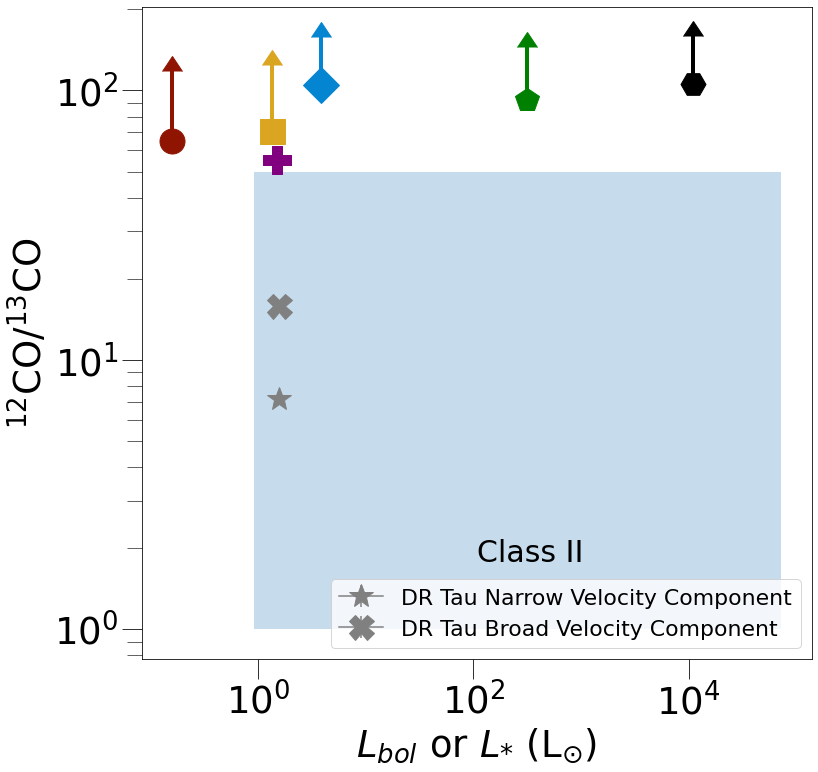

In [73]:
#plotting a correlation! first we compare N or M with a stellar property
Lbol_list = np.array([0.16, 1.36, 3.8, 315.7, 1.1e4]) #in Lsun
Lbol_moresources_list = np.array([0.24, 1.36, 1.36, 4.4, 4.4, 276.0, 276.0, 1.1e4, 1.1e4]) #in Lsun
Rdisk_list = np.array([8, 10, 140, 100, 860]) #in au
# Ncool_list = [1e33, 1e33, 4.1e35, 1.9e35, 1.5e36]
# Nwarm_list = [3e26, 1.8e26, 2.2e27, 1.5e29, 3.3e30]
# Nhot_list = [9.9e23, 6.8e24, 1.4e25, 1.6e27, 1.5e27]
co_weighted_average = [39, 51, 30, 60, 50]
co_isotope_ratio_list = [65, 71, 105, 92, 106]
co_isotope_lowerlim_diffs = np.array(co_isotope_ratio_list) #- np.array(co_weighted_average)

#make a plot
plt.figure(figsize=(12,12))

#all Class II sources from banzatti+ 2022
plt.fill_between([.91, 72300], 1, 50, alpha=0.25) #the x-values are from L*+Lacc of CI Tau and MWC 297 # , label='Class II YSOs'


#plot data
plt.errorbar(Lbol_list[0], co_isotope_lowerlim_diffs[0], xerr=0, yerr=0.5*np.max(co_isotope_lowerlim_diffs), lolims=True, markersize=25, color='xkcd:brick red', marker='o', elinewidth=4, capsize=10) # label=protostar_names[0],
plt.errorbar(Lbol_list[1], co_isotope_lowerlim_diffs[1], xerr=0, yerr=0.5*np.max(co_isotope_lowerlim_diffs), lolims=True, markersize=25, color='goldenrod', marker='s', elinewidth=4, capsize=10) # label=protostar_names[1],
plt.errorbar(Lbol_list[2], co_isotope_lowerlim_diffs[2], xerr=0, yerr=0.5*np.max(co_isotope_lowerlim_diffs), lolims=True, markersize=25, color='xkcd:cerulean', marker='D', elinewidth=4, capsize=10) # label=protostar_names[2],
plt.errorbar(Lbol_list[3], co_isotope_lowerlim_diffs[3], xerr=0, yerr=0.5*np.max(co_isotope_lowerlim_diffs), lolims=True, markersize=25, color='green', marker='p', elinewidth=4, capsize=10) # label=protostar_names[3],
plt.errorbar(Lbol_list[4], co_isotope_lowerlim_diffs[4], xerr=0, yerr=0.5*np.max(co_isotope_lowerlim_diffs), lolims=True, markersize=25, color='black', marker='H', elinewidth=4, capsize=10) # label=protostar_names[4],

#IRAS 15398-3359
plt.scatter(1.5, 55, s=750, color='purple', marker='P') #from C Salyk 2024


#dr tau
L_drTau = 1.56 #this is Lstar, according to https://iopscience.iop.org/article/10.1088/0067-0049/180/1/84/pdf (watson 2009?); measures a BROAD AND NARROW component (according to banzatti) but primarily narrow triangular here!
co_isotope_drTau = (2.11e-14 + 1.90e-14)/2.0 / (2.79e-15)
co_isotope_err_drTau = co_isotope_drTau * np.sqrt(np.sqrt(2.71e-17**2.0 + 2.38e-17**2.0)**2.0 / (2.11e-14 + 1.90e-14)**2.0 + (1.65e-17)**2.0 / (2.79e-15)**2.0)
plt.errorbar(L_drTau, co_isotope_drTau, yerr=co_isotope_err_drTau, markersize=25, color='gray', label='DR Tau Narrow Velocity Component', marker='*')
co_isotope_drTau = (5.39e-14 + 4.91e-14)/2.0 / (3.25e-15)
co_isotope_err_drTau = co_isotope_drTau * np.sqrt(np.sqrt(4.15e-17**2.0 + 3.13e-17**2.0)**2.0 / (5.39e-14 + 4.91e-14)**2.0 + (2.21e-17)**2.0 / (3.25e-15)**2.0)
plt.errorbar(L_drTau, co_isotope_drTau, yerr=co_isotope_err_drTau, markersize=25, color='gray', label='DR Tau Broad Velocity Component', marker='X')


#annotate with Class 0 / Class II
# plt.annotate('Class 0', xy = (0.3, 0.9), xycoords = 'axes fraction', fontsize=30)
plt.annotate('Class II', xy = (0.5, 0.15), xycoords = 'axes fraction', fontsize=30)


#a whole lot of formatting to do
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\rm {}^{12}CO / {}^{13}CO$', fontsize=37)
plt.xlabel(r'$L_{bol} \ {\rm or} \ L_{*} \rm \ (L_{\odot})$', fontsize=37)
plt.tick_params(axis='x', labelsize=37)
plt.tick_params(axis='y', labelsize=37)
plt.tick_params(axis='x', which='major', length=20)
plt.tick_params(axis='y', which='major', length=20)
plt.tick_params(axis='x', which='minor', length=15)
plt.tick_params(axis='y', which='minor', length=15)
plt.legend(loc='lower right', fontsize=22)
plt.savefig('CentralSource_CO/12co_13co_ratios.pdf', bbox_inches='tight')


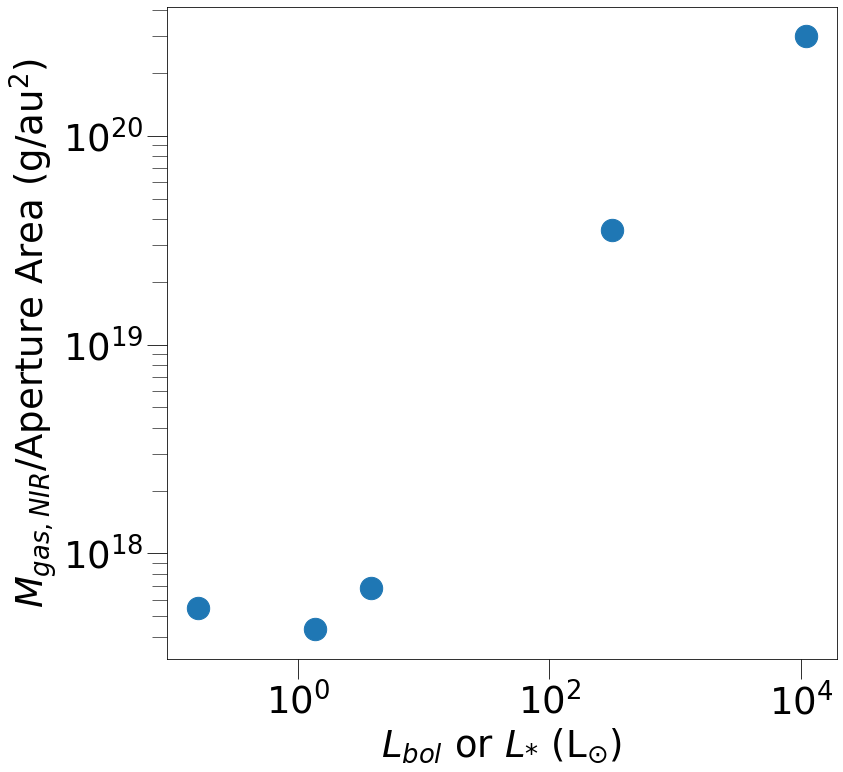

In [96]:
#other example plots
#checking our correlation...
Lbol_list = np.array([0.16, 1.36, 3.8, 315.7, 1.1e4]) #in Lsun
Lbol_moresources_list = np.array([0.24, 1.36, 1.36, 4.4, 4.4, 276.0, 276.0, 1.1e4, 1.1e4]) #in Lsun

#make a plot
plt.figure(figsize=(12,12))

#a whole lot of formatting to do
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', labelsize=37)
plt.tick_params(axis='y', labelsize=37)
plt.tick_params(axis='x', which='major', length=20)
plt.tick_params(axis='y', which='major', length=20)
plt.tick_params(axis='x', which='minor', length=15)
plt.tick_params(axis='y', which='minor', length=15)

#if working in lumonisty and distance
# plt.scatter(dist_list**2, Lbol_list, s=500)
# plt.ylabel(r'$L_{bol} \ {\rm or} \ L_{*} \rm \ (L_{\odot})$', fontsize=37)
# plt.xlabel(r'$\rm Distance^2\ (cm^2)$', fontsize=37)
# plt.legend(loc='lower right', fontsize=22)
# plt.savefig('CentralSource_CO/dSQ_L.pdf', bbox_inches='tight')

#if working in gas masses and distance
# plt.scatter(dist_list**2, M_gas_10_1_list, s=500)
# plt.ylabel(r'$M_{gas,NIR} \rm \ (g)$', fontsize=37)
# plt.xlabel(r'$\rm Distance^2\ (cm^2)$', fontsize=37)
# plt.legend(loc='lower right', fontsize=22)
# plt.savefig('CentralSource_CO/dSQ_M.pdf', bbox_inches='tight')

#if doing mass/distance vs. luminosity
# plt.scatter(Lbol_list, M_gas_10_1_list/dist_list**2.0, s=500)
# plt.ylabel(r'$M_{gas,NIR}/\rm Distance^2 \ (g/cm^2)$', fontsize=37)
# plt.xlabel(r'$L_{bol} \ {\rm or} \ L_{*} \rm \ (L_{\odot})$', fontsize=37)
# plt.legend(loc='lower right', fontsize=22)
# plt.savefig('CentralSource_CO/L_MperdSQ.pdf', bbox_inches='tight')

#if doing mass/aperture area vs. luminosity
aper_area_list = 2.0 * np.array([80*80, 110*110, 210*210, 260*260, 760*680])
plt.scatter(Lbol_list, M_gas_10_1_list/aper_area_list, s=500)
plt.ylabel(r'$M_{gas,NIR}/\rm Aperture\ Area  \ (g/au^2)$', fontsize=37)
plt.xlabel(r'$L_{bol} \ {\rm or} \ L_{*} \rm \ (L_{\odot})$', fontsize=37)
# plt.legend(loc='lower right', fontsize=22)
plt.savefig('CentralSource_CO/MperA_L.pdf', bbox_inches='tight')


Slope:  0.008162297792534105 . Intercept:  22.25673471417862
UNCSlope:  0.005063106730531494 . UNCIntercept:  0.019912897570185308


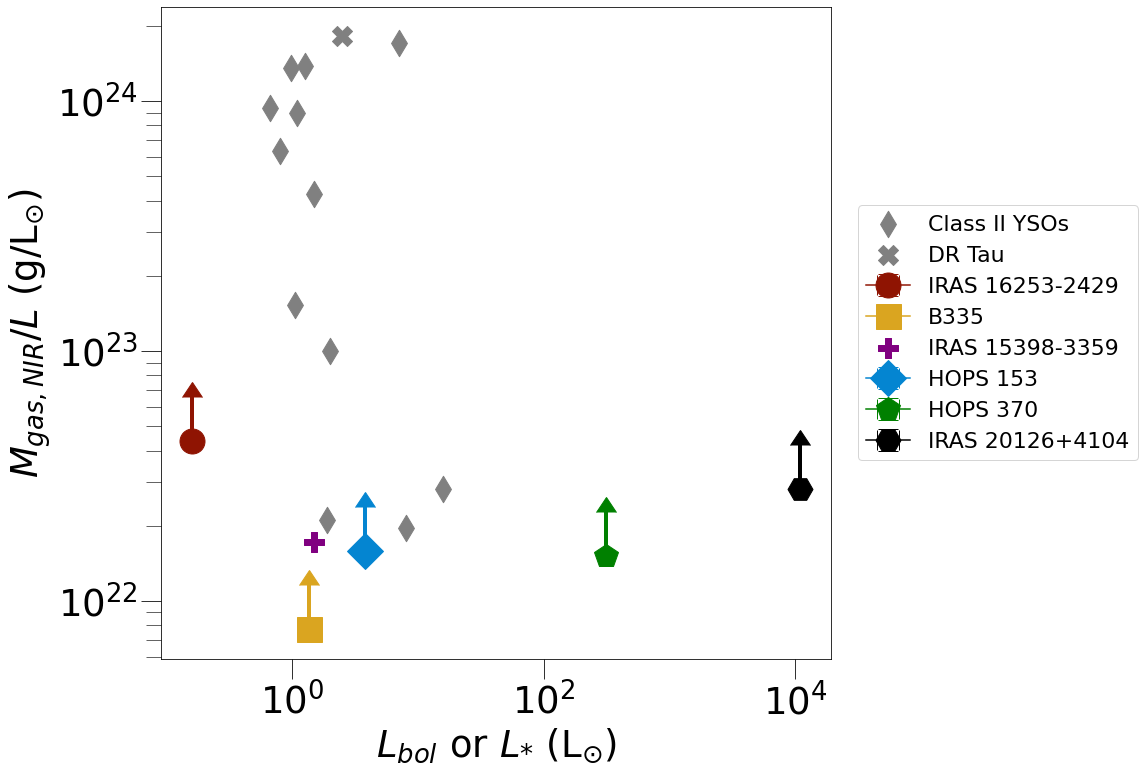

In [103]:
#plotting a correlation! first we compare N or M with a stellar property
Lbol_list = np.array([0.16, 1.36, 3.8, 315.7, 1.1e4]) #in Lsun
Lbol_moresources_list = np.array([0.24, 1.36, 1.36, 4.4, 4.4, 276.0, 276.0, 1.1e4, 1.1e4]) #in Lsun
Rdisk_list = np.array([8, 10, 140, 100, 860]) #in au

#IRAS 15398-3359, h2 gas mass in grams
# https://www.wolframalpha.com/input?i=1.3e-11+solar+masses+to+grams
mgas_h2 = 2.585e22

#make a plot
plt.figure(figsize=(12,12))

#plot data
plt.errorbar(Lbol_list[0], M_gas_10_1_list[0]/Lbol_list[0], xerr=0, yerr=0.5*np.max(M_gas_10_1_list[0]/Lbol_list[0]), lolims=True, markersize=25, color='xkcd:brick red', marker='o', elinewidth=4, capsize=10, label=protostar_names[0]) # label=protostar_names[0],
plt.errorbar(Lbol_list[1], M_gas_10_1_list[1]/Lbol_list[1], xerr=0, yerr=0.5*np.max(M_gas_10_1_list[1]/Lbol_list[1]), lolims=True, markersize=25, color='goldenrod', marker='s', elinewidth=4, capsize=10, label=protostar_names[1]) # label=protostar_names[1],
plt.scatter(1.5, mgas_h2/1.5, s=400, color='purple', label='IRAS 15398-3359', marker='P') #from C Salyk 2024
plt.errorbar(Lbol_list[2], M_gas_10_1_list[2]/Lbol_list[2], xerr=0, yerr=0.5*np.max(M_gas_10_1_list[2]/Lbol_list[2]), lolims=True, markersize=25, color='xkcd:cerulean', marker='D', elinewidth=4, capsize=10, label=protostar_names[2]) # label=protostar_names[2],
plt.errorbar(Lbol_list[3], M_gas_10_1_list[3]/Lbol_list[3], xerr=0, yerr=0.5*np.max(M_gas_10_1_list[3]/Lbol_list[3]), lolims=True, markersize=25, color='green', marker='p', elinewidth=4, capsize=10, label=protostar_names[3]) # label=protostar_names[3],
plt.errorbar(Lbol_list[4], M_gas_10_1_list[4]/Lbol_list[4], xerr=0, yerr=0.5*np.max(M_gas_10_1_list[4]/Lbol_list[4]), lolims=True, markersize=25, color='black', marker='H', elinewidth=4, capsize=10, label=protostar_names[4]) # label=protostar_names[4],




''' 
stars in last table with L* and NCO include:LkHa330, V710Tau, AATau, DRTau, HD135344B, GQLup, AS205,  VSSG1, DoAr24E, SR9, V853Oph, Haro1-16, WaOph6
stars without L* or NCO include: LkHa362, LkHa327, LkCa8, IQTau, CoKuTau4, DNTau, FXTau, ...all the sources in Cha(N), Sz50, HTLup, GWLup, IMLup, HD142527, RULup, RYLup, EXLup, Haro1-1(N), Haro1-4(L), DoAr25, SR21, ROX sources have neither, Haro1-17,RNO90(L), the rest here
'''
clasii_L_star = [16, 1.1, 0.98, 2.5, 8.00, 0.8, 7.1, 1.5, 1.26,1.9, 1.05, 2, 0.67] #note that it is not Lbol if from Salyk, would be L* from Table 4; if wanting Lbol->Evans09 or Enoch09 from vizier
classii_log_N_CO = [17.4, 19.3, 18.6, 18.9, 17.9, 18.6, 18.7, 18.6, 18.3, 16.9, 18.0, 18.2, 18.5]
classii_RCO = [0.3, 0.05, 0.13, 0.17, 0.1, 0.08, 0.35, 0.09, 0.21, 0.16, 0.09, 0.08, 0.1]
classii_N_tot = 10**(np.array(classii_log_N_CO)) * np.pi * (np.array(classii_RCO)*1.496e+13)**2.0 #log(cm^-2) * pi * (R_CO * au to cm)^2
classii_Mgas = mass_units * classii_N_tot
plt.scatter(np.concatenate((clasii_L_star[0:3], clasii_L_star[4:])), np.concatenate((classii_Mgas[0:3], classii_Mgas[4:])) / np.concatenate((clasii_L_star[0:3], clasii_L_star[4:])), s=350, color='gray', marker='d' , label='Class II YSOs')
plt.scatter(clasii_L_star[3], classii_Mgas[3]/clasii_L_star[3], s=400, color='gray', label='DR Tau', marker='X')


#fit a line quickly...once more!
full_L_list = np.append(Lbol_list, 1.5)
full_Mgas_norm_list = np.append(np.array(M_gas_10_1_list), mgas_h2) / full_L_list
fit, cov = np.polyfit(np.log10(full_L_list), np.log10(full_Mgas_norm_list), deg=1, cov=True)
print('Slope: ', fit[0], '. Intercept: ', fit[1])
print('UNCSlope: ', cov[0][0], '. UNCIntercept: ',  cov[1][1])
# plt.plot(Lbol_list, 10**(fit[0] *np.log10(Lbol_list) + fit[1]), color='black', label='Linear Fit')

#now can reorder and format the legend
handles,labels = plt.gca().get_legend_handles_labels()
handles = [handles[1], handles[2], handles[3], handles[4], handles[0], handles[5], handles[6], handles[7]]
labels = [labels[1], labels[2], labels[3], labels[4], labels[0], labels[5], labels[6], labels[7]]
plt.legend(handles,labels,bbox_to_anchor=(1.475, 0.5), loc='center right', fontsize=22)


#a whole lot of formatting to do
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$M_{gas,NIR}/L \rm \ (g/L_{\odot})$', fontsize=37)
plt.xlabel(r'$L_{bol} \ {\rm or} \ L_{*} \rm \ (L_{\odot})$', fontsize=37)
plt.tick_params(axis='x', labelsize=37)
plt.tick_params(axis='y', labelsize=37)
plt.tick_params(axis='x', which='major', length=20)
plt.tick_params(axis='y', which='major', length=20)
plt.tick_params(axis='x', which='minor', length=15)
plt.tick_params(axis='y', which='minor', length=15)
plt.savefig('CentralSource_CO/Lbol_Msun_norm.pdf', bbox_inches='tight')


In [32]:
'''  
tricky to compute v2/v1 with our set of lines, but approximately...(using P26 line, around 4.9 microns, around where we can consistently spot v=2-1 lines)
IRAS 16253 -> 1.302/12.673 = 0.103
B335 -> 1.185/5.791 = 0.205
HOPS 153 -> 2.519/11.904 = 0.212
HOPS 370 -> 0.312/4.048 = 0.077
IRAS 20126 -> 0.517/5.839 = 0.089

If we plotted, it would be a decreasing trend like with Ju...
but in this case, that is the *opposite* of what we see with respect to the gray data (barely increasing or untrending with L)
Instead, it matches more like the red, blue, green data, but not even (the luminosity range was too narrow), but the vibrational levels don't seem to add much info to the story (here specifically, it would with all the data in play)

it sort of straddles the line between red and blue triangles for low L and then at high L it levels out into an unexplored parameter space in all plots?
note in banzatti22, double-peak are squares (don't behave like ours) and triangular shapes triangles (like ours)
moreover, red and blue correspond to broad component and narrow component respectively...

so overall, we have triangular shaped lines that are indistinguishable between broad and narrow components (or mixed)...
though, more likely it is red due to the high 12CO/13CO, and this is *indicative of disk winds*!!!...so it COULD be a concentrated disk wind from within Rsubl
could it still be further out in the disk wind? at our densities, it would be so concentrated...
bonus: supposedly trends with inclination and CO FWHM

Another possibility with respect to Banzatti 2017 is that the P10 line luminosity is correlated with the ACCRETION luminosity
yet the vibrational ratio is ANTI correlated with RCO but uncorrelated with luminosity...
'''

"  \ntricky to compute v2/v1 with our set of lines, but approximately...(using P26 line, around 4.9 microns, around where we can consistently spot v=2-1 lines)\nIRAS 16253 -> 1.302/12.673 = 0.103\nB335 -> 1.185/5.791 = 0.205\nHOPS 153 -> 2.519/11.904 = 0.212\nHOPS 370 -> 0.312/4.048 = 0.077\nIRAS 20126 -> 0.517/5.839 = 0.089\n\nIf we plotted, it would be a decreasing trend like with Ju...\nbut in this case, that is the *opposite* of what we see with respect to the gray data (barely increasing or untrending with L)\nInstead, it matches more like the red, blue, green data, but not even (the luminosity range was too narrow), but the vibrational levels don't seem to add much info to the story (here specifically, it would with all the data in play)\n\nit sort of straddles the line between red and blue triangles for low L and then at high L it levels out into an unexplored parameter space in all plots?\nnote in banzatti22, double-peak are squares (don't behave like ours) and triangular shape